In [12]:
import random
import buildNetwork
import basicRunDORA
import pdb
import numpy as np
import seaborn as sns
NUM_ANALOGS = 4
N_COMPONENTS = 10
PER_ANALOG = 5
REPETITIONS = 10

In [17]:
parameters = {'asDORA': True, 'gamma': 0.3,
              'delta': 0.05, 'eta': 0.9,
              'HebbBias': 0.5,
              'bias_retrieval_analogs': False, 'use_relative_act': False, # Changeeeeddd!!!!!!!!
              #'run_order': ['cdr', 'selectTokens', 'r', 'wp', 'm', 'p', 's', 'f', 'c'],
              'run_order': ['cdr', 'selectTokens', 'r', 'm','c'],
              'run_cyles': 100, 'write_on_iteration': 100, 'firingOrderRule': 'in_order',
              'dim_list':[],
              'strategic_mapping': True, 'ignore_object_semantics': False,
              'ignore_memory_semantics': True, 'mag_decimal_precision': 0,
              'exemplar_memory': False, 'recent_analog_bias': True,
              'lateral_input_level': 1, 'screen_width': 1200, 'screen_height': 700,
              'doGUI': False, 'testing': True, 'GUI_update_rate': 50, 'starting_iteration': 0,
              'tokenize': False, 'ho_sem_act_flow': 0, 'remove_uncompressed': False, 'remove_compressed': False,
              'num_choose':10,'one_to_one':True,'max_norm':True, 'filename':'karthikeya/test_sim_custom-google-7-empty_pred.py',
             'len_regularisation':1, 'count_by_RBs':False, 'parent_bias':0.1, 'order_activation_bias':0.5,
             'results':'karthikeya/data/results/google.pkl'}

In [3]:
def init_network(parameters):
    reload(buildNetwork)
    reload(basicRunDORA)
    fileName = parameters['filename']
    f = open(fileName, 'r')
    simType = ''
    d = {'simType': simType}
    f.seek(0)
    exec (f.readline())
    if simType == 'sym_file':
        symstring = ''
        for line in f:
            symstring += line
        exec(symstring)
    # initialise memory
    memory = buildNetwork.initializeMemorySet()
    # interpret sym file
    mysym = buildNetwork.interpretSymfile(symProps)
    # build the network
    memory = basicRunDORA.dataTypes.memorySet()
    memory = buildNetwork.buildTheNetwork(mysym[0], memory)
    network = basicRunDORA.runDORA(memory, parameters)
    memory = basicRunDORA.update_memory_with_levels(memory)
    # run cycles
    # initialise mapping adjacency matrix:
    mapping_adj = np.zeros((len(network.memory.Ps), len(network.memory.Ps)))
    return [network, memory, mapping_adj]

In [4]:
def vis_mappings(mapping_mat, prop_names):
    sns_heatmap = sns.heatmap(mapping_mat, linewidth=0.5,xticklabels=prop_names, yticklabels=prop_names)
    fig = sns_heatmap.get_figure()
    return

In [5]:
def mapping_error(mapping_mat):
    # assuming an even split - NUM_ANALOGS * PER_ANALOG = number of analogs, number of propositions per analog
    # the mapping matrix is ordered by propositions, therefore every n%PER_ANALOG should be mapped together.
    # the mapping_mat is L1 normalised, and so the target matrix should contain values = 1.0/(NUM_ANALOGS - 1)
    target_mat = np.zeros(mapping_mat.shape)
    per_analog = mapping_mat.shape[0]/NUM_ANALOGS
    for row in range(target_mat.shape[0]):
        target_indices = [(idx*per_analog + row%per_analog) for idx in range(NUM_ANALOGS)] # fill the target mapping indices
        target_indices.pop(target_indices.index(row))
        target_mat[row,target_indices] = 1.0/(NUM_ANALOGS - 1)
    mapping_mat = mapping_mat * (target_mat > 0) # keep only diagonals for comparisons
    error_mat = (mapping_mat - target_mat)**2
    error_val = np.sqrt(np.mean(error_mat))
    return error_val

In [6]:
def get_metrics(mapping_mat):
    # mapping_mat contains the predicted mappings
    target_mat = np.zeros(mapping_mat.shape)
    per_analog = mapping_mat.shape[0]/NUM_ANALOGS
    for row in range(target_mat.shape[0]):
        target_indices = [(idx*per_analog + row%per_analog) for idx in range(NUM_ANALOGS)] # fill the target mapping indices
        target_indices.pop(target_indices.index(row))
        target_mat[row,target_indices] = 1
    # target_mat contains the true mappings in boolean values
    # Get True Positives (TP)
    true_positives = sum(sum(mapping_mat * target_mat))
    # False Positives (FP) 
    false_positives =  sum(np.sum(mapping_mat * abs(target_mat-1), axis=0))# gives all those non-zero mappings at the wrong place.
    # False Negatives (FN) giving zero mapping when it should actually be non zero
    false_negatives = sum(np.sum(mapping_mat * abs(target_mat-1), axis=1)) 
    precision = true_positives/(true_positives + false_positives)
    recall = true_positives/(true_positives + false_negatives) 
    f_score = (2 * precision * recall) / (precision + recall)
    rmse = mapping_error(mapping_mat)
    return precision, recall, f_score, rmse

In [ ]:
# networ, memory, mapping_adj = init_network()
for cycle in range(parameters['run_cyles']):
    print('\n\n************************* Cycle: ' + str(cycle+1))

    # clear driver and recipient
    network.memory = basicRunDORA.clearDriverSet(network.memory)
    network.memory = basicRunDORA.clearRecipientSet(network.memory)

    # put the randomly chosen proposition in the driver
    proposition = random.sample(network.memory.Ps,k=parameters['num_choose']) # currently three propositions
    if parameters['num_choose'] > 1:
        proposition_num = []
        for p in proposition:
            proposition_num.append(network.memory.Ps.index(p))
    else:
        proposition_num = network.memory.Ps.index(proposition)

    if parameters['num_choose'] > 1:
        for p_num in proposition_num:
            network.memory = basicRunDORA.add_tokens_to_set(network.memory, p_num, 'P', 'driver')
    else:
        network.memory = basicRunDORA.add_tokens_to_set(network.memory, proposition_num, 'P', 'driver')



    # make sure the driver and the recipient are set
    network.memory = basicRunDORA.findDriverRecipient(network.memory)
    network.do_map()

    # display ALL mappings
    #pdb.set_trace()
    for myP in network.memory.driver.Ps:
        for mapping in myP.mappingConnections:
            map_weight = mapping.weight
            if map_weight > 0:
                map_unit = mapping.recipientToken
                if mapping_adj[network.memory.Ps.index(myP), network.memory.Ps.index(map_unit)] < 0.1:
                    mapping_adj[network.memory.Ps.index(myP), network.memory.Ps.index(map_unit)] = map_weight
                else:
                    mapping_adj[network.memory.Ps.index(myP), network.memory.Ps.index(map_unit)] = (map_weight + 
                        mapping_adj[network.memory.Ps.index(myP), network.memory.Ps.index(map_unit)])/2.0 # DIRTY SOLUTION FOR NOW
            #print str(network.memory.Ps.index(myP)) + str(' -- ') + str(network.memory.Ps.index(map_unit)) + str(' : ') + str(map_weight)
    # display mappings
    print('\n\nMappings:\n')
    basicRunDORA.DORA_GUI.term_map_display(network.memory, only_Ps=True, only_max=False)

In [7]:
def print_map_connections(network):
    for myP in network.memory.driver.Ps:
        for mapping in myP.mappingConnections:
            print myP.name, mapping.recipientToken.name, mapping.weight

In [ ]:
simulated_data = {}
for repetition in range(REPETITIONS):
    network, memory, mapping_adj = init_network(parameters)
    precisions, recalls, fscores, rmses = [],[],[],[]
    for cycle in range(parameters['run_cyles']):
        print('\n\n************************* Cycle: ' + str(cycle+1))
        #pdb.set_trace()
        # clear driver and recipient
        network.memory = basicRunDORA.clearDriverSet(network.memory)
        network.memory = basicRunDORA.clearRecipientSet(network.memory)
        # choose random analog from memory
        analog = random.choice(network.memory.analogs) # currently only one analog
        # choose random propositions from memory

        # put the analog in the driver
        analog_num = network.memory.analogs.index(analog)
        network.memory = basicRunDORA.add_tokens_to_set(network.memory, analog_num, 'analog', 'driver')
        # retrieve analogs similar to one in the driver from LTM
        network.memory = basicRunDORA.findDriverRecipient(network.memory)
        network.do_retrieval()
        network.memory = basicRunDORA.findDriverRecipient(network.memory)

        #print('In driver : ' + network.memory.driver.Ps[0].name[1])
        #if len(network.memory.recipient.Ps) > 0:
        #    print('In recipient : ' + network.memory.recipient.Ps[0].name[1])
        #    if network.memory.recipient.Ps[0].name[1] == '3':
        #        network.do_map()
        #        print('\n\nMappings:\n')
        #        basicRunDORA.DORA_GUI.term_map_display(network.memory, only_Ps=True, only_max=False)

        if len(network.memory.recipient.Ps) > 0: 
            print 'retrieval successful'
            # map the analogs in driver and recipient
            network.do_map()
            # display ALL mappings
            # display mappings
            print('\n\nMappings:\n')
            basicRunDORA.DORA_GUI.term_map_display(network.memory, only_Ps=False, only_max=False)
            # store all mappings : 
            for myP in network.memory.driver.Ps:
                for mapping in myP.mappingConnections:
                    map_weight = mapping.weight
                    map_unit = mapping.recipientToken
                    mapping_adj[network.memory.Ps.index(myP), network.memory.Ps.index(map_unit)] = map_weight
        # append rmse to list to keep track of RMSE evolution
        temp_mapping_adj  = mapping_adj
        for ind in range(temp_mapping_adj.shape[0]):
            if sum(temp_mapping_adj[ind,:]) > 0:
                temp_mapping_adj[ind,:] = temp_mapping_adj[ind,:]/sum(temp_mapping_adj[ind,:])    
        prec,rec,fsc,rmse = get_metrics(temp_mapping_adj)
        precisions.append(prec)
        recalls.append(rec)
        fscores.append(fsc)
        rmses.append(rmse)

    # normalise mappings
    for ind in range(mapping_adj.shape[0]):
        if sum(mapping_adj[ind,:]) > 0:
            mapping_adj[ind,:] = mapping_adj[ind,:]/sum(mapping_adj[ind,:])
    simulated_data[repetition] = [fscores,rmses,mapping_adj]



************************* Cycle: 1
retrieval successful


Mappings:

('P: P00 -- P22 -- mapping_weight=', 0.8317867734846367)
('P: P01 -- P31 -- mapping_weight=', 0.9643347682917607)
('P: P02 -- NONE -- mapping_weight=', 0.0)
('P: P03.1 -- NONE -- mapping_weight=', 0.0)
('P: P03 -- NONE -- mapping_weight=', 0.0)
('P: P04.1 -- NONE -- mapping_weight=', 0.0)
('P: P04 -- NONE -- mapping_weight=', 0.0)
('P: P05.1 -- NONE -- mapping_weight=', 0.0)
('P: P05.2 -- P34.1 -- mapping_weight=', 1)
('P: P05 -- NONE -- mapping_weight=', 0.0)
('P: P06.1 -- NONE -- mapping_weight=', 0.0)
('P: P06.2 -- NONE -- mapping_weight=', 0.0)
('P: P06 -- NONE -- mapping_weight=', 0.0)
('P: P07.1 -- NONE -- mapping_weight=', 0.0)
('P: P07 -- NONE -- mapping_weight=', 0.0)
('RB: detdogs -- deteagles -- mapping_weight=', 0.005726054743619822)
('RB: chasecats -- NONE -- mapping_weight=', 0.0)
('RB: hungrydogs -- NONE -- mapping_weight=', 0.0)
('RB: barkobj -- hissobj -- mapping_weight=', 0.35008606330646924)
('RB:

retrieval successful


Mappings:

('P: P30 -- NONE -- mapping_weight=', 0.0)
('P: P31 -- P31 -- mapping_weight=', 0.9643347682917607)
('P: P32 -- NONE -- mapping_weight=', 0.0)
('P: P33.1 -- P21 -- mapping_weight=', 0.9478753150544)
('P: P33 -- NONE -- mapping_weight=', 0.0)
('P: P34.1 -- P34.1 -- mapping_weight=', 1)
('P: P34 -- NONE -- mapping_weight=', 0.0)
('P: P35.1 -- NONE -- mapping_weight=', 0.0)
('P: P35.2 -- NONE -- mapping_weight=', 0.0)
('P: P35 -- NONE -- mapping_weight=', 0.0)
('P: P36.1 -- NONE -- mapping_weight=', 0.0)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- NONE -- mapping_weight=', 0.0)
('P: P37.1 -- NONE -- mapping_weight=', 0.0)
('P: P37 -- NONE -- mapping_weight=', 0.0)
('RB: detsnakes -- NONE -- mapping_weight=', 0.0)
('RB: eatrats -- NONE -- mapping_weight=', 0.0)
('RB: angrysnakes -- angrysnakes -- mapping_weight=', 0.5651871986955839)
('RB: hissobj -- hissobj -- mapping_weight=', 0.6474309314397995)
('RB: detsnakes -- NONE -- mapping_weight=', 

retrieval successful


Mappings:

('P: P20 -- NONE -- mapping_weight=', 0.0)
('P: P21 -- P21 -- mapping_weight=', 0.9478753150544)
('P: P22 -- P22 -- mapping_weight=', 0.8317867734846367)
('P: P23.1 -- P03.1 -- mapping_weight=', 0.4649741210163375)
('P: P23 -- NONE -- mapping_weight=', 0.0)
('P: P24.1 -- P35.1 -- mapping_weight=', 0.007899168540814844)
('P: P24 -- NONE -- mapping_weight=', 0.0)
('P: P25.1 -- P05.2 -- mapping_weight=', 0.14729769972628637)
('P: P25.2 -- P15.1 -- mapping_weight=', 0.9849866795713307)
('P: P25 -- NONE -- mapping_weight=', 0.0)
('P: P26.1 -- P35.2 -- mapping_weight=', 0.46995665042060353)
('P: P26.2 -- P36.2 -- mapping_weight=', 0.9428587951376424)
('P: P26 -- P36 -- mapping_weight=', 1)
('P: P27.1 -- P36.1 -- mapping_weight=', 0.9094117083133522)
('P: P27 -- P35 -- mapping_weight=', 0.5907220311933785)
('RB: deteagles -- angrysnakes -- mapping_weight=', 0.05245930378504428)
('RB: eatworms -- NONE -- mapping_weight=', 0.0)
('RB: majesticeagles -- majestice

retrieval successful


Mappings:

('P: P20 -- NONE -- mapping_weight=', 0.0)
('P: P21 -- P21 -- mapping_weight=', 0.9478753150544)
('P: P22 -- P22 -- mapping_weight=', 0.8317867734846367)
('P: P23.1 -- P03.1 -- mapping_weight=', 0.9447453908314691)
('P: P23 -- NONE -- mapping_weight=', 0.0)
('P: P24.1 -- P07.1 -- mapping_weight=', 0.7461866730603369)
('P: P24 -- P07 -- mapping_weight=', 0.8842754901673178)
('P: P25.1 -- P04.1 -- mapping_weight=', 0.6521359350249158)
('P: P25.2 -- P15.1 -- mapping_weight=', 0.9849866795713307)
('P: P25 -- NONE -- mapping_weight=', 0.0)
('P: P26.1 -- P35.2 -- mapping_weight=', 0.46995665042060353)
('P: P26.2 -- P36.2 -- mapping_weight=', 0.9428587951376424)
('P: P26 -- P36 -- mapping_weight=', 1)
('P: P27.1 -- P36.1 -- mapping_weight=', 0.9094117083133522)
('P: P27 -- P35 -- mapping_weight=', 0.5907220311933785)
('RB: deteagles -- angrysnakes -- mapping_weight=', 0.05245930378504428)
('RB: eatworms -- fluffycats -- mapping_weight=', 0.7664598335320426)
(

retrieval successful


Mappings:

('P: P00 -- P22 -- mapping_weight=', 0.8317867734846367)
('P: P01 -- P31 -- mapping_weight=', 0.9643347682917607)
('P: P02 -- NONE -- mapping_weight=', 0.0)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.9447453908314691)
('P: P03 -- NONE -- mapping_weight=', 0.0)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.6521359350249158)
('P: P04 -- P35 -- mapping_weight=', 0.4643297041075306)
('P: P05.1 -- P16.1 -- mapping_weight=', 0.14730904785334076)
('P: P05.2 -- P34.1 -- mapping_weight=', 1)
('P: P05 -- NONE -- mapping_weight=', 0.0)
('P: P06.1 -- NONE -- mapping_weight=', 0.0)
('P: P06.2 -- P32 -- mapping_weight=', 0.5894418468750824)
('P: P06 -- NONE -- mapping_weight=', 0.0)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.7461866730603369)
('P: P07 -- P07 -- mapping_weight=', 0.8842754901673178)
('RB: detdogs -- detdogs -- mapping_weight=', 0.021453043115984383)
('RB: chasecats -- towardstraps -- mapping_weight=', 0.4285707894607758)
('RB: hungrydogs -- NONE -- mapp

retrieval successful


Mappings:

('P: P00 -- P22 -- mapping_weight=', 0.8317867734846367)
('P: P01 -- P31 -- mapping_weight=', 0.9643347682917607)
('P: P02 -- NONE -- mapping_weight=', 0.0)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.9447453908314691)
('P: P03 -- NONE -- mapping_weight=', 0.0)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.6521359350249158)
('P: P04 -- P35 -- mapping_weight=', 0.4643297041075306)
('P: P05.1 -- P16.1 -- mapping_weight=', 0.14730904785334076)
('P: P05.2 -- P34.1 -- mapping_weight=', 1)
('P: P05 -- NONE -- mapping_weight=', 0.0)
('P: P06.1 -- NONE -- mapping_weight=', 0.0)
('P: P06.2 -- P32 -- mapping_weight=', 0.5894418468750824)
('P: P06 -- NONE -- mapping_weight=', 0.0)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.7461866730603369)
('P: P07 -- P07 -- mapping_weight=', 0.8842754901673178)
('RB: detdogs -- detdogs -- mapping_weight=', 0.021453043115984383)
('RB: chasecats -- towardstraps -- mapping_weight=', 0.8360088053396542)
('RB: hungrydogs -- NONE -- mapp

retrieval successful


Mappings:

('P: P20 -- P30 -- mapping_weight=', 0.27267329364400783)
('P: P21 -- P21 -- mapping_weight=', 0.9478753150544)
('P: P22 -- P22 -- mapping_weight=', 0.8317867734846367)
('P: P23.1 -- P03.1 -- mapping_weight=', 0.9447453908314691)
('P: P23 -- NONE -- mapping_weight=', 0.0)
('P: P24.1 -- P07.1 -- mapping_weight=', 0.7461866730603369)
('P: P24 -- P07 -- mapping_weight=', 0.8842754901673178)
('P: P25.1 -- P04.1 -- mapping_weight=', 0.6521359350249158)
('P: P25.2 -- P15.1 -- mapping_weight=', 0.9849866795713307)
('P: P25 -- P25 -- mapping_weight=', 0.4760313139872105)
('P: P26.1 -- P35.2 -- mapping_weight=', 0.46995665042060353)
('P: P26.2 -- P36.2 -- mapping_weight=', 0.9428587951376424)
('P: P26 -- P36 -- mapping_weight=', 1)
('P: P27.1 -- P36.1 -- mapping_weight=', 0.9094117083133522)
('P: P27 -- P35 -- mapping_weight=', 0.5907220311933785)
('RB: deteagles -- angrysnakes -- mapping_weight=', 0.05245930378504428)
('RB: eatworms -- fluffycats -- mapping_we

retrieval successful


Mappings:

('P: P00 -- P22 -- mapping_weight=', 0.8317867734846367)
('P: P01 -- P31 -- mapping_weight=', 0.9643347682917607)
('P: P02 -- NONE -- mapping_weight=', 0.0)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.9447453908314691)
('P: P03 -- NONE -- mapping_weight=', 0.0)
('P: P04.1 -- P15.2 -- mapping_weight=', 0.863429700444541)
('P: P04 -- P35 -- mapping_weight=', 0.4643297041075306)
('P: P05.1 -- P14.1 -- mapping_weight=', 0.2659453852458546)
('P: P05.2 -- P34.1 -- mapping_weight=', 1)
('P: P05 -- NONE -- mapping_weight=', 0.0)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.04509436602841954)
('P: P06.2 -- P32 -- mapping_weight=', 0.5894418468750824)
('P: P06 -- P06 -- mapping_weight=', 0.3653861018799072)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.7461866730603369)
('P: P07 -- P07 -- mapping_weight=', 0.8842754901673178)
('RB: detdogs -- detdogs -- mapping_weight=', 0.021453043115984383)
('RB: chasecats -- towardstraps -- mapping_weight=', 0.8360088053396542)
('R

retrieval successful


Mappings:

('P: P00 -- P22 -- mapping_weight=', 0.8317867734846367)
('P: P01 -- P31 -- mapping_weight=', 0.9643347682917607)
('P: P02 -- NONE -- mapping_weight=', 0.0)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.9744957084031939)
('P: P03 -- P03 -- mapping_weight=', 1)
('P: P04.1 -- P15.2 -- mapping_weight=', 0.863429700444541)
('P: P04 -- P14 -- mapping_weight=', 0.6102297683255546)
('P: P05.1 -- P14.1 -- mapping_weight=', 0.2659453852458546)
('P: P05.2 -- P34.1 -- mapping_weight=', 1)
('P: P05 -- NONE -- mapping_weight=', 0.0)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.04509436602841954)
('P: P06.2 -- P32 -- mapping_weight=', 0.5894418468750824)
('P: P06 -- P06 -- mapping_weight=', 0.3653861018799072)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.7461866730603369)
('P: P07 -- P07 -- mapping_weight=', 0.8842754901673178)
('RB: detdogs -- detdogs -- mapping_weight=', 0.021453043115984383)
('RB: chasecats -- towardstraps -- mapping_weight=', 0.8360088053396542)
('RB: 

retrieval successful


Mappings:

('P: P30 -- P10 -- mapping_weight=', 0.6353818443065153)
('P: P31 -- P31 -- mapping_weight=', 0.9643347682917607)
('P: P32 -- P32 -- mapping_weight=', 0.5894418468750824)
('P: P33.1 -- P13.1 -- mapping_weight=', 1)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 1)
('P: P34 -- P17 -- mapping_weight=', 0.7294897557939634)
('P: P35.1 -- P15.1 -- mapping_weight=', 0.37248166461763854)
('P: P35.2 -- P35.2 -- mapping_weight=', 0.46995665042060353)
('P: P35 -- P35 -- mapping_weight=', 0.5907220311933785)
('P: P36.1 -- P36.1 -- mapping_weight=', 0.9094117083133522)
('P: P36.2 -- P36.2 -- mapping_weight=', 0.9428587951376424)
('P: P36 -- P36 -- mapping_weight=', 1)
('P: P37.1 -- P17.1 -- mapping_weight=', 0.8206732178580634)
('P: P37 -- P37 -- mapping_weight=', 0.7309860056325855)
('RB: detsnakes -- intodarkness -- mapping_weight=', 0.0015205436930249175)
('RB: eatrats -- eatrats -- mapping_weight=', 0.07001901626653488)
('RB: 

retrieval successful


Mappings:

('P: P00 -- P22 -- mapping_weight=', 0.8317867734846367)
('P: P01 -- P31 -- mapping_weight=', 0.9643347682917607)
('P: P02 -- NONE -- mapping_weight=', 0.0)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.9744957084031939)
('P: P03 -- P03 -- mapping_weight=', 1)
('P: P04.1 -- P15.2 -- mapping_weight=', 0.863429700444541)
('P: P04 -- P14 -- mapping_weight=', 0.6102297683255546)
('P: P05.1 -- P14.1 -- mapping_weight=', 0.2659453852458546)
('P: P05.2 -- P34.1 -- mapping_weight=', 1)
('P: P05 -- NONE -- mapping_weight=', 0.0)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.04509436602841954)
('P: P06.2 -- P32 -- mapping_weight=', 0.5894418468750824)
('P: P06 -- P26 -- mapping_weight=', 0.42251494856276717)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.7461866730603369)
('P: P07 -- P07 -- mapping_weight=', 0.8842754901673178)
('RB: detdogs -- detdogs -- mapping_weight=', 0.021453043115984383)
('RB: chasecats -- towardstraps -- mapping_weight=', 0.8360088053396542)
('RB:

retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 0.6353818443065153)
('P: P11 -- P11 -- mapping_weight=', 0.1837945964246722)
('P: P12 -- NONE -- mapping_weight=', 0.0)
('P: P13.1 -- P13.1 -- mapping_weight=', 1)
('P: P13 -- P03 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.2659453852458546)
('P: P14 -- P27 -- mapping_weight=', 0.7462168911838065)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.9849866795713307)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.863429700444541)
('P: P15 -- NONE -- mapping_weight=', 0.0)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.5784340993812623)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P16 -- mapping_weight=', 0.2926573144277248)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.8206732178580634)
('P: P17 -- P37 -- mapping_weight=', 0.7309860056325855)
('RB: detlions -- detlions -- mapping_weight=', 0.3741294103007941)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.8419448600324492)
('RB: angrylions -- angryl

retrieval successful


Mappings:

('P: P20 -- P30 -- mapping_weight=', 0.27267329364400783)
('P: P21 -- P21 -- mapping_weight=', 0.9478753150544)
('P: P22 -- P22 -- mapping_weight=', 0.8317867734846367)
('P: P23.1 -- P03.1 -- mapping_weight=', 0.9447453908314691)
('P: P23 -- P23 -- mapping_weight=', 1)
('P: P24.1 -- P07.1 -- mapping_weight=', 0.7461866730603369)
('P: P24 -- P07 -- mapping_weight=', 0.8842754901673178)
('P: P25.1 -- P04.1 -- mapping_weight=', 0.6521359350249158)
('P: P25.2 -- P15.1 -- mapping_weight=', 0.9849866795713307)
('P: P25 -- P25 -- mapping_weight=', 0.4760313139872105)
('P: P26.1 -- P35.2 -- mapping_weight=', 0.46995665042060353)
('P: P26.2 -- P36.2 -- mapping_weight=', 0.9428587951376424)
('P: P26 -- P36 -- mapping_weight=', 1)
('P: P27.1 -- P36.1 -- mapping_weight=', 0.9094117083133522)
('P: P27 -- P27 -- mapping_weight=', 0.7462168911838065)
('RB: deteagles -- deteagles -- mapping_weight=', 0.8410070508776772)
('RB: eatworms -- fluffycats -- mapping_weight='

retrieval successful


Mappings:

('P: P30 -- P10 -- mapping_weight=', 0.6353818443065153)
('P: P31 -- P31 -- mapping_weight=', 0.9643347682917607)
('P: P32 -- P32 -- mapping_weight=', 0.5894418468750824)
('P: P33.1 -- P13.1 -- mapping_weight=', 1)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 1)
('P: P34 -- P17 -- mapping_weight=', 0.7294897557939634)
('P: P35.1 -- P15.1 -- mapping_weight=', 0.37248166461763854)
('P: P35.2 -- P35.2 -- mapping_weight=', 0.46995665042060353)
('P: P35 -- P35 -- mapping_weight=', 0.740464322989135)
('P: P36.1 -- P36.1 -- mapping_weight=', 0.9094117083133522)
('P: P36.2 -- P36.2 -- mapping_weight=', 0.9428587951376424)
('P: P36 -- P36 -- mapping_weight=', 1)
('P: P37.1 -- P17.1 -- mapping_weight=', 0.8206732178580634)
('P: P37 -- P37 -- mapping_weight=', 0.7390530408661447)
('RB: detsnakes -- intodarkness -- mapping_weight=', 0.0015205436930249175)
('RB: eatrats -- eatrats -- mapping_weight=', 0.07001901626653488)
('RB: a

retrieval successful


Mappings:

('P: P00 -- P22 -- mapping_weight=', 0.8317867734846367)
('P: P01 -- P31 -- mapping_weight=', 0.9643347682917607)
('P: P02 -- NONE -- mapping_weight=', 0.0)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.9744957084031939)
('P: P03 -- P03 -- mapping_weight=', 1)
('P: P04.1 -- P15.2 -- mapping_weight=', 0.863429700444541)
('P: P04 -- P35 -- mapping_weight=', 0.740464322989135)
('P: P05.1 -- P14.1 -- mapping_weight=', 0.2659453852458546)
('P: P05.2 -- P34.1 -- mapping_weight=', 1)
('P: P05 -- NONE -- mapping_weight=', 0.0)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.04509436602841954)
('P: P06.2 -- P32 -- mapping_weight=', 0.5894418468750824)
('P: P06 -- P26 -- mapping_weight=', 0.42251494856276717)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.7461866730603369)
('P: P07 -- P07 -- mapping_weight=', 0.8842754901673178)
('RB: detdogs -- detdogs -- mapping_weight=', 1)
('RB: chasecats -- towardstraps -- mapping_weight=', 0.8360088053396542)
('RB: hungrydogs -- NONE 

retrieval successful


Mappings:

('P: P30 -- P10 -- mapping_weight=', 0.6353818443065153)
('P: P31 -- P31 -- mapping_weight=', 0.9643347682917607)
('P: P32 -- P32 -- mapping_weight=', 0.5894418468750824)
('P: P33.1 -- P13.1 -- mapping_weight=', 1)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 1)
('P: P34 -- P17 -- mapping_weight=', 0.7294897557939634)
('P: P35.1 -- P15.1 -- mapping_weight=', 0.37248166461763854)
('P: P35.2 -- P35.2 -- mapping_weight=', 0.46995665042060353)
('P: P35 -- P35 -- mapping_weight=', 0.740464322989135)
('P: P36.1 -- P36.1 -- mapping_weight=', 0.9094117083133522)
('P: P36.2 -- P36.2 -- mapping_weight=', 0.9428587951376424)
('P: P36 -- P36 -- mapping_weight=', 1)
('P: P37.1 -- P17.1 -- mapping_weight=', 0.8206732178580634)
('P: P37 -- P37 -- mapping_weight=', 0.7390530408661447)
('RB: detsnakes -- intodarkness -- mapping_weight=', 0.0015205436930249175)
('RB: eatrats -- eatrats -- mapping_weight=', 0.07001901626653488)
('RB: a

retrieval successful


Mappings:

('P: P00 -- P22 -- mapping_weight=', 0.8317867734846367)
('P: P01 -- P31 -- mapping_weight=', 0.9643347682917607)
('P: P02 -- NONE -- mapping_weight=', 0.0)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.9744957084031939)
('P: P03 -- P03 -- mapping_weight=', 1)
('P: P04.1 -- P15.2 -- mapping_weight=', 0.863429700444541)
('P: P04 -- P35 -- mapping_weight=', 0.740464322989135)
('P: P05.1 -- P14.1 -- mapping_weight=', 0.2659453852458546)
('P: P05.2 -- P34.1 -- mapping_weight=', 1)
('P: P05 -- NONE -- mapping_weight=', 0.0)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.04509436602841954)
('P: P06.2 -- P32 -- mapping_weight=', 0.5894418468750824)
('P: P06 -- P26 -- mapping_weight=', 0.42251494856276717)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.7461866730603369)
('P: P07 -- P07 -- mapping_weight=', 0.8842754901673178)
('RB: detdogs -- detdogs -- mapping_weight=', 1)
('RB: chasecats -- towardstraps -- mapping_weight=', 0.8360088053396542)
('RB: hungrydogs -- NONE 

retrieval successful


Mappings:

('P: P00 -- P22 -- mapping_weight=', 0.8317867734846367)
('P: P01 -- P31 -- mapping_weight=', 0.9643347682917607)
('P: P02 -- NONE -- mapping_weight=', 0.0)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.9744957084031939)
('P: P03 -- P03 -- mapping_weight=', 1)
('P: P04.1 -- P15.2 -- mapping_weight=', 0.863429700444541)
('P: P04 -- P35 -- mapping_weight=', 0.740464322989135)
('P: P05.1 -- P14.1 -- mapping_weight=', 0.2659453852458546)
('P: P05.2 -- P34.1 -- mapping_weight=', 1)
('P: P05 -- NONE -- mapping_weight=', 0.0)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.04509436602841954)
('P: P06.2 -- P32 -- mapping_weight=', 0.5894418468750824)
('P: P06 -- P26 -- mapping_weight=', 0.42251494856276717)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.7461866730603369)
('P: P07 -- P07 -- mapping_weight=', 0.8842754901673178)
('RB: detdogs -- detdogs -- mapping_weight=', 1)
('RB: chasecats -- towardstraps -- mapping_weight=', 0.8360088053396542)
('RB: hungrydogs -- NONE 

retrieval successful


Mappings:

('P: P00 -- P22 -- mapping_weight=', 0.8317867734846367)
('P: P01 -- P31 -- mapping_weight=', 0.9643347682917607)
('P: P02 -- NONE -- mapping_weight=', 0.0)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.9744957084031939)
('P: P03 -- P03 -- mapping_weight=', 1)
('P: P04.1 -- P15.2 -- mapping_weight=', 0.863429700444541)
('P: P04 -- P25 -- mapping_weight=', 0.7416118629384252)
('P: P05.1 -- P14.1 -- mapping_weight=', 0.2659453852458546)
('P: P05.2 -- P34.1 -- mapping_weight=', 1)
('P: P05 -- NONE -- mapping_weight=', 0.0)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.04509436602841954)
('P: P06.2 -- P32 -- mapping_weight=', 0.5894418468750824)
('P: P06 -- P26 -- mapping_weight=', 0.42251494856276717)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.7461866730603369)
('P: P07 -- P07 -- mapping_weight=', 0.8842754901673178)
('RB: detdogs -- detdogs -- mapping_weight=', 1)
('RB: chasecats -- towardstraps -- mapping_weight=', 0.8360088053396542)
('RB: hungrydogs -- NONE

retrieval successful


Mappings:

('P: P00 -- P22 -- mapping_weight=', 0.8317867734846367)
('P: P01 -- P31 -- mapping_weight=', 0.9643347682917607)
('P: P02 -- NONE -- mapping_weight=', 0.0)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.9744957084031939)
('P: P03 -- P03 -- mapping_weight=', 1)
('P: P04.1 -- P15.2 -- mapping_weight=', 0.863429700444541)
('P: P04 -- P25 -- mapping_weight=', 0.7416118629384252)
('P: P05.1 -- P14.1 -- mapping_weight=', 0.2659453852458546)
('P: P05.2 -- P34.1 -- mapping_weight=', 1)
('P: P05 -- P05 -- mapping_weight=', 0.6900900631108948)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.04509436602841954)
('P: P06.2 -- P32 -- mapping_weight=', 0.5894418468750824)
('P: P06 -- P26 -- mapping_weight=', 0.42251494856276717)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.7461866730603369)
('P: P07 -- P07 -- mapping_weight=', 0.8842754901673178)
('RB: detdogs -- detdogs -- mapping_weight=', 1)
('RB: chasecats -- towardstraps -- mapping_weight=', 0.8360088053396542)
('RB: hung

retrieval successful


Mappings:

('P: P20 -- P12 -- mapping_weight=', 0.315923044471778)
('P: P21 -- P21 -- mapping_weight=', 0.9478753150544)
('P: P22 -- P22 -- mapping_weight=', 0.8317867734846367)
('P: P23.1 -- P33.1 -- mapping_weight=', 0.9551658056901859)
('P: P23 -- P23 -- mapping_weight=', 1)
('P: P24.1 -- P07.1 -- mapping_weight=', 0.7461866730603369)
('P: P24 -- P07 -- mapping_weight=', 0.8842754901673178)
('P: P25.1 -- P04.1 -- mapping_weight=', 0.6521359350249158)
('P: P25.2 -- P15.1 -- mapping_weight=', 0.9849866795713307)
('P: P25 -- P25 -- mapping_weight=', 0.7416118629384252)
('P: P26.1 -- P35.2 -- mapping_weight=', 0.46995665042060353)
('P: P26.2 -- P36.2 -- mapping_weight=', 0.9428587951376424)
('P: P26 -- P36 -- mapping_weight=', 1)
('P: P27.1 -- P36.1 -- mapping_weight=', 0.9094117083133522)
('P: P27 -- P27 -- mapping_weight=', 0.7462168911838065)
('RB: deteagles -- deteagles -- mapping_weight=', 0.8410070508776772)
('RB: eatworms -- fluffycats -- mapping_weight=', 

retrieval successful


Mappings:

('P: P30 -- P10 -- mapping_weight=', 0.6353818443065153)
('P: P31 -- P31 -- mapping_weight=', 0.9643347682917607)
('P: P32 -- P32 -- mapping_weight=', 0.5894418468750824)
('P: P33.1 -- P13.1 -- mapping_weight=', 1)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 1)
('P: P34 -- P07 -- mapping_weight=', 0.7635728298804001)
('P: P35.1 -- P15.1 -- mapping_weight=', 0.37248166461763854)
('P: P35.2 -- P35.2 -- mapping_weight=', 0.46995665042060353)
('P: P35 -- P35 -- mapping_weight=', 0.740464322989135)
('P: P36.1 -- P36.1 -- mapping_weight=', 0.9094117083133522)
('P: P36.2 -- P36.2 -- mapping_weight=', 0.9428587951376424)
('P: P36 -- P36 -- mapping_weight=', 1)
('P: P37.1 -- P17.1 -- mapping_weight=', 0.8206732178580634)
('P: P37 -- P37 -- mapping_weight=', 0.7390530408661447)
('RB: detsnakes -- intodarkness -- mapping_weight=', 0.0015205436930249175)
('RB: eatrats -- eatrats -- mapping_weight=', 0.07001901626653488)
('RB: a

retrieval successful


Mappings:

('P: P00 -- P22 -- mapping_weight=', 0.8317867734846367)
('P: P01 -- P31 -- mapping_weight=', 0.9643347682917607)
('P: P02 -- NONE -- mapping_weight=', 0.0)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.9744957084031939)
('P: P03 -- P03 -- mapping_weight=', 1)
('P: P04.1 -- P15.2 -- mapping_weight=', 0.863429700444541)
('P: P04 -- P34 -- mapping_weight=', 0.7583830305338841)
('P: P05.1 -- P14.1 -- mapping_weight=', 0.2659453852458546)
('P: P05.2 -- P34.1 -- mapping_weight=', 1)
('P: P05 -- P05 -- mapping_weight=', 0.6900900631108948)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.04509436602841954)
('P: P06.2 -- P32 -- mapping_weight=', 0.5894418468750824)
('P: P06 -- P26 -- mapping_weight=', 0.42251494856276717)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.7461866730603369)
('P: P07 -- P07 -- mapping_weight=', 0.8842754901673178)
('RB: detdogs -- detdogs -- mapping_weight=', 1)
('RB: chasecats -- towardstraps -- mapping_weight=', 0.8360088053396542)
('RB: hung



************************* Cycle: 77
retrieval successful


Mappings:

('P: P30 -- P10 -- mapping_weight=', 0.6353818443065153)
('P: P31 -- P31 -- mapping_weight=', 0.9643347682917607)
('P: P32 -- P32 -- mapping_weight=', 0.5894418468750824)
('P: P33.1 -- P13.1 -- mapping_weight=', 1)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 1)
('P: P34 -- P07 -- mapping_weight=', 0.7635728298804001)
('P: P35.1 -- P15.1 -- mapping_weight=', 0.37248166461763854)
('P: P35.2 -- P35.2 -- mapping_weight=', 0.46995665042060353)
('P: P35 -- P35 -- mapping_weight=', 0.740464322989135)
('P: P36.1 -- P36.1 -- mapping_weight=', 0.9094117083133522)
('P: P36.2 -- P36.2 -- mapping_weight=', 0.9428587951376424)
('P: P36 -- P36 -- mapping_weight=', 1)
('P: P37.1 -- P17.1 -- mapping_weight=', 0.8206732178580634)
('P: P37 -- P37 -- mapping_weight=', 0.7390530408661447)
('RB: detsnakes -- intodarkness -- mapping_weight=', 0.0015205436930249175)
('RB: eatrats -- eatrats -- mapping_

retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 0.6353818443065153)
('P: P11 -- P11 -- mapping_weight=', 0.1837945964246722)
('P: P12 -- P12 -- mapping_weight=', 0.36474391207292145)
('P: P13.1 -- P13.1 -- mapping_weight=', 1)
('P: P13 -- P03 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.2659453852458546)
('P: P14 -- P27 -- mapping_weight=', 0.7462168911838065)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.9849866795713307)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.863429700444541)
('P: P15 -- P15 -- mapping_weight=', 0.047008623305655056)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.5784340993812623)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P26 -- mapping_weight=', 0.3656635916866347)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.8206732178580634)
('P: P17 -- P37 -- mapping_weight=', 0.7309860056325855)
('RB: detlions -- detlions -- mapping_weight=', 0.3741294103007941)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.8419448600324

retrieval successful


Mappings:

('P: P30 -- P10 -- mapping_weight=', 0.6353818443065153)
('P: P31 -- P31 -- mapping_weight=', 0.9643347682917607)
('P: P32 -- P32 -- mapping_weight=', 0.5894418468750824)
('P: P33.1 -- P13.1 -- mapping_weight=', 1)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 1)
('P: P34 -- P07 -- mapping_weight=', 0.7635728298804001)
('P: P35.1 -- P15.1 -- mapping_weight=', 0.37248166461763854)
('P: P35.2 -- P35.2 -- mapping_weight=', 0.46995665042060353)
('P: P35 -- P35 -- mapping_weight=', 0.740464322989135)
('P: P36.1 -- P36.1 -- mapping_weight=', 0.9094117083133522)
('P: P36.2 -- P36.2 -- mapping_weight=', 0.9428587951376424)
('P: P36 -- P36 -- mapping_weight=', 1)
('P: P37.1 -- P17.1 -- mapping_weight=', 0.8206732178580634)
('P: P37 -- P37 -- mapping_weight=', 0.7390530408661447)
('RB: detsnakes -- intodarkness -- mapping_weight=', 0.0015205436930249175)
('RB: eatrats -- eatrats -- mapping_weight=', 0.07001901626653488)
('RB: a

retrieval successful


Mappings:

('P: P30 -- P10 -- mapping_weight=', 0.6353818443065153)
('P: P31 -- P31 -- mapping_weight=', 0.9643347682917607)
('P: P32 -- P32 -- mapping_weight=', 0.5894418468750824)
('P: P33.1 -- P13.1 -- mapping_weight=', 1)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 1)
('P: P34 -- P07 -- mapping_weight=', 0.7635728298804001)
('P: P35.1 -- P15.1 -- mapping_weight=', 0.37248166461763854)
('P: P35.2 -- P35.2 -- mapping_weight=', 0.46995665042060353)
('P: P35 -- P35 -- mapping_weight=', 0.740464322989135)
('P: P36.1 -- P36.1 -- mapping_weight=', 0.9094117083133522)
('P: P36.2 -- P36.2 -- mapping_weight=', 0.9428587951376424)
('P: P36 -- P36 -- mapping_weight=', 1)
('P: P37.1 -- P17.1 -- mapping_weight=', 0.8206732178580634)
('P: P37 -- P37 -- mapping_weight=', 0.7390530408661447)
('RB: detsnakes -- intodarkness -- mapping_weight=', 0.0015205436930249175)
('RB: eatrats -- eatrats -- mapping_weight=', 0.07001901626653488)
('RB: a

retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 0.6353818443065153)
('P: P11 -- P11 -- mapping_weight=', 0.1837945964246722)
('P: P12 -- P12 -- mapping_weight=', 0.36474391207292145)
('P: P13.1 -- P13.1 -- mapping_weight=', 1)
('P: P13 -- P03 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.2659453852458546)
('P: P14 -- P27 -- mapping_weight=', 0.7462168911838065)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.9849866795713307)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.863429700444541)
('P: P15 -- P15 -- mapping_weight=', 0.047008623305655056)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.5784340993812623)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P26 -- mapping_weight=', 0.38375652674442573)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.8206732178580634)
('P: P17 -- P37 -- mapping_weight=', 0.7309860056325855)
('RB: detlions -- detlions -- mapping_weight=', 0.3741294103007941)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.841944860032

retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 0.6353818443065153)
('P: P11 -- P31 -- mapping_weight=', 0.5014987774995047)
('P: P12 -- P12 -- mapping_weight=', 0.36474391207292145)
('P: P13.1 -- P13.1 -- mapping_weight=', 1)
('P: P13 -- P03 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.2659453852458546)
('P: P14 -- P27 -- mapping_weight=', 0.7462168911838065)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.9849866795713307)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.863429700444541)
('P: P15 -- P15 -- mapping_weight=', 0.047008623305655056)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.5784340993812623)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P26 -- mapping_weight=', 0.38375652674442573)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.8206732178580634)
('P: P17 -- P37 -- mapping_weight=', 0.7309860056325855)
('RB: detlions -- detlions -- mapping_weight=', 0.3741294103007941)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.841944860032

retrieval successful


Mappings:

('P: P00 -- P22 -- mapping_weight=', 0.8317867734846367)
('P: P01 -- P31 -- mapping_weight=', 0.9643347682917607)
('P: P02 -- P02 -- mapping_weight=', 0.018313770427988332)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.9744957084031939)
('P: P03 -- P03 -- mapping_weight=', 1)
('P: P04.1 -- P15.2 -- mapping_weight=', 0.863429700444541)
('P: P04 -- P34 -- mapping_weight=', 0.7583830305338841)
('P: P05.1 -- P14.1 -- mapping_weight=', 0.2659453852458546)
('P: P05.2 -- P34.1 -- mapping_weight=', 1)
('P: P05 -- P05 -- mapping_weight=', 0.6900900631108948)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.04509436602841954)
('P: P06.2 -- P32 -- mapping_weight=', 0.5894418468750824)
('P: P06 -- P26 -- mapping_weight=', 0.42251494856276717)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.7461866730603369)
('P: P07 -- P07 -- mapping_weight=', 0.8842754901673178)
('RB: detdogs -- detdogs -- mapping_weight=', 1)
('RB: chasecats -- towardstraps -- mapping_weight=', 0.836008805339

retrieval successful


Mappings:

('P: P20 -- NONE -- mapping_weight=', 0.0)
('P: P21 -- NONE -- mapping_weight=', 0.0)
('P: P22 -- NONE -- mapping_weight=', 0.0)
('P: P23.1 -- NONE -- mapping_weight=', 0.0)
('P: P23 -- NONE -- mapping_weight=', 0.0)
('P: P24.1 -- NONE -- mapping_weight=', 0.0)
('P: P24 -- NONE -- mapping_weight=', 0.0)
('P: P25.1 -- NONE -- mapping_weight=', 0.0)
('P: P25.2 -- P16.1 -- mapping_weight=', 0.3562461775797938)
('P: P25 -- NONE -- mapping_weight=', 0.0)
('P: P26.1 -- NONE -- mapping_weight=', 0.0)
('P: P26.2 -- P16.2 -- mapping_weight=', 0.9673467929355909)
('P: P26 -- P16 -- mapping_weight=', 1)
('P: P27.1 -- NONE -- mapping_weight=', 0.0)
('P: P27 -- NONE -- mapping_weight=', 0.0)
('RB: deteagles -- detdeer -- mapping_weight=', 0.013855617551370249)
('RB: eatworms -- NONE -- mapping_weight=', 0.0)
('RB: majesticeagles -- NONE -- mapping_weight=', 0.0)
('RB: glideobj -- NONE -- mapping_weight=', 0.0)
('RB: deteagles -- NONE -- mapping_weight=', 0.0)
('RB:

retrieval successful


Mappings:

('P: P00 -- P30 -- mapping_weight=', 0.7578765954518503)
('P: P01 -- P33.1 -- mapping_weight=', 0.7847334499228851)
('P: P02 -- NONE -- mapping_weight=', 0.0)
('P: P03.1 -- NONE -- mapping_weight=', 0.0)
('P: P03 -- P33 -- mapping_weight=', 1)
('P: P04.1 -- P35.1 -- mapping_weight=', 0.4874577491770441)
('P: P04 -- P15 -- mapping_weight=', 0.6195140853889208)
('P: P05.1 -- P24.1 -- mapping_weight=', 0.1284746563496969)
('P: P05.2 -- P15.1 -- mapping_weight=', 0.5724361541388039)
('P: P05 -- NONE -- mapping_weight=', 0.0)
('P: P06.1 -- P15.2 -- mapping_weight=', 0.37575493445844593)
('P: P06.2 -- NONE -- mapping_weight=', 0.0)
('P: P06 -- NONE -- mapping_weight=', 0.0)
('P: P07.1 -- P27.1 -- mapping_weight=', 0.3049858647231033)
('P: P07 -- P27 -- mapping_weight=', 1)
('RB: detdogs -- detsnakes -- mapping_weight=', 0.007724251271466766)
('RB: chasecats -- NONE -- mapping_weight=', 0.0)
('RB: hungrydogs -- NONE -- mapping_weight=', 0.0)
('RB: barkobj -- 

retrieval successful


Mappings:

('P: P10 -- NONE -- mapping_weight=', 0.0)
('P: P11 -- NONE -- mapping_weight=', 0.0)
('P: P12 -- P20 -- mapping_weight=', 0.9421270144509368)
('P: P13.1 -- P03.1 -- mapping_weight=', 0.9985803286859918)
('P: P13 -- P03 -- mapping_weight=', 1)
('P: P14.1 -- P25.2 -- mapping_weight=', 0.04132552798743019)
('P: P14 -- P05 -- mapping_weight=', 0.7782937012308879)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.5724361541388039)
('P: P15.2 -- P36.1 -- mapping_weight=', 1)
('P: P15 -- P15 -- mapping_weight=', 0.6195140853889208)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.3562461775797938)
('P: P16.2 -- P16.2 -- mapping_weight=', 0.9673467929355909)
('P: P16 -- P16 -- mapping_weight=', 1)
('P: P17.1 -- P25.1 -- mapping_weight=', 0.9057666810028817)
('P: P17 -- P25 -- mapping_weight=', 0.8462238478865518)
('RB: detlions -- NONE -- mapping_weight=', 0.0)
('RB: huntdeer -- NONE -- mapping_weight=', 0.0)
('RB: angrylions -- thesky -- mapping_weight=', 0.7112273063697

retrieval successful


Mappings:

('P: P10 -- P00 -- mapping_weight=', 0.26620856281838623)
('P: P11 -- P01 -- mapping_weight=', 0.3988378311246277)
('P: P12 -- P20 -- mapping_weight=', 0.9421270144509368)
('P: P13.1 -- P03.1 -- mapping_weight=', 0.9985803286859918)
('P: P13 -- P03 -- mapping_weight=', 1)
('P: P14.1 -- P37.1 -- mapping_weight=', 0.3726513337756644)
('P: P14 -- P05 -- mapping_weight=', 0.7782937012308879)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.5724361541388039)
('P: P15.2 -- P36.1 -- mapping_weight=', 1)
('P: P15 -- P15 -- mapping_weight=', 0.6195140853889208)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.3562461775797938)
('P: P16.2 -- P16.2 -- mapping_weight=', 0.9673467929355909)
('P: P16 -- P16 -- mapping_weight=', 1)
('P: P17.1 -- P25.1 -- mapping_weight=', 0.9057666810028817)
('P: P17 -- P25 -- mapping_weight=', 0.8462238478865518)
('RB: detlions -- NONE -- mapping_weight=', 0.0)
('RB: huntdeer -- NONE -- mapping_weight=', 0.0)
('RB: angrylions -- thesky -- mappi

retrieval successful


Mappings:

('P: P20 -- P20 -- mapping_weight=', 0.9421270144509368)
('P: P21 -- NONE -- mapping_weight=', 0.0)
('P: P22 -- NONE -- mapping_weight=', 0.0)
('P: P23.1 -- P23.1 -- mapping_weight=', 0.8439185413583548)
('P: P23 -- P23 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.8567671033021743)
('P: P24 -- P24 -- mapping_weight=', 0.776047253161767)
('P: P25.1 -- P25.1 -- mapping_weight=', 0.9057666810028817)
('P: P25.2 -- P16.1 -- mapping_weight=', 0.3562461775797938)
('P: P25 -- P25 -- mapping_weight=', 0.8462238478865518)
('P: P26.1 -- P26.1 -- mapping_weight=', 0.953672023494164)
('P: P26.2 -- P16.2 -- mapping_weight=', 0.9673467929355909)
('P: P26 -- P16 -- mapping_weight=', 1)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.3049858647231033)
('P: P27 -- P27 -- mapping_weight=', 1)
('RB: deteagles -- deteagles -- mapping_weight=', 0.5943199185626387)
('RB: eatworms -- eatworms -- mapping_weight=', 0.6721111267315242)
('RB: majesticeagles -- sm

retrieval successful


Mappings:

('P: P10 -- P00 -- mapping_weight=', 0.26620856281838623)
('P: P11 -- P11 -- mapping_weight=', 0.5794732377143977)
('P: P12 -- P20 -- mapping_weight=', 0.9421270144509368)
('P: P13.1 -- P03.1 -- mapping_weight=', 0.9985803286859918)
('P: P13 -- P03 -- mapping_weight=', 1)
('P: P14.1 -- P37.1 -- mapping_weight=', 0.3726513337756644)
('P: P14 -- P05 -- mapping_weight=', 0.7782937012308879)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.5724361541388039)
('P: P15.2 -- P36.1 -- mapping_weight=', 1)
('P: P15 -- P15 -- mapping_weight=', 0.7001886598152111)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.3562461775797938)
('P: P16.2 -- P16.2 -- mapping_weight=', 0.9673467929355909)
('P: P16 -- P16 -- mapping_weight=', 1)
('P: P17.1 -- P25.1 -- mapping_weight=', 0.9057666810028817)
('P: P17 -- P25 -- mapping_weight=', 0.8462238478865518)
('RB: detlions -- wanderaimlessly -- mapping_weight=', 0.10541870009287743)
('RB: huntdeer -- NONE -- mapping_weight=', 0.0)
('RB: an

retrieval successful


Mappings:

('P: P20 -- P20 -- mapping_weight=', 0.9421270144509368)
('P: P21 -- NONE -- mapping_weight=', 0.0)
('P: P22 -- NONE -- mapping_weight=', 0.0)
('P: P23.1 -- P23.1 -- mapping_weight=', 0.8439185413583548)
('P: P23 -- P23 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.8567671033021743)
('P: P24 -- P24 -- mapping_weight=', 0.776047253161767)
('P: P25.1 -- P25.1 -- mapping_weight=', 0.9057666810028817)
('P: P25.2 -- P16.1 -- mapping_weight=', 0.3562461775797938)
('P: P25 -- P25 -- mapping_weight=', 0.8462238478865518)
('P: P26.1 -- P26.1 -- mapping_weight=', 0.953672023494164)
('P: P26.2 -- P16.2 -- mapping_weight=', 0.9673467929355909)
('P: P26 -- P16 -- mapping_weight=', 1)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.3049858647231033)
('P: P27 -- P27 -- mapping_weight=', 1)
('RB: deteagles -- deteagles -- mapping_weight=', 0.5943199185626387)
('RB: eatworms -- eatworms -- mapping_weight=', 0.6721111267315242)
('RB: majesticeagles -- ch



************************* Cycle: 24
retrieval successful


Mappings:

('P: P00 -- P30 -- mapping_weight=', 0.7578765954518503)
('P: P01 -- P33.1 -- mapping_weight=', 0.7847334499228851)
('P: P02 -- P02 -- mapping_weight=', 0.36124269800642816)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.9985803286859918)
('P: P03 -- P33 -- mapping_weight=', 1)
('P: P04.1 -- P35.1 -- mapping_weight=', 0.4874577491770441)
('P: P04 -- P15 -- mapping_weight=', 0.6195140853889208)
('P: P05.1 -- P16.1 -- mapping_weight=', 0.15261735001458182)
('P: P05.2 -- P15.1 -- mapping_weight=', 0.5724361541388039)
('P: P05 -- P05 -- mapping_weight=', 0.7782937012308879)
('P: P06.1 -- P15.2 -- mapping_weight=', 0.37575493445844593)
('P: P06.2 -- NONE -- mapping_weight=', 0.0)
('P: P06 -- P06 -- mapping_weight=', 0.39437363104045514)
('P: P07.1 -- P27.1 -- mapping_weight=', 0.3049858647231033)
('P: P07 -- P27 -- mapping_weight=', 1)
('RB: detdogs -- detdogs -- mapping_weight=', 0.3013153083521822)
('RB: chasecats -- chas

retrieval successful


Mappings:

('P: P00 -- P30 -- mapping_weight=', 0.7578765954518503)
('P: P01 -- P33.1 -- mapping_weight=', 0.7847334499228851)
('P: P02 -- P02 -- mapping_weight=', 0.36124269800642816)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.9985803286859918)
('P: P03 -- P33 -- mapping_weight=', 1)
('P: P04.1 -- P35.1 -- mapping_weight=', 0.4874577491770441)
('P: P04 -- P15 -- mapping_weight=', 0.6195140853889208)
('P: P05.1 -- P34.1 -- mapping_weight=', 0.197808434988658)
('P: P05.2 -- P15.1 -- mapping_weight=', 0.5724361541388039)
('P: P05 -- P05 -- mapping_weight=', 0.7782937012308879)
('P: P06.1 -- P15.2 -- mapping_weight=', 0.37575493445844593)
('P: P06.2 -- NONE -- mapping_weight=', 0.0)
('P: P06 -- P06 -- mapping_weight=', 0.39437363104045514)
('P: P07.1 -- P27.1 -- mapping_weight=', 0.3049858647231033)
('P: P07 -- P27 -- mapping_weight=', 1)
('RB: detdogs -- detdogs -- mapping_weight=', 0.3013153083521822)
('RB: chasecats -- chasecats -- mapping_weight=', 0.57118552692

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.7578765954518503)
('P: P31 -- P11 -- mapping_weight=', 0.5794732377143977)
('P: P32 -- P02 -- mapping_weight=', 0.36124269800642816)
('P: P33.1 -- P13.1 -- mapping_weight=', 0.8531936195965362)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.197808434988658)
('P: P34 -- P15 -- mapping_weight=', 0.7001886598152111)
('P: P35.1 -- P35.1 -- mapping_weight=', 0.4874577491770441)
('P: P35.2 -- P26.1 -- mapping_weight=', 0.953672023494164)
('P: P35 -- P35 -- mapping_weight=', 0.03424521890609283)
('P: P36.1 -- P36.1 -- mapping_weight=', 1)
('P: P36.2 -- P24.1 -- mapping_weight=', 0.8567671033021743)
('P: P36 -- P06 -- mapping_weight=', 0.39437363104045514)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.3726513337756644)
('P: P37 -- P24 -- mapping_weight=', 0.776047253161767)
('RB: detsnakes -- bitecats -- mapping_weight=', 0.06067089821380202)
('RB: eatrats -- NONE -- mapping_weight=', 0.0)

retrieval successful


Mappings:

('P: P10 -- P00 -- mapping_weight=', 0.26620856281838623)
('P: P11 -- P11 -- mapping_weight=', 0.5794732377143977)
('P: P12 -- P20 -- mapping_weight=', 0.9421270144509368)
('P: P13.1 -- P03.1 -- mapping_weight=', 0.9985803286859918)
('P: P13 -- P03 -- mapping_weight=', 1)
('P: P14.1 -- P37.1 -- mapping_weight=', 0.3726513337756644)
('P: P14 -- P05 -- mapping_weight=', 0.7782937012308879)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.5724361541388039)
('P: P15.2 -- P36.1 -- mapping_weight=', 1)
('P: P15 -- P15 -- mapping_weight=', 0.7001886598152111)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.3562461775797938)
('P: P16.2 -- P16.2 -- mapping_weight=', 0.9673467929355909)
('P: P16 -- P16 -- mapping_weight=', 1)
('P: P17.1 -- P25.1 -- mapping_weight=', 0.9057666810028817)
('P: P17 -- P25 -- mapping_weight=', 0.8462238478865518)
('RB: detlions -- wanderaimlessly -- mapping_weight=', 0.10541870009287743)
('RB: huntdeer -- NONE -- mapping_weight=', 0.0)
('RB: an



************************* Cycle: 37
retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.7578765954518503)
('P: P31 -- P11 -- mapping_weight=', 0.5794732377143977)
('P: P32 -- P02 -- mapping_weight=', 0.36124269800642816)
('P: P33.1 -- P13.1 -- mapping_weight=', 0.8531936195965362)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.197808434988658)
('P: P34 -- P04 -- mapping_weight=', 0.7057866101581638)
('P: P35.1 -- P35.1 -- mapping_weight=', 0.4874577491770441)
('P: P35.2 -- P26.1 -- mapping_weight=', 0.953672023494164)
('P: P35 -- P35 -- mapping_weight=', 0.03424521890609283)
('P: P36.1 -- P36.1 -- mapping_weight=', 1)
('P: P36.2 -- P24.1 -- mapping_weight=', 0.8567671033021743)
('P: P36 -- P06 -- mapping_weight=', 0.39437363104045514)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.3726513337756644)
('P: P37 -- P24 -- mapping_weight=', 0.776047253161767)
('RB: detsnakes -- bitecats -- mapping_weight=', 0.06067089821380202)
('RB: eat

retrieval successful


Mappings:

('P: P20 -- P20 -- mapping_weight=', 0.9421270144509368)
('P: P21 -- P21 -- mapping_weight=', 0.5366443070420448)
('P: P22 -- P22 -- mapping_weight=', 0.010374091434647844)
('P: P23.1 -- P23.1 -- mapping_weight=', 0.8439185413583548)
('P: P23 -- P23 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.8567671033021743)
('P: P24 -- P24 -- mapping_weight=', 0.776047253161767)
('P: P25.1 -- P25.1 -- mapping_weight=', 0.9057666810028817)
('P: P25.2 -- P16.1 -- mapping_weight=', 0.3562461775797938)
('P: P25 -- P25 -- mapping_weight=', 0.8462238478865518)
('P: P26.1 -- P26.1 -- mapping_weight=', 0.953672023494164)
('P: P26.2 -- P16.2 -- mapping_weight=', 0.9673467929355909)
('P: P26 -- P16 -- mapping_weight=', 1)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.3049858647231033)
('P: P27 -- P27 -- mapping_weight=', 1)
('RB: deteagles -- deteagles -- mapping_weight=', 0.5943199185626387)
('RB: eatworms -- eatworms -- mapping_weight=', 0.67211112673152

retrieval successful


Mappings:

('P: P10 -- P00 -- mapping_weight=', 0.26620856281838623)
('P: P11 -- P11 -- mapping_weight=', 0.5794732377143977)
('P: P12 -- P20 -- mapping_weight=', 0.9421270144509368)
('P: P13.1 -- P03.1 -- mapping_weight=', 0.9985803286859918)
('P: P13 -- P03 -- mapping_weight=', 1)
('P: P14.1 -- P37.1 -- mapping_weight=', 0.3726513337756644)
('P: P14 -- P05 -- mapping_weight=', 0.7782937012308879)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.5724361541388039)
('P: P15.2 -- P36.1 -- mapping_weight=', 1)
('P: P15 -- P15 -- mapping_weight=', 0.7001886598152111)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.3562461775797938)
('P: P16.2 -- P16.2 -- mapping_weight=', 0.9673467929355909)
('P: P16 -- P16 -- mapping_weight=', 1)
('P: P17.1 -- P25.1 -- mapping_weight=', 0.9057666810028817)
('P: P17 -- P25 -- mapping_weight=', 0.8462238478865518)
('RB: detlions -- wanderaimlessly -- mapping_weight=', 0.10541870009287743)
('RB: huntdeer -- NONE -- mapping_weight=', 0.0)
('RB: an

retrieval successful


Mappings:

('P: P00 -- P30 -- mapping_weight=', 0.7578765954518503)
('P: P01 -- P33.1 -- mapping_weight=', 0.7847334499228851)
('P: P02 -- P02 -- mapping_weight=', 0.36124269800642816)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.9985803286859918)
('P: P03 -- P33 -- mapping_weight=', 1)
('P: P04.1 -- P35.1 -- mapping_weight=', 0.4874577491770441)
('P: P04 -- P04 -- mapping_weight=', 0.7057866101581638)
('P: P05.1 -- P34.1 -- mapping_weight=', 0.197808434988658)
('P: P05.2 -- P15.1 -- mapping_weight=', 0.5724361541388039)
('P: P05 -- P05 -- mapping_weight=', 0.7782937012308879)
('P: P06.1 -- P15.2 -- mapping_weight=', 0.37575493445844593)
('P: P06.2 -- NONE -- mapping_weight=', 0.0)
('P: P06 -- P06 -- mapping_weight=', 0.39437363104045514)
('P: P07.1 -- P27.1 -- mapping_weight=', 0.3049858647231033)
('P: P07 -- P27 -- mapping_weight=', 1)
('RB: detdogs -- detdogs -- mapping_weight=', 1)
('RB: chasecats -- chasecats -- mapping_weight=', 0.5711855269228379)
('RB: hung

retrieval successful


Mappings:

('P: P10 -- P02 -- mapping_weight=', 0.30699395547916175)
('P: P11 -- P11 -- mapping_weight=', 0.5794732377143977)
('P: P12 -- P20 -- mapping_weight=', 0.9421270144509368)
('P: P13.1 -- P03.1 -- mapping_weight=', 0.9985803286859918)
('P: P13 -- P03 -- mapping_weight=', 1)
('P: P14.1 -- P37.1 -- mapping_weight=', 0.3726513337756644)
('P: P14 -- P05 -- mapping_weight=', 0.7782937012308879)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.5724361541388039)
('P: P15.2 -- P36.1 -- mapping_weight=', 1)
('P: P15 -- P15 -- mapping_weight=', 0.7001886598152111)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.3562461775797938)
('P: P16.2 -- P16.2 -- mapping_weight=', 0.9673467929355909)
('P: P16 -- P16 -- mapping_weight=', 1)
('P: P17.1 -- P25.1 -- mapping_weight=', 0.9057666810028817)
('P: P17 -- P25 -- mapping_weight=', 0.8462238478865518)
('RB: detlions -- wanderaimlessly -- mapping_weight=', 0.10541870009287743)
('RB: huntdeer -- NONE -- mapping_weight=', 0.0)
('RB: an

retrieval successful


Mappings:

('P: P00 -- P30 -- mapping_weight=', 0.7578765954518503)
('P: P01 -- P33.1 -- mapping_weight=', 0.7847334499228851)
('P: P02 -- P02 -- mapping_weight=', 0.36124269800642816)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.9985803286859918)
('P: P03 -- P33 -- mapping_weight=', 1)
('P: P04.1 -- P35.1 -- mapping_weight=', 0.4874577491770441)
('P: P04 -- P04 -- mapping_weight=', 0.7057866101581638)
('P: P05.1 -- P34.1 -- mapping_weight=', 0.197808434988658)
('P: P05.2 -- P15.1 -- mapping_weight=', 0.5724361541388039)
('P: P05 -- P05 -- mapping_weight=', 0.7782937012308879)
('P: P06.1 -- P15.2 -- mapping_weight=', 0.37575493445844593)
('P: P06.2 -- NONE -- mapping_weight=', 0.0)
('P: P06 -- P36 -- mapping_weight=', 0.414377614646099)
('P: P07.1 -- P27.1 -- mapping_weight=', 0.3049858647231033)
('P: P07 -- P27 -- mapping_weight=', 1)
('RB: detdogs -- detdogs -- mapping_weight=', 1)
('RB: chasecats -- chasecats -- mapping_weight=', 0.5711855269228379)
('RB: hungry

retrieval successful


Mappings:

('P: P20 -- P20 -- mapping_weight=', 0.9421270144509368)
('P: P21 -- P21 -- mapping_weight=', 0.5366443070420448)
('P: P22 -- P22 -- mapping_weight=', 0.26062997285946166)
('P: P23.1 -- P13.1 -- mapping_weight=', 0.9500690607416268)
('P: P23 -- P23 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.8567671033021743)
('P: P24 -- P24 -- mapping_weight=', 0.776047253161767)
('P: P25.1 -- P25.1 -- mapping_weight=', 0.9057666810028817)
('P: P25.2 -- P16.1 -- mapping_weight=', 0.3562461775797938)
('P: P25 -- P25 -- mapping_weight=', 0.8462238478865518)
('P: P26.1 -- P26.1 -- mapping_weight=', 0.953672023494164)
('P: P26.2 -- P16.2 -- mapping_weight=', 0.9673467929355909)
('P: P26 -- P16 -- mapping_weight=', 1)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.3049858647231033)
('P: P27 -- P27 -- mapping_weight=', 1)
('RB: deteagles -- deteagles -- mapping_weight=', 0.5943199185626387)
('RB: eatworms -- eatworms -- mapping_weight=', 0.672111126731524

retrieval successful


Mappings:

('P: P10 -- P02 -- mapping_weight=', 0.30699395547916175)
('P: P11 -- P11 -- mapping_weight=', 0.5794732377143977)
('P: P12 -- P20 -- mapping_weight=', 0.9421270144509368)
('P: P13.1 -- P03.1 -- mapping_weight=', 0.9985803286859918)
('P: P13 -- P03 -- mapping_weight=', 1)
('P: P14.1 -- P37.1 -- mapping_weight=', 0.3726513337756644)
('P: P14 -- P05 -- mapping_weight=', 0.7782937012308879)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.5724361541388039)
('P: P15.2 -- P36.1 -- mapping_weight=', 1)
('P: P15 -- P15 -- mapping_weight=', 0.7001886598152111)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.3562461775797938)
('P: P16.2 -- P16.2 -- mapping_weight=', 0.9673467929355909)
('P: P16 -- P16 -- mapping_weight=', 1)
('P: P17.1 -- P25.1 -- mapping_weight=', 0.9057666810028817)
('P: P17 -- P25 -- mapping_weight=', 0.8462238478865518)
('RB: detlions -- wanderaimlessly -- mapping_weight=', 0.10541870009287743)
('RB: huntdeer -- NONE -- mapping_weight=', 0.0)
('RB: an

retrieval successful


Mappings:

('P: P00 -- P30 -- mapping_weight=', 0.7578765954518503)
('P: P01 -- P33.1 -- mapping_weight=', 0.7847334499228851)
('P: P02 -- P02 -- mapping_weight=', 0.36124269800642816)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.9985803286859918)
('P: P03 -- P33 -- mapping_weight=', 1)
('P: P04.1 -- P35.1 -- mapping_weight=', 0.4874577491770441)
('P: P04 -- P04 -- mapping_weight=', 0.7057866101581638)
('P: P05.1 -- P34.1 -- mapping_weight=', 0.197808434988658)
('P: P05.2 -- P15.1 -- mapping_weight=', 0.5724361541388039)
('P: P05 -- P05 -- mapping_weight=', 0.7782937012308879)
('P: P06.1 -- P15.2 -- mapping_weight=', 0.37575493445844593)
('P: P06.2 -- NONE -- mapping_weight=', 0.0)
('P: P06 -- P36 -- mapping_weight=', 0.414377614646099)
('P: P07.1 -- P27.1 -- mapping_weight=', 0.3049858647231033)
('P: P07 -- P27 -- mapping_weight=', 1)
('RB: detdogs -- detdogs -- mapping_weight=', 1)
('RB: chasecats -- chasecats -- mapping_weight=', 0.5711855269228379)
('RB: hungry



************************* Cycle: 67
retrieval successful


Mappings:

('P: P20 -- P20 -- mapping_weight=', 0.9421270144509368)
('P: P21 -- P21 -- mapping_weight=', 0.5366443070420448)
('P: P22 -- P22 -- mapping_weight=', 0.26062997285946166)
('P: P23.1 -- P13.1 -- mapping_weight=', 0.9500690607416268)
('P: P23 -- P23 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.8567671033021743)
('P: P24 -- P24 -- mapping_weight=', 0.776047253161767)
('P: P25.1 -- P25.1 -- mapping_weight=', 0.9057666810028817)
('P: P25.2 -- P16.1 -- mapping_weight=', 0.3562461775797938)
('P: P25 -- P25 -- mapping_weight=', 0.8462238478865518)
('P: P26.1 -- P26.1 -- mapping_weight=', 0.953672023494164)
('P: P26.2 -- P16.2 -- mapping_weight=', 0.9673467929355909)
('P: P26 -- P16 -- mapping_weight=', 1)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.3049858647231033)
('P: P27 -- P27 -- mapping_weight=', 1)
('RB: deteagles -- deteagles -- mapping_weight=', 1)
('RB: eatworms -- eatworms -- mapping_weight

retrieval successful


Mappings:

('P: P20 -- P20 -- mapping_weight=', 0.9421270144509368)
('P: P21 -- P21 -- mapping_weight=', 0.5366443070420448)
('P: P22 -- P22 -- mapping_weight=', 0.26062997285946166)
('P: P23.1 -- P13.1 -- mapping_weight=', 0.9500690607416268)
('P: P23 -- P23 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.8567671033021743)
('P: P24 -- P24 -- mapping_weight=', 0.776047253161767)
('P: P25.1 -- P25.1 -- mapping_weight=', 0.9057666810028817)
('P: P25.2 -- P16.1 -- mapping_weight=', 0.3562461775797938)
('P: P25 -- P25 -- mapping_weight=', 0.8462238478865518)
('P: P26.1 -- P26.1 -- mapping_weight=', 0.953672023494164)
('P: P26.2 -- P16.2 -- mapping_weight=', 0.9673467929355909)
('P: P26 -- P16 -- mapping_weight=', 1)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.3049858647231033)
('P: P27 -- P27 -- mapping_weight=', 1)
('RB: deteagles -- deteagles -- mapping_weight=', 1)
('RB: eatworms -- eatworms -- mapping_weight=', 0.6721111267315242)
('RB: majestic

retrieval successful


Mappings:

('P: P10 -- P02 -- mapping_weight=', 0.30699395547916175)
('P: P11 -- P11 -- mapping_weight=', 0.5794732377143977)
('P: P12 -- P20 -- mapping_weight=', 0.9421270144509368)
('P: P13.1 -- P03.1 -- mapping_weight=', 0.9985803286859918)
('P: P13 -- P03 -- mapping_weight=', 1)
('P: P14.1 -- P37.1 -- mapping_weight=', 0.3726513337756644)
('P: P14 -- P05 -- mapping_weight=', 0.7782937012308879)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.5724361541388039)
('P: P15.2 -- P36.1 -- mapping_weight=', 1)
('P: P15 -- P15 -- mapping_weight=', 0.7070692550497367)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.3562461775797938)
('P: P16.2 -- P16.2 -- mapping_weight=', 0.9673467929355909)
('P: P16 -- P16 -- mapping_weight=', 1)
('P: P17.1 -- P25.1 -- mapping_weight=', 0.9057666810028817)
('P: P17 -- P25 -- mapping_weight=', 0.8462238478865518)
('RB: detlions -- wanderaimlessly -- mapping_weight=', 0.10541870009287743)
('RB: huntdeer -- NONE -- mapping_weight=', 0.0)
('RB: an



************************* Cycle: 78
retrieval successful


Mappings:

('P: P00 -- P30 -- mapping_weight=', 0.7578765954518503)
('P: P01 -- P33.1 -- mapping_weight=', 0.7847334499228851)
('P: P02 -- P02 -- mapping_weight=', 0.36124269800642816)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.9985803286859918)
('P: P03 -- P33 -- mapping_weight=', 1)
('P: P04.1 -- P35.1 -- mapping_weight=', 0.4874577491770441)
('P: P04 -- P27 -- mapping_weight=', 0.7328104859829487)
('P: P05.1 -- P34.1 -- mapping_weight=', 0.197808434988658)
('P: P05.2 -- P15.1 -- mapping_weight=', 0.5724361541388039)
('P: P05 -- P05 -- mapping_weight=', 0.7782937012308879)
('P: P06.1 -- P15.2 -- mapping_weight=', 0.37575493445844593)
('P: P06.2 -- NONE -- mapping_weight=', 0.0)
('P: P06 -- P36 -- mapping_weight=', 0.414377614646099)
('P: P07.1 -- P27.1 -- mapping_weight=', 0.3049858647231033)
('P: P07 -- P27 -- mapping_weight=', 1)
('RB: detdogs -- detdogs -- mapping_weight=', 1)
('RB: chasecats -- chasecats -- mapping_weig

retrieval successful


Mappings:

('P: P10 -- P02 -- mapping_weight=', 0.30699395547916175)
('P: P11 -- P11 -- mapping_weight=', 0.5794732377143977)
('P: P12 -- P20 -- mapping_weight=', 0.9421270144509368)
('P: P13.1 -- P03.1 -- mapping_weight=', 0.9985803286859918)
('P: P13 -- P03 -- mapping_weight=', 1)
('P: P14.1 -- P37.1 -- mapping_weight=', 0.3726513337756644)
('P: P14 -- P05 -- mapping_weight=', 0.7782937012308879)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.5724361541388039)
('P: P15.2 -- P36.1 -- mapping_weight=', 1)
('P: P15 -- P15 -- mapping_weight=', 0.7070692550497367)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.3562461775797938)
('P: P16.2 -- P16.2 -- mapping_weight=', 0.9673467929355909)
('P: P16 -- P16 -- mapping_weight=', 1)
('P: P17.1 -- P25.1 -- mapping_weight=', 0.9057666810028817)
('P: P17 -- P25 -- mapping_weight=', 0.8462238478865518)
('RB: detlions -- wanderaimlessly -- mapping_weight=', 0.10541870009287743)
('RB: huntdeer -- NONE -- mapping_weight=', 0.0)
('RB: an

retrieval successful


Mappings:

('P: P00 -- P30 -- mapping_weight=', 0.7578765954518503)
('P: P01 -- P33.1 -- mapping_weight=', 0.7847334499228851)
('P: P02 -- P02 -- mapping_weight=', 0.36124269800642816)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.9985803286859918)
('P: P03 -- P33 -- mapping_weight=', 1)
('P: P04.1 -- P35.1 -- mapping_weight=', 0.4874577491770441)
('P: P04 -- P27 -- mapping_weight=', 0.7328104859829487)
('P: P05.1 -- P34.1 -- mapping_weight=', 0.197808434988658)
('P: P05.2 -- P15.1 -- mapping_weight=', 0.5724361541388039)
('P: P05 -- P05 -- mapping_weight=', 0.7782937012308879)
('P: P06.1 -- P15.2 -- mapping_weight=', 0.37575493445844593)
('P: P06.2 -- NONE -- mapping_weight=', 0.0)
('P: P06 -- P36 -- mapping_weight=', 0.414377614646099)
('P: P07.1 -- P27.1 -- mapping_weight=', 0.3049858647231033)
('P: P07 -- P27 -- mapping_weight=', 1)
('RB: detdogs -- detdogs -- mapping_weight=', 1)
('RB: chasecats -- chasecats -- mapping_weight=', 0.5711855269228379)
('RB: hungry

retrieval successful


Mappings:

('P: P10 -- P02 -- mapping_weight=', 0.30699395547916175)
('P: P11 -- P11 -- mapping_weight=', 0.5794732377143977)
('P: P12 -- P20 -- mapping_weight=', 0.9421270144509368)
('P: P13.1 -- P03.1 -- mapping_weight=', 0.9985803286859918)
('P: P13 -- P03 -- mapping_weight=', 1)
('P: P14.1 -- P37.1 -- mapping_weight=', 0.3726513337756644)
('P: P14 -- P05 -- mapping_weight=', 0.7782937012308879)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.5724361541388039)
('P: P15.2 -- P36.1 -- mapping_weight=', 1)
('P: P15 -- P15 -- mapping_weight=', 0.7070692550497367)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.3562461775797938)
('P: P16.2 -- P16.2 -- mapping_weight=', 0.9673467929355909)
('P: P16 -- P16 -- mapping_weight=', 1)
('P: P17.1 -- P25.1 -- mapping_weight=', 0.9057666810028817)
('P: P17 -- P25 -- mapping_weight=', 0.8462238478865518)
('RB: detlions -- wanderaimlessly -- mapping_weight=', 0.10541870009287743)
('RB: huntdeer -- NONE -- mapping_weight=', 0.0)
('RB: an

retrieval successful


Mappings:

('P: P10 -- P02 -- mapping_weight=', 0.30699395547916175)
('P: P11 -- P11 -- mapping_weight=', 0.5794732377143977)
('P: P12 -- P20 -- mapping_weight=', 0.9421270144509368)
('P: P13.1 -- P03.1 -- mapping_weight=', 0.9985803286859918)
('P: P13 -- P03 -- mapping_weight=', 1)
('P: P14.1 -- P37.1 -- mapping_weight=', 0.3726513337756644)
('P: P14 -- P05 -- mapping_weight=', 0.7782937012308879)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.5724361541388039)
('P: P15.2 -- P36.1 -- mapping_weight=', 1)
('P: P15 -- P15 -- mapping_weight=', 0.7070692550497367)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.3562461775797938)
('P: P16.2 -- P16.2 -- mapping_weight=', 0.9673467929355909)
('P: P16 -- P16 -- mapping_weight=', 1)
('P: P17.1 -- P25.1 -- mapping_weight=', 0.9057666810028817)
('P: P17 -- P25 -- mapping_weight=', 0.8462238478865518)
('RB: detlions -- wanderaimlessly -- mapping_weight=', 0.10541870009287743)
('RB: huntdeer -- NONE -- mapping_weight=', 0.0)
('RB: an

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.7578765954518503)
('P: P31 -- P11 -- mapping_weight=', 0.5794732377143977)
('P: P32 -- P02 -- mapping_weight=', 0.36124269800642816)
('P: P33.1 -- P33.1 -- mapping_weight=', 0.9685695695525768)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.197808434988658)
('P: P34 -- P24 -- mapping_weight=', 0.7211444439379927)
('P: P35.1 -- P35.1 -- mapping_weight=', 0.4874577491770441)
('P: P35.2 -- P26.1 -- mapping_weight=', 0.953672023494164)
('P: P35 -- P35 -- mapping_weight=', 0.6775416699841561)
('P: P36.1 -- P36.1 -- mapping_weight=', 1)
('P: P36.2 -- P24.1 -- mapping_weight=', 0.8567671033021743)
('P: P36 -- P36 -- mapping_weight=', 0.414377614646099)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.3726513337756644)
('P: P37 -- P24 -- mapping_weight=', 0.776047253161767)
('RB: detsnakes -- bitecats -- mapping_weight=', 0.06067089821380202)
('RB: eatrats -- eatrats -- mapping_weight=', 0.06

retrieval successful


Mappings:

('P: P00 -- P30 -- mapping_weight=', 0.7578765954518503)
('P: P01 -- P33.1 -- mapping_weight=', 0.7847334499228851)
('P: P02 -- P02 -- mapping_weight=', 0.36124269800642816)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.9985803286859918)
('P: P03 -- P33 -- mapping_weight=', 1)
('P: P04.1 -- P35.1 -- mapping_weight=', 0.4874577491770441)
('P: P04 -- P27 -- mapping_weight=', 0.7328104859829487)
('P: P05.1 -- P34.1 -- mapping_weight=', 0.197808434988658)
('P: P05.2 -- P15.1 -- mapping_weight=', 0.5724361541388039)
('P: P05 -- P05 -- mapping_weight=', 0.7782937012308879)
('P: P06.1 -- P15.2 -- mapping_weight=', 0.37575493445844593)
('P: P06.2 -- NONE -- mapping_weight=', 0.0)
('P: P06 -- P36 -- mapping_weight=', 0.414377614646099)
('P: P07.1 -- P27.1 -- mapping_weight=', 0.3049858647231033)
('P: P07 -- P27 -- mapping_weight=', 1)
('RB: detdogs -- detdogs -- mapping_weight=', 1)
('RB: chasecats -- chasecats -- mapping_weight=', 0.5711855269228379)
('RB: hungry

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.7578765954518503)
('P: P31 -- P11 -- mapping_weight=', 0.5794732377143977)
('P: P32 -- P02 -- mapping_weight=', 0.36124269800642816)
('P: P33.1 -- P33.1 -- mapping_weight=', 0.9685695695525768)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.197808434988658)
('P: P34 -- P24 -- mapping_weight=', 0.7211444439379927)
('P: P35.1 -- P35.1 -- mapping_weight=', 0.4874577491770441)
('P: P35.2 -- P26.1 -- mapping_weight=', 0.953672023494164)
('P: P35 -- P35 -- mapping_weight=', 0.6775416699841561)
('P: P36.1 -- P36.1 -- mapping_weight=', 1)
('P: P36.2 -- P24.1 -- mapping_weight=', 0.8567671033021743)
('P: P36 -- P36 -- mapping_weight=', 0.414377614646099)
('P: P37.1 -- P37.1 -- mapping_weight=', 0.3726513337756644)
('P: P37 -- P24 -- mapping_weight=', 0.776047253161767)
('RB: detsnakes -- bitecats -- mapping_weight=', 0.06067089821380202)
('RB: eatrats -- eatrats -- mapping_weight=', 0.06

retrieval successful


Mappings:

('P: P10 -- NONE -- mapping_weight=', 0.0)
('P: P11 -- NONE -- mapping_weight=', 0.0)
('P: P12 -- NONE -- mapping_weight=', 0.0)
('P: P13.1 -- P31 -- mapping_weight=', 0.8161686609125257)
('P: P13 -- NONE -- mapping_weight=', 0.0)
('P: P14.1 -- NONE -- mapping_weight=', 0.0)
('P: P14 -- NONE -- mapping_weight=', 0.0)
('P: P15.1 -- NONE -- mapping_weight=', 0.0)
('P: P15.2 -- P35.2 -- mapping_weight=', 1)
('P: P15 -- NONE -- mapping_weight=', 0.0)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.12876097744267426)
('P: P16.2 -- P05.1 -- mapping_weight=', 0.0035470382981129924)
('P: P16 -- P16 -- mapping_weight=', 0.9893089536629465)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.8189423771252767)
('P: P17 -- P17 -- mapping_weight=', 0.9883479550602706)
('RB: detlions -- NONE -- mapping_weight=', 0.0)
('RB: huntdeer -- NONE -- mapping_weight=', 0.0)
('RB: angrylions -- atdanger -- mapping_weight=', 0.31675305055597963)
('RB: roarobj -- NONE -- mapping_weight=', 0.

retrieval successful


Mappings:

('P: P30 -- P10 -- mapping_weight=', 0.05153349276157287)
('P: P31 -- P31 -- mapping_weight=', 0.8161686609125257)
('P: P32 -- P20 -- mapping_weight=', 0.8562460927508985)
('P: P33.1 -- P23.1 -- mapping_weight=', 0.9909703847921594)
('P: P33 -- P23 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.07626594675653331)
('P: P34 -- P34 -- mapping_weight=', 0.763061961168894)
('P: P35.1 -- P17.1 -- mapping_weight=', 0.05190380943416675)
('P: P35.2 -- P35.2 -- mapping_weight=', 1)
('P: P35 -- P35 -- mapping_weight=', 0.8211951136719102)
('P: P36.1 -- P36.1 -- mapping_weight=', 0.9011154411354081)
('P: P36.2 -- P36.2 -- mapping_weight=', 0.9954362415488933)
('P: P36 -- P26 -- mapping_weight=', 0.5360158252702093)
('P: P37.1 -- P37.1 -- mapping_weight=', 1)
('P: P37 -- NONE -- mapping_weight=', 0.0)
('RB: detsnakes -- detworms -- mapping_weight=', 0.0018222124172124657)
('RB: eatrats -- NONE -- mapping_weight=', 0.0)
('RB: angrysnakes -- angry

retrieval successful


Mappings:

('P: P20 -- P20 -- mapping_weight=', 0.8562460927508985)
('P: P21 -- P36.2 -- mapping_weight=', 0.9954362415488933)
('P: P22 -- P22 -- mapping_weight=', 0.4168263969438964)
('P: P23.1 -- P23.1 -- mapping_weight=', 0.9909703847921594)
('P: P23 -- P23 -- mapping_weight=', 1)
('P: P24.1 -- P34.1 -- mapping_weight=', 0.019164511160051877)
('P: P24 -- NONE -- mapping_weight=', 0.0)
('P: P25.1 -- P15.2 -- mapping_weight=', 0.09829403754263366)
('P: P25.2 -- P34.1 -- mapping_weight=', 0.24222512488962522)
('P: P25 -- NONE -- mapping_weight=', 0.0)
('P: P26.1 -- P26.1 -- mapping_weight=', 0.9174627519328376)
('P: P26.2 -- P26.2 -- mapping_weight=', 0.7857271852576467)
('P: P26 -- P26 -- mapping_weight=', 0.5360158252702093)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.475863348552495)
('P: P27 -- P27 -- mapping_weight=', 1)
('RB: deteagles -- NONE -- mapping_weight=', 0.0)
('RB: eatworms -- eatworms -- mapping_weight=', 0.7006331353118883)
('RB: majesticeagles -

retrieval successful


Mappings:

('P: P00 -- P30 -- mapping_weight=', 0.8908631600384656)
('P: P01 -- P23.1 -- mapping_weight=', 0.7116294442603176)
('P: P02 -- NONE -- mapping_weight=', 0.0)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.9466045351246267)
('P: P03 -- P03 -- mapping_weight=', 1)
('P: P04.1 -- P27.1 -- mapping_weight=', 0.475863348552495)
('P: P04 -- P34 -- mapping_weight=', 0.763061961168894)
('P: P05.1 -- P34.1 -- mapping_weight=', 0.07626594675653331)
('P: P05.2 -- P17.1 -- mapping_weight=', 0.8189423771252767)
('P: P05 -- NONE -- mapping_weight=', 0.0)
('P: P06.1 -- P26.1 -- mapping_weight=', 0.9174627519328376)
('P: P06.2 -- P26.2 -- mapping_weight=', 0.7857271852576467)
('P: P06 -- P16 -- mapping_weight=', 0.9893089536629465)
('P: P07.1 -- P16.1 -- mapping_weight=', 0.12876097744267426)
('P: P07 -- P17 -- mapping_weight=', 0.9883479550602706)
('RB: detdogs -- roarobj -- mapping_weight=', 0.00659043769398701)
('RB: chasecats -- deteagles -- mapping_weight=', 0.2162127

retrieval successful


Mappings:

('P: P00 -- P30 -- mapping_weight=', 0.8908631600384656)
('P: P01 -- P23.1 -- mapping_weight=', 0.7116294442603176)
('P: P02 -- NONE -- mapping_weight=', 0.0)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.9466045351246267)
('P: P03 -- P03 -- mapping_weight=', 1)
('P: P04.1 -- P27.1 -- mapping_weight=', 0.475863348552495)
('P: P04 -- P34 -- mapping_weight=', 0.763061961168894)
('P: P05.1 -- P34.1 -- mapping_weight=', 0.07626594675653331)
('P: P05.2 -- P17.1 -- mapping_weight=', 0.8189423771252767)
('P: P05 -- NONE -- mapping_weight=', 0.0)
('P: P06.1 -- P26.1 -- mapping_weight=', 0.9174627519328376)
('P: P06.2 -- P26.2 -- mapping_weight=', 0.7857271852576467)
('P: P06 -- P16 -- mapping_weight=', 0.9893089536629465)
('P: P07.1 -- P16.1 -- mapping_weight=', 0.12876097744267426)
('P: P07 -- P17 -- mapping_weight=', 0.9883479550602706)
('RB: detdogs -- bulkylions -- mapping_weight=', 0.012059764965107769)
('RB: chasecats -- deteagles -- mapping_weight=', 0.216



************************* Cycle: 23
retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.8908631600384656)
('P: P31 -- P31 -- mapping_weight=', 0.8161686609125257)
('P: P32 -- P20 -- mapping_weight=', 0.8562460927508985)
('P: P33.1 -- P23.1 -- mapping_weight=', 0.9909703847921594)
('P: P33 -- P23 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.24222512488962522)
('P: P34 -- P34 -- mapping_weight=', 0.763061961168894)
('P: P35.1 -- P15.1 -- mapping_weight=', 0.08737231484512094)
('P: P35.2 -- P35.2 -- mapping_weight=', 1)
('P: P35 -- P35 -- mapping_weight=', 0.8211951136719102)
('P: P36.1 -- P36.1 -- mapping_weight=', 0.9011154411354081)
('P: P36.2 -- P36.2 -- mapping_weight=', 0.9954362415488933)
('P: P36 -- P26 -- mapping_weight=', 0.5360158252702093)
('P: P37.1 -- P37.1 -- mapping_weight=', 1)
('P: P37 -- NONE -- mapping_weight=', 0.0)
('RB: detsnakes -- detsnakes -- mapping_weight=', 1)
('RB: eatrats -- eatrats -- mapping_weight=', 0.01876845

retrieval successful


Mappings:

('P: P20 -- P20 -- mapping_weight=', 0.8562460927508985)
('P: P21 -- P36.2 -- mapping_weight=', 0.9954362415488933)
('P: P22 -- P22 -- mapping_weight=', 0.4168263969438964)
('P: P23.1 -- P23.1 -- mapping_weight=', 0.9909703847921594)
('P: P23 -- P23 -- mapping_weight=', 1)
('P: P24.1 -- P34.1 -- mapping_weight=', 0.019164511160051877)
('P: P24 -- P14 -- mapping_weight=', 0.6683506173909902)
('P: P25.1 -- P25.1 -- mapping_weight=', 0.9280515496726831)
('P: P25.2 -- P34.1 -- mapping_weight=', 0.24222512488962522)
('P: P25 -- P25 -- mapping_weight=', 0.6552990877290238)
('P: P26.1 -- P26.1 -- mapping_weight=', 0.9174627519328376)
('P: P26.2 -- P26.2 -- mapping_weight=', 0.7857271852576467)
('P: P26 -- P26 -- mapping_weight=', 0.5360158252702093)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.475863348552495)
('P: P27 -- P27 -- mapping_weight=', 1)
('RB: deteagles -- fastdeer -- mapping_weight=', 0.10597958908097777)
('RB: eatworms -- eatworms -- mapping_weigh

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.8908631600384656)
('P: P31 -- P31 -- mapping_weight=', 0.8161686609125257)
('P: P32 -- P20 -- mapping_weight=', 0.8562460927508985)
('P: P33.1 -- P23.1 -- mapping_weight=', 0.9909703847921594)
('P: P33 -- P23 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.24222512488962522)
('P: P34 -- P34 -- mapping_weight=', 0.763061961168894)
('P: P35.1 -- P15.1 -- mapping_weight=', 0.08737231484512094)
('P: P35.2 -- P35.2 -- mapping_weight=', 1)
('P: P35 -- P35 -- mapping_weight=', 0.8211951136719102)
('P: P36.1 -- P36.1 -- mapping_weight=', 0.9011154411354081)
('P: P36.2 -- P36.2 -- mapping_weight=', 0.9954362415488933)
('P: P36 -- P26 -- mapping_weight=', 0.5360158252702093)
('P: P37.1 -- P37.1 -- mapping_weight=', 1)
('P: P37 -- NONE -- mapping_weight=', 0.0)
('RB: detsnakes -- detsnakes -- mapping_weight=', 1)
('RB: eatrats -- eatrats -- mapping_weight=', 0.2952336712741672)
('RB: angrysnakes -- angrysn

retrieval successful


Mappings:

('P: P20 -- P20 -- mapping_weight=', 0.8562460927508985)
('P: P21 -- P36.2 -- mapping_weight=', 0.9954362415488933)
('P: P22 -- P22 -- mapping_weight=', 0.4168263969438964)
('P: P23.1 -- P23.1 -- mapping_weight=', 0.9909703847921594)
('P: P23 -- P23 -- mapping_weight=', 1)
('P: P24.1 -- P34.1 -- mapping_weight=', 0.019164511160051877)
('P: P24 -- P14 -- mapping_weight=', 0.6683506173909902)
('P: P25.1 -- P25.1 -- mapping_weight=', 0.9280515496726831)
('P: P25.2 -- P34.1 -- mapping_weight=', 0.24222512488962522)
('P: P25 -- P25 -- mapping_weight=', 0.6552990877290238)
('P: P26.1 -- P26.1 -- mapping_weight=', 0.9174627519328376)
('P: P26.2 -- P26.2 -- mapping_weight=', 0.7857271852576467)
('P: P26 -- P26 -- mapping_weight=', 0.5360158252702093)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.475863348552495)
('P: P27 -- P27 -- mapping_weight=', 1)
('RB: deteagles -- fastdeer -- mapping_weight=', 0.10597958908097777)
('RB: eatworms -- eatworms -- mapping_weigh

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.8908631600384656)
('P: P31 -- P31 -- mapping_weight=', 0.8161686609125257)
('P: P32 -- P20 -- mapping_weight=', 0.8562460927508985)
('P: P33.1 -- P23.1 -- mapping_weight=', 0.9909703847921594)
('P: P33 -- P23 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.24222512488962522)
('P: P34 -- P34 -- mapping_weight=', 0.763061961168894)
('P: P35.1 -- P15.1 -- mapping_weight=', 0.08737231484512094)
('P: P35.2 -- P35.2 -- mapping_weight=', 1)
('P: P35 -- P35 -- mapping_weight=', 0.8211951136719102)
('P: P36.1 -- P36.1 -- mapping_weight=', 0.9011154411354081)
('P: P36.2 -- P36.2 -- mapping_weight=', 0.9954362415488933)
('P: P36 -- P26 -- mapping_weight=', 0.5360158252702093)
('P: P37.1 -- P37.1 -- mapping_weight=', 1)
('P: P37 -- P37 -- mapping_weight=', 0.6854365163179218)
('RB: detsnakes -- detsnakes -- mapping_weight=', 1)
('RB: eatrats -- eatrats -- mapping_weight=', 0.2952336712741672)
('RB: angrysna



************************* Cycle: 41
retrieval successful


Mappings:

('P: P20 -- P20 -- mapping_weight=', 0.8562460927508985)
('P: P21 -- P36.2 -- mapping_weight=', 0.9954362415488933)
('P: P22 -- P22 -- mapping_weight=', 0.4168263969438964)
('P: P23.1 -- P23.1 -- mapping_weight=', 0.9909703847921594)
('P: P23 -- P23 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.20780682198246866)
('P: P24 -- P14 -- mapping_weight=', 0.6683506173909902)
('P: P25.1 -- P25.1 -- mapping_weight=', 0.9280515496726831)
('P: P25.2 -- P34.1 -- mapping_weight=', 0.24222512488962522)
('P: P25 -- P25 -- mapping_weight=', 0.6552990877290238)
('P: P26.1 -- P26.1 -- mapping_weight=', 0.9174627519328376)
('P: P26.2 -- P26.2 -- mapping_weight=', 0.7857271852576467)
('P: P26 -- P26 -- mapping_weight=', 0.5360158252702093)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.475863348552495)
('P: P27 -- P27 -- mapping_weight=', 1)
('RB: deteagles -- deteagles -- mapping_weight=', 0.8750219374709876)
('RB: 

retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 0.2897392201415168)
('P: P11 -- P11 -- mapping_weight=', 0.5675206214966846)
('P: P12 -- P12 -- mapping_weight=', 0.0880716978902095)
('P: P13.1 -- P03.1 -- mapping_weight=', 0.9466045351246267)
('P: P13 -- P03 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.15933829396294086)
('P: P14 -- P27 -- mapping_weight=', 1)
('P: P15.1 -- P37.1 -- mapping_weight=', 1)
('P: P15.2 -- P35.2 -- mapping_weight=', 1)
('P: P15 -- P15 -- mapping_weight=', 0.7331734282800327)
('P: P16.1 -- P25.1 -- mapping_weight=', 0.9280515496726831)
('P: P16.2 -- P05.1 -- mapping_weight=', 0.0035470382981129924)
('P: P16 -- P16 -- mapping_weight=', 0.9893089536629465)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.8189423771252767)
('P: P17 -- P17 -- mapping_weight=', 0.9883479550602706)
('RB: detlions -- detlions -- mapping_weight=', 0.9865794824471832)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.2312567435607907)
('RB: angry

retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 0.2897392201415168)
('P: P11 -- P11 -- mapping_weight=', 0.5675206214966846)
('P: P12 -- P12 -- mapping_weight=', 0.0880716978902095)
('P: P13.1 -- P03.1 -- mapping_weight=', 0.9466045351246267)
('P: P13 -- P03 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.15933829396294086)
('P: P14 -- P27 -- mapping_weight=', 1)
('P: P15.1 -- P37.1 -- mapping_weight=', 1)
('P: P15.2 -- P35.2 -- mapping_weight=', 1)
('P: P15 -- P15 -- mapping_weight=', 0.7331734282800327)
('P: P16.1 -- P25.1 -- mapping_weight=', 0.9280515496726831)
('P: P16.2 -- P05.1 -- mapping_weight=', 0.0035470382981129924)
('P: P16 -- P16 -- mapping_weight=', 0.9893089536629465)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.8189423771252767)
('P: P17 -- P17 -- mapping_weight=', 0.9883479550602706)
('RB: detlions -- detlions -- mapping_weight=', 0.9865794824471832)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.2312567435607907)
('RB: angry

retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 0.2897392201415168)
('P: P11 -- P11 -- mapping_weight=', 0.5675206214966846)
('P: P12 -- P12 -- mapping_weight=', 0.0880716978902095)
('P: P13.1 -- P03.1 -- mapping_weight=', 0.9466045351246267)
('P: P13 -- P03 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.15933829396294086)
('P: P14 -- P27 -- mapping_weight=', 1)
('P: P15.1 -- P37.1 -- mapping_weight=', 1)
('P: P15.2 -- P35.2 -- mapping_weight=', 1)
('P: P15 -- P15 -- mapping_weight=', 0.7331734282800327)
('P: P16.1 -- P25.1 -- mapping_weight=', 0.9280515496726831)
('P: P16.2 -- P05.1 -- mapping_weight=', 0.0035470382981129924)
('P: P16 -- P16 -- mapping_weight=', 0.9893089536629465)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.8189423771252767)
('P: P17 -- P17 -- mapping_weight=', 0.9883479550602706)
('RB: detlions -- detlions -- mapping_weight=', 0.9865794824471832)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.2312567435607907)
('RB: angry

retrieval successful


Mappings:

('P: P00 -- P30 -- mapping_weight=', 0.8908631600384656)
('P: P01 -- P23.1 -- mapping_weight=', 0.7116294442603176)
('P: P02 -- P02 -- mapping_weight=', 0.31637903882366036)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.9466045351246267)
('P: P03 -- P03 -- mapping_weight=', 1)
('P: P04.1 -- P27.1 -- mapping_weight=', 0.475863348552495)
('P: P04 -- P34 -- mapping_weight=', 0.763061961168894)
('P: P05.1 -- P24.1 -- mapping_weight=', 0.20780682198246866)
('P: P05.2 -- P17.1 -- mapping_weight=', 0.8189423771252767)
('P: P05 -- P05 -- mapping_weight=', 0.6824980294389948)
('P: P06.1 -- P26.1 -- mapping_weight=', 0.9174627519328376)
('P: P06.2 -- P26.2 -- mapping_weight=', 0.7857271852576467)
('P: P06 -- P16 -- mapping_weight=', 0.9893089536629465)
('P: P07.1 -- P16.1 -- mapping_weight=', 0.12876097744267426)
('P: P07 -- P17 -- mapping_weight=', 0.9883479550602706)
('RB: detdogs -- detdogs -- mapping_weight=', 0.5686659234546521)
('RB: chasecats -- detworms -- 



************************* Cycle: 60
retrieval successful


Mappings:

('P: P00 -- P30 -- mapping_weight=', 0.8908631600384656)
('P: P01 -- P23.1 -- mapping_weight=', 0.7116294442603176)
('P: P02 -- P02 -- mapping_weight=', 0.31637903882366036)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.9466045351246267)
('P: P03 -- P03 -- mapping_weight=', 1)
('P: P04.1 -- P27.1 -- mapping_weight=', 0.475863348552495)
('P: P04 -- P34 -- mapping_weight=', 0.763061961168894)
('P: P05.1 -- P24.1 -- mapping_weight=', 0.20780682198246866)
('P: P05.2 -- P17.1 -- mapping_weight=', 0.8189423771252767)
('P: P05 -- P05 -- mapping_weight=', 0.6824980294389948)
('P: P06.1 -- P26.1 -- mapping_weight=', 0.9174627519328376)
('P: P06.2 -- P26.2 -- mapping_weight=', 0.7857271852576467)
('P: P06 -- P16 -- mapping_weight=', 0.9893089536629465)
('P: P07.1 -- P16.1 -- mapping_weight=', 0.12876097744267426)
('P: P07 -- P17 -- mapping_weight=', 0.9883479550602706)
('RB: detdogs -- detdogs -- mapping_weight=', 0.56866592345

retrieval successful


Mappings:

('P: P20 -- P20 -- mapping_weight=', 0.8562460927508985)
('P: P21 -- P36.2 -- mapping_weight=', 0.9954362415488933)
('P: P22 -- P22 -- mapping_weight=', 0.4168263969438964)
('P: P23.1 -- P23.1 -- mapping_weight=', 0.9909703847921594)
('P: P23 -- P23 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.20780682198246866)
('P: P24 -- P24 -- mapping_weight=', 0.7178580724059513)
('P: P25.1 -- P25.1 -- mapping_weight=', 0.9280515496726831)
('P: P25.2 -- P34.1 -- mapping_weight=', 0.24222512488962522)
('P: P25 -- P25 -- mapping_weight=', 0.6552990877290238)
('P: P26.1 -- P26.1 -- mapping_weight=', 0.9174627519328376)
('P: P26.2 -- P26.2 -- mapping_weight=', 0.7857271852576467)
('P: P26 -- P26 -- mapping_weight=', 0.5360158252702093)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.475863348552495)
('P: P27 -- P27 -- mapping_weight=', 1)
('RB: deteagles -- deteagles -- mapping_weight=', 0.8750219374709876)
('RB: eatworms -- eatworms -- mapping_weight

retrieval successful


Mappings:

('P: P00 -- P30 -- mapping_weight=', 0.8908631600384656)
('P: P01 -- P23.1 -- mapping_weight=', 0.7116294442603176)
('P: P02 -- P02 -- mapping_weight=', 0.31637903882366036)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.9466045351246267)
('P: P03 -- P03 -- mapping_weight=', 1)
('P: P04.1 -- P27.1 -- mapping_weight=', 0.475863348552495)
('P: P04 -- P34 -- mapping_weight=', 0.763061961168894)
('P: P05.1 -- P24.1 -- mapping_weight=', 0.20780682198246866)
('P: P05.2 -- P17.1 -- mapping_weight=', 0.8189423771252767)
('P: P05 -- P05 -- mapping_weight=', 0.6824980294389948)
('P: P06.1 -- P26.1 -- mapping_weight=', 0.9174627519328376)
('P: P06.2 -- P26.2 -- mapping_weight=', 0.7857271852576467)
('P: P06 -- P16 -- mapping_weight=', 0.9893089536629465)
('P: P07.1 -- P16.1 -- mapping_weight=', 0.12876097744267426)
('P: P07 -- P17 -- mapping_weight=', 0.9883479550602706)
('RB: detdogs -- detdogs -- mapping_weight=', 0.5686659234546521)
('RB: chasecats -- detworms -- 

retrieval successful


Mappings:

('P: P00 -- P30 -- mapping_weight=', 0.8908631600384656)
('P: P01 -- P23.1 -- mapping_weight=', 0.7116294442603176)
('P: P02 -- P02 -- mapping_weight=', 0.31637903882366036)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.9466045351246267)
('P: P03 -- P03 -- mapping_weight=', 1)
('P: P04.1 -- P27.1 -- mapping_weight=', 0.475863348552495)
('P: P04 -- P34 -- mapping_weight=', 0.763061961168894)
('P: P05.1 -- P24.1 -- mapping_weight=', 0.20780682198246866)
('P: P05.2 -- P17.1 -- mapping_weight=', 0.8189423771252767)
('P: P05 -- P05 -- mapping_weight=', 0.6824980294389948)
('P: P06.1 -- P26.1 -- mapping_weight=', 0.9174627519328376)
('P: P06.2 -- P26.2 -- mapping_weight=', 0.7857271852576467)
('P: P06 -- P16 -- mapping_weight=', 0.9893089536629465)
('P: P07.1 -- P16.1 -- mapping_weight=', 0.12876097744267426)
('P: P07 -- P17 -- mapping_weight=', 0.9883479550602706)
('RB: detdogs -- detdogs -- mapping_weight=', 0.5686659234546521)
('RB: chasecats -- detworms -- 



************************* Cycle: 75
retrieval successful


Mappings:

('P: P00 -- P30 -- mapping_weight=', 0.8908631600384656)
('P: P01 -- P23.1 -- mapping_weight=', 0.7116294442603176)
('P: P02 -- P02 -- mapping_weight=', 0.31637903882366036)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.9466045351246267)
('P: P03 -- P03 -- mapping_weight=', 1)
('P: P04.1 -- P27.1 -- mapping_weight=', 0.475863348552495)
('P: P04 -- P34 -- mapping_weight=', 0.763061961168894)
('P: P05.1 -- P24.1 -- mapping_weight=', 0.20780682198246866)
('P: P05.2 -- P17.1 -- mapping_weight=', 0.8189423771252767)
('P: P05 -- P05 -- mapping_weight=', 0.6824980294389948)
('P: P06.1 -- P26.1 -- mapping_weight=', 0.9174627519328376)
('P: P06.2 -- P26.2 -- mapping_weight=', 0.7857271852576467)
('P: P06 -- P16 -- mapping_weight=', 0.9893089536629465)
('P: P07.1 -- P16.1 -- mapping_weight=', 0.12876097744267426)
('P: P07 -- P17 -- mapping_weight=', 0.9883479550602706)
('RB: detdogs -- detdogs -- mapping_weight=', 0.56866592345

retrieval successful


Mappings:

('P: P10 -- P22 -- mapping_weight=', 0.3003842541099448)
('P: P11 -- P11 -- mapping_weight=', 0.5675206214966846)
('P: P12 -- P12 -- mapping_weight=', 0.24343891031581466)
('P: P13.1 -- P03.1 -- mapping_weight=', 0.9466045351246267)
('P: P13 -- P03 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.15933829396294086)
('P: P14 -- P27 -- mapping_weight=', 1)
('P: P15.1 -- P37.1 -- mapping_weight=', 1)
('P: P15.2 -- P35.2 -- mapping_weight=', 1)
('P: P15 -- P15 -- mapping_weight=', 0.7424872082595353)
('P: P16.1 -- P25.1 -- mapping_weight=', 0.9280515496726831)
('P: P16.2 -- P05.1 -- mapping_weight=', 0.0035470382981129924)
('P: P16 -- P16 -- mapping_weight=', 0.9893089536629465)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.8189423771252767)
('P: P17 -- P17 -- mapping_weight=', 0.9883479550602706)
('RB: detlions -- detlions -- mapping_weight=', 0.9865794824471832)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.2312567435607907)
('RB: angr

retrieval successful


Mappings:

('P: P00 -- P30 -- mapping_weight=', 0.8908631600384656)
('P: P01 -- P23.1 -- mapping_weight=', 0.7116294442603176)
('P: P02 -- P02 -- mapping_weight=', 0.31637903882366036)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.9466045351246267)
('P: P03 -- P03 -- mapping_weight=', 1)
('P: P04.1 -- P27.1 -- mapping_weight=', 0.475863348552495)
('P: P04 -- P34 -- mapping_weight=', 0.763061961168894)
('P: P05.1 -- P24.1 -- mapping_weight=', 0.20780682198246866)
('P: P05.2 -- P17.1 -- mapping_weight=', 0.8189423771252767)
('P: P05 -- P05 -- mapping_weight=', 0.6824980294389948)
('P: P06.1 -- P26.1 -- mapping_weight=', 0.9174627519328376)
('P: P06.2 -- P26.2 -- mapping_weight=', 0.7857271852576467)
('P: P06 -- P16 -- mapping_weight=', 0.9893089536629465)
('P: P07.1 -- P16.1 -- mapping_weight=', 0.12876097744267426)
('P: P07 -- P17 -- mapping_weight=', 0.9883479550602706)
('RB: detdogs -- detdogs -- mapping_weight=', 0.5686659234546521)
('RB: chasecats -- detworms -- 

retrieval successful


Mappings:

('P: P10 -- P22 -- mapping_weight=', 0.3003842541099448)
('P: P11 -- P11 -- mapping_weight=', 0.5675206214966846)
('P: P12 -- P12 -- mapping_weight=', 0.24343891031581466)
('P: P13.1 -- P03.1 -- mapping_weight=', 0.9466045351246267)
('P: P13 -- P03 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.15933829396294086)
('P: P14 -- P27 -- mapping_weight=', 1)
('P: P15.1 -- P37.1 -- mapping_weight=', 1)
('P: P15.2 -- P35.2 -- mapping_weight=', 1)
('P: P15 -- P15 -- mapping_weight=', 0.7424872082595353)
('P: P16.1 -- P25.1 -- mapping_weight=', 0.9280515496726831)
('P: P16.2 -- P05.1 -- mapping_weight=', 0.0035470382981129924)
('P: P16 -- P16 -- mapping_weight=', 0.9893089536629465)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.8189423771252767)
('P: P17 -- P17 -- mapping_weight=', 0.9883479550602706)
('RB: detlions -- detlions -- mapping_weight=', 0.9865794824471832)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.2312567435607907)
('RB: angr

retrieval successful


Mappings:

('P: P00 -- P30 -- mapping_weight=', 0.8908631600384656)
('P: P01 -- P23.1 -- mapping_weight=', 0.7116294442603176)
('P: P02 -- P02 -- mapping_weight=', 0.31637903882366036)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.9466045351246267)
('P: P03 -- P03 -- mapping_weight=', 1)
('P: P04.1 -- P27.1 -- mapping_weight=', 0.475863348552495)
('P: P04 -- P34 -- mapping_weight=', 0.763061961168894)
('P: P05.1 -- P24.1 -- mapping_weight=', 0.20780682198246866)
('P: P05.2 -- P17.1 -- mapping_weight=', 0.8189423771252767)
('P: P05 -- P05 -- mapping_weight=', 0.6824980294389948)
('P: P06.1 -- P26.1 -- mapping_weight=', 0.9174627519328376)
('P: P06.2 -- P26.2 -- mapping_weight=', 0.7857271852576467)
('P: P06 -- P16 -- mapping_weight=', 0.9893089536629465)
('P: P07.1 -- P16.1 -- mapping_weight=', 0.12876097744267426)
('P: P07 -- P17 -- mapping_weight=', 0.9883479550602706)
('RB: detdogs -- detdogs -- mapping_weight=', 0.5686659234546521)
('RB: chasecats -- detworms -- 

retrieval successful


Mappings:

('P: P00 -- P30 -- mapping_weight=', 0.8908631600384656)
('P: P01 -- P23.1 -- mapping_weight=', 0.7116294442603176)
('P: P02 -- P02 -- mapping_weight=', 0.31637903882366036)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.9466045351246267)
('P: P03 -- P03 -- mapping_weight=', 1)
('P: P04.1 -- P27.1 -- mapping_weight=', 0.475863348552495)
('P: P04 -- P34 -- mapping_weight=', 0.763061961168894)
('P: P05.1 -- P24.1 -- mapping_weight=', 0.20780682198246866)
('P: P05.2 -- P17.1 -- mapping_weight=', 0.8189423771252767)
('P: P05 -- P05 -- mapping_weight=', 0.6824980294389948)
('P: P06.1 -- P26.1 -- mapping_weight=', 0.9174627519328376)
('P: P06.2 -- P26.2 -- mapping_weight=', 0.7857271852576467)
('P: P06 -- P16 -- mapping_weight=', 0.9893089536629465)
('P: P07.1 -- P16.1 -- mapping_weight=', 0.12876097744267426)
('P: P07 -- P17 -- mapping_weight=', 0.9883479550602706)
('RB: detdogs -- detdogs -- mapping_weight=', 1)
('RB: chasecats -- detworms -- mapping_weight=',

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.8908631600384656)
('P: P31 -- P31 -- mapping_weight=', 0.8161686609125257)
('P: P32 -- P20 -- mapping_weight=', 0.8562460927508985)
('P: P33.1 -- P23.1 -- mapping_weight=', 0.9909703847921594)
('P: P33 -- P23 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.24222512488962522)
('P: P34 -- P34 -- mapping_weight=', 0.763061961168894)
('P: P35.1 -- P24.1 -- mapping_weight=', 0.11377550099880607)
('P: P35.2 -- P35.2 -- mapping_weight=', 1)
('P: P35 -- P35 -- mapping_weight=', 0.8211951136719102)
('P: P36.1 -- P36.1 -- mapping_weight=', 0.9011154411354081)
('P: P36.2 -- P36.2 -- mapping_weight=', 0.9954362415488933)
('P: P36 -- P26 -- mapping_weight=', 0.5360158252702093)
('P: P37.1 -- P37.1 -- mapping_weight=', 1)
('P: P37 -- P37 -- mapping_weight=', 0.6854365163179218)
('RB: detsnakes -- detsnakes -- mapping_weight=', 1)
('RB: eatrats -- eatrats -- mapping_weight=', 0.2952336712741672)
('RB: angrysna

retrieval successful


Mappings:

('P: P00 -- P30 -- mapping_weight=', 0.8908631600384656)
('P: P01 -- P23.1 -- mapping_weight=', 0.7116294442603176)
('P: P02 -- P02 -- mapping_weight=', 0.31637903882366036)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.9466045351246267)
('P: P03 -- P03 -- mapping_weight=', 1)
('P: P04.1 -- P27.1 -- mapping_weight=', 0.475863348552495)
('P: P04 -- P34 -- mapping_weight=', 0.763061961168894)
('P: P05.1 -- P24.1 -- mapping_weight=', 0.20780682198246866)
('P: P05.2 -- P17.1 -- mapping_weight=', 0.8189423771252767)
('P: P05 -- P05 -- mapping_weight=', 0.6824980294389948)
('P: P06.1 -- P26.1 -- mapping_weight=', 0.9174627519328376)
('P: P06.2 -- P26.2 -- mapping_weight=', 0.7857271852576467)
('P: P06 -- P16 -- mapping_weight=', 0.9893089536629465)
('P: P07.1 -- P16.1 -- mapping_weight=', 0.12876097744267426)
('P: P07 -- P17 -- mapping_weight=', 0.9883479550602706)
('RB: detdogs -- detdogs -- mapping_weight=', 1)
('RB: chasecats -- detworms -- mapping_weight=',



************************* Cycle: 1
retrieval successful


Mappings:

('P: P20 -- P00 -- mapping_weight=', 0.25955729952529566)
('P: P21 -- NONE -- mapping_weight=', 0.0)
('P: P22 -- NONE -- mapping_weight=', 0.0)
('P: P23.1 -- P03.1 -- mapping_weight=', 1)
('P: P23 -- NONE -- mapping_weight=', 0.0)
('P: P24.1 -- NONE -- mapping_weight=', 0.0)
('P: P24 -- NONE -- mapping_weight=', 0.0)
('P: P25.1 -- P15.2 -- mapping_weight=', 0.7612057727341448)
('P: P25.2 -- P04.1 -- mapping_weight=', 0.021284426020167276)
('P: P25 -- NONE -- mapping_weight=', 0.0)
('P: P26.1 -- NONE -- mapping_weight=', 0.0)
('P: P26.2 -- NONE -- mapping_weight=', 0.0)
('P: P26 -- NONE -- mapping_weight=', 0.0)
('P: P27.1 -- P35.2 -- mapping_weight=', 0.15850007445207212)
('P: P27 -- P04 -- mapping_weight=', 0.6041485183886411)
('RB: deteagles -- detdogs -- mapping_weight=', 3.1833525802043064e-05)
('RB: eatworms -- NONE -- mapping_weight=', 0.0)
('RB: majesticeagles -- inanger -- mapping_weight=', 0.764495627097086

retrieval successful


Mappings:

('P: P30 -- P02 -- mapping_weight=', 0.12966199410837712)
('P: P31 -- P01 -- mapping_weight=', 1)
('P: P32 -- P32 -- mapping_weight=', 0.7814460359559834)
('P: P33.1 -- P03.1 -- mapping_weight=', 1)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.6655911591760276)
('P: P34 -- P04 -- mapping_weight=', 0.44355152286231814)
('P: P35.1 -- P04.1 -- mapping_weight=', 0.038200307173475244)
('P: P35.2 -- P35.2 -- mapping_weight=', 0.15850007445207212)
('P: P35 -- NONE -- mapping_weight=', 0.0)
('P: P36.1 -- P05.1 -- mapping_weight=', 0.5857071234232712)
('P: P36.2 -- P04.1 -- mapping_weight=', 0.03564023684949877)
('P: P36 -- P03 -- mapping_weight=', 1)
('P: P37.1 -- NONE -- mapping_weight=', 0.0)
('P: P37 -- NONE -- mapping_weight=', 0.0)
('RB: detsnakes -- NONE -- mapping_weight=', 0.0)
('RB: eatrats -- NONE -- mapping_weight=', 0.0)
('RB: angrysnakes -- hungrydogs -- mapping_weight=', 0.0927544782235413)
('RB: hissobj -- N

retrieval successful


Mappings:

('P: P00 -- P00 -- mapping_weight=', 0.36769098996956273)
('P: P01 -- P01 -- mapping_weight=', 1)
('P: P02 -- P02 -- mapping_weight=', 0.12966199410837712)
('P: P03.1 -- P03.1 -- mapping_weight=', 1)
('P: P03 -- P03 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.06756127137002933)
('P: P04 -- P34 -- mapping_weight=', 0.7317997337135265)
('P: P05.1 -- P05.1 -- mapping_weight=', 0.5857071234232712)
('P: P05.2 -- NONE -- mapping_weight=', 0.0)
('P: P05 -- NONE -- mapping_weight=', 0.0)
('P: P06.1 -- P06.1 -- mapping_weight=', 1)
('P: P06.2 -- P06.2 -- mapping_weight=', 0.15725911167523593)
('P: P06 -- P06 -- mapping_weight=', 1)
('P: P07.1 -- P37.1 -- mapping_weight=', 0.13215569250183937)
('P: P07 -- P37 -- mapping_weight=', 0.9985377427123614)
('RB: detdogs -- detdogs -- mapping_weight=', 0.13707400495703917)
('RB: chasecats -- eatrats -- mapping_weight=', 0.4361241649653709)
('RB: hungrydogs -- hungrydogs -- mapping_weight=', 0.0927

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.34878649148166485)
('P: P31 -- P01 -- mapping_weight=', 1)
('P: P32 -- P32 -- mapping_weight=', 0.7814460359559834)
('P: P33.1 -- P03.1 -- mapping_weight=', 1)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.6655911591760276)
('P: P34 -- P34 -- mapping_weight=', 0.7317997337135265)
('P: P35.1 -- P07.1 -- mapping_weight=', 0.05567686624268155)
('P: P35.2 -- P35.2 -- mapping_weight=', 0.15850007445207212)
('P: P35 -- P15 -- mapping_weight=', 0.6417993577771125)
('P: P36.1 -- P36.1 -- mapping_weight=', 0.8577172186563332)
('P: P36.2 -- P04.1 -- mapping_weight=', 0.03564023684949877)
('P: P36 -- P03 -- mapping_weight=', 1)
('P: P37.1 -- P15.1 -- mapping_weight=', 0.8662331139512095)
('P: P37 -- P37 -- mapping_weight=', 0.9985377427123614)
('RB: detsnakes -- detsnakes -- mapping_weight=', 0.637019217014525)
('RB: eatrats -- eatrats -- mapping_weight=', 0.4361241649653709)
('RB: angrys

retrieval successful


Mappings:

('P: P20 -- P00 -- mapping_weight=', 0.25955729952529566)
('P: P21 -- P01 -- mapping_weight=', 0.07136024063651994)
('P: P22 -- NONE -- mapping_weight=', 0.0)
('P: P23.1 -- P03.1 -- mapping_weight=', 1)
('P: P23 -- P33 -- mapping_weight=', 1)
('P: P24.1 -- P14.1 -- mapping_weight=', 0.9495256621919329)
('P: P24 -- P14 -- mapping_weight=', 1)
('P: P25.1 -- P15.2 -- mapping_weight=', 0.7612057727341448)
('P: P25.2 -- P06.1 -- mapping_weight=', 1)
('P: P25 -- P25 -- mapping_weight=', 0.18215295967794784)
('P: P26.1 -- P36.1 -- mapping_weight=', 0.8577172186563332)
('P: P26.2 -- P06.2 -- mapping_weight=', 0.15725911167523593)
('P: P26 -- P06 -- mapping_weight=', 1)
('P: P27.1 -- P35.2 -- mapping_weight=', 0.15850007445207212)
('P: P27 -- P27 -- mapping_weight=', 0.780906102613432)
('RB: deteagles -- bigsnakes -- mapping_weight=', 0.034416844325130654)
('RB: eatworms -- eatrats -- mapping_weight=', 0.16161844369336759)
('RB: majesticeagles -- inanger -- map

retrieval successful


Mappings:

('P: P00 -- P00 -- mapping_weight=', 0.36769098996956273)
('P: P01 -- P01 -- mapping_weight=', 1)
('P: P02 -- P02 -- mapping_weight=', 0.12966199410837712)
('P: P03.1 -- P03.1 -- mapping_weight=', 1)
('P: P03 -- P03 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.06756127137002933)
('P: P04 -- P34 -- mapping_weight=', 0.7317997337135265)
('P: P05.1 -- P05.1 -- mapping_weight=', 0.5857071234232712)
('P: P05.2 -- P05.2 -- mapping_weight=', 0.009313666200077396)
('P: P05 -- P05 -- mapping_weight=', 0.7893973879796349)
('P: P06.1 -- P06.1 -- mapping_weight=', 1)
('P: P06.2 -- P06.2 -- mapping_weight=', 0.15725911167523593)
('P: P06 -- P06 -- mapping_weight=', 1)
('P: P07.1 -- P37.1 -- mapping_weight=', 0.13215569250183937)
('P: P07 -- P37 -- mapping_weight=', 0.9985377427123614)
('RB: detdogs -- detdogs -- mapping_weight=', 0.13707400495703917)
('RB: chasecats -- eatrats -- mapping_weight=', 0.4361241649653709)
('RB: hungrydogs -- hungry

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.34878649148166485)
('P: P31 -- P01 -- mapping_weight=', 1)
('P: P32 -- P32 -- mapping_weight=', 0.7814460359559834)
('P: P33.1 -- P03.1 -- mapping_weight=', 1)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.6655911591760276)
('P: P34 -- P27 -- mapping_weight=', 0.780906102613432)
('P: P35.1 -- P07.1 -- mapping_weight=', 0.05567686624268155)
('P: P35.2 -- P35.2 -- mapping_weight=', 0.15850007445207212)
('P: P35 -- P15 -- mapping_weight=', 0.6417993577771125)
('P: P36.1 -- P36.1 -- mapping_weight=', 0.8577172186563332)
('P: P36.2 -- P04.1 -- mapping_weight=', 0.03564023684949877)
('P: P36 -- P03 -- mapping_weight=', 1)
('P: P37.1 -- P15.1 -- mapping_weight=', 0.8662331139512095)
('P: P37 -- P37 -- mapping_weight=', 0.9985377427123614)
('RB: detsnakes -- detsnakes -- mapping_weight=', 0.637019217014525)
('RB: eatrats -- eatrats -- mapping_weight=', 0.4361241649653709)
('RB: angrysn

retrieval successful


Mappings:

('P: P00 -- P00 -- mapping_weight=', 0.36769098996956273)
('P: P01 -- P01 -- mapping_weight=', 1)
('P: P02 -- P02 -- mapping_weight=', 0.12966199410837712)
('P: P03.1 -- P03.1 -- mapping_weight=', 1)
('P: P03 -- P03 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.06756127137002933)
('P: P04 -- P34 -- mapping_weight=', 0.7317997337135265)
('P: P05.1 -- P05.1 -- mapping_weight=', 0.5857071234232712)
('P: P05.2 -- P05.2 -- mapping_weight=', 0.009313666200077396)
('P: P05 -- P05 -- mapping_weight=', 0.7893973879796349)
('P: P06.1 -- P06.1 -- mapping_weight=', 1)
('P: P06.2 -- P06.2 -- mapping_weight=', 0.15725911167523593)
('P: P06 -- P06 -- mapping_weight=', 1)
('P: P07.1 -- P37.1 -- mapping_weight=', 0.13215569250183937)
('P: P07 -- P37 -- mapping_weight=', 0.9985377427123614)
('RB: detdogs -- detdogs -- mapping_weight=', 0.13707400495703917)
('RB: chasecats -- eatrats -- mapping_weight=', 0.4361241649653709)
('RB: hungrydogs -- hungry

retrieval successful


Mappings:

('P: P20 -- P20 -- mapping_weight=', 0.3110239454947539)
('P: P21 -- P21 -- mapping_weight=', 0.27567399758112004)
('P: P22 -- NONE -- mapping_weight=', 0.0)
('P: P23.1 -- P03.1 -- mapping_weight=', 1)
('P: P23 -- P33 -- mapping_weight=', 1)
('P: P24.1 -- P14.1 -- mapping_weight=', 0.9495256621919329)
('P: P24 -- P14 -- mapping_weight=', 1)
('P: P25.1 -- P15.2 -- mapping_weight=', 0.7612057727341448)
('P: P25.2 -- P06.1 -- mapping_weight=', 1)
('P: P25 -- P25 -- mapping_weight=', 0.18215295967794784)
('P: P26.1 -- P36.1 -- mapping_weight=', 0.8577172186563332)
('P: P26.2 -- P06.2 -- mapping_weight=', 0.15725911167523593)
('P: P26 -- P06 -- mapping_weight=', 1)
('P: P27.1 -- P35.2 -- mapping_weight=', 0.15850007445207212)
('P: P27 -- P27 -- mapping_weight=', 0.780906102613432)
('RB: deteagles -- scurryabout -- mapping_weight=', 0.1121197048554303)
('RB: eatworms -- grazehappily -- mapping_weight=', 0.7899720277936908)
('RB: majesticeagles -- inanger -- 

retrieval successful


Mappings:

('P: P00 -- P00 -- mapping_weight=', 0.36769098996956273)
('P: P01 -- P01 -- mapping_weight=', 1)
('P: P02 -- P02 -- mapping_weight=', 0.12966199410837712)
('P: P03.1 -- P03.1 -- mapping_weight=', 1)
('P: P03 -- P03 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.06756127137002933)
('P: P04 -- P34 -- mapping_weight=', 0.7317997337135265)
('P: P05.1 -- P05.1 -- mapping_weight=', 0.5857071234232712)
('P: P05.2 -- P05.2 -- mapping_weight=', 0.009313666200077396)
('P: P05 -- P05 -- mapping_weight=', 0.7893973879796349)
('P: P06.1 -- P06.1 -- mapping_weight=', 1)
('P: P06.2 -- P06.2 -- mapping_weight=', 0.15725911167523593)
('P: P06 -- P06 -- mapping_weight=', 1)
('P: P07.1 -- P37.1 -- mapping_weight=', 0.13215569250183937)
('P: P07 -- P37 -- mapping_weight=', 0.9985377427123614)
('RB: detdogs -- detdogs -- mapping_weight=', 0.13707400495703917)
('RB: chasecats -- eatrats -- mapping_weight=', 0.4361241649653709)
('RB: hungrydogs -- hungry

retrieval successful


Mappings:

('P: P30 -- P00 -- mapping_weight=', 0.3570005854692714)
('P: P31 -- P01 -- mapping_weight=', 1)
('P: P32 -- P32 -- mapping_weight=', 0.7814460359559834)
('P: P33.1 -- P03.1 -- mapping_weight=', 1)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.6655911591760276)
('P: P34 -- P27 -- mapping_weight=', 0.780906102613432)
('P: P35.1 -- P24.1 -- mapping_weight=', 0.14013926841586852)
('P: P35.2 -- P35.2 -- mapping_weight=', 0.15850007445207212)
('P: P35 -- P15 -- mapping_weight=', 0.6417993577771125)
('P: P36.1 -- P36.1 -- mapping_weight=', 0.8577172186563332)
('P: P36.2 -- P04.1 -- mapping_weight=', 0.03564023684949877)
('P: P36 -- P03 -- mapping_weight=', 1)
('P: P37.1 -- P15.1 -- mapping_weight=', 0.8662331139512095)
('P: P37 -- P37 -- mapping_weight=', 0.9985377427123614)
('RB: detsnakes -- detsnakes -- mapping_weight=', 0.637019217014525)
('RB: eatrats -- eatrats -- mapping_weight=', 0.4361241649653709)
('RB: angrysna

retrieval successful


Mappings:

('P: P10 -- P00 -- mapping_weight=', 0.36769098996956273)
('P: P11 -- P01 -- mapping_weight=', 0.3197187959341573)
('P: P12 -- P32 -- mapping_weight=', 0.7814460359559834)
('P: P13.1 -- P13.1 -- mapping_weight=', 0.9914353295528138)
('P: P13 -- P23 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.9495256621919329)
('P: P14 -- P14 -- mapping_weight=', 1)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.8662331139512095)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.7612057727341448)
('P: P15 -- P15 -- mapping_weight=', 0.6417993577771125)
('P: P16.1 -- P34.1 -- mapping_weight=', 0.6655911591760276)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P33 -- mapping_weight=', 1)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.11490130264387934)
('P: P17 -- P17 -- mapping_weight=', 0.7454751105516363)
('RB: detlions -- detlions -- mapping_weight=', 1)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.4637482682169784)
('RB: angrylions -- angrylion



************************* Cycle: 39
retrieval successful


Mappings:

('P: P00 -- P00 -- mapping_weight=', 0.36769098996956273)
('P: P01 -- P01 -- mapping_weight=', 1)
('P: P02 -- P02 -- mapping_weight=', 0.3789187034753698)
('P: P03.1 -- P03.1 -- mapping_weight=', 1)
('P: P03 -- P03 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.06756127137002933)
('P: P04 -- P34 -- mapping_weight=', 0.7317997337135265)
('P: P05.1 -- P05.1 -- mapping_weight=', 0.5857071234232712)
('P: P05.2 -- P05.2 -- mapping_weight=', 0.009313666200077396)
('P: P05 -- P05 -- mapping_weight=', 0.7893973879796349)
('P: P06.1 -- P06.1 -- mapping_weight=', 1)
('P: P06.2 -- P06.2 -- mapping_weight=', 0.15725911167523593)
('P: P06 -- P06 -- mapping_weight=', 1)
('P: P07.1 -- P37.1 -- mapping_weight=', 0.13215569250183937)
('P: P07 -- P37 -- mapping_weight=', 0.9985377427123614)
('RB: detdogs -- detdogs -- mapping_weight=', 0.13707400495703917)
('RB: chasecats -- eatrats -- mapping_weight=', 0.4361241

retrieval successful


Mappings:

('P: P30 -- P00 -- mapping_weight=', 0.3570005854692714)
('P: P31 -- P01 -- mapping_weight=', 1)
('P: P32 -- P32 -- mapping_weight=', 0.7814460359559834)
('P: P33.1 -- P03.1 -- mapping_weight=', 1)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.6655911591760276)
('P: P34 -- P27 -- mapping_weight=', 0.780906102613432)
('P: P35.1 -- P35.1 -- mapping_weight=', 0.1873284909525086)
('P: P35.2 -- P35.2 -- mapping_weight=', 0.15850007445207212)
('P: P35 -- P15 -- mapping_weight=', 0.6417993577771125)
('P: P36.1 -- P36.1 -- mapping_weight=', 0.8577172186563332)
('P: P36.2 -- P04.1 -- mapping_weight=', 0.03564023684949877)
('P: P36 -- P03 -- mapping_weight=', 1)
('P: P37.1 -- P15.1 -- mapping_weight=', 0.8662331139512095)
('P: P37 -- P37 -- mapping_weight=', 0.9985377427123614)
('RB: detsnakes -- detsnakes -- mapping_weight=', 0.637019217014525)
('RB: eatrats -- eatrats -- mapping_weight=', 0.4361241649653709)
('RB: angrysnak

retrieval successful


Mappings:

('P: P10 -- P02 -- mapping_weight=', 0.3789187034753698)
('P: P11 -- P01 -- mapping_weight=', 0.3197187959341573)
('P: P12 -- P32 -- mapping_weight=', 0.7814460359559834)
('P: P13.1 -- P13.1 -- mapping_weight=', 0.9914353295528138)
('P: P13 -- P23 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.9495256621919329)
('P: P14 -- P14 -- mapping_weight=', 1)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.8662331139512095)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.7612057727341448)
('P: P15 -- P15 -- mapping_weight=', 0.6417993577771125)
('P: P16.1 -- P34.1 -- mapping_weight=', 0.6655911591760276)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P33 -- mapping_weight=', 1)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.11490130264387934)
('P: P17 -- P17 -- mapping_weight=', 0.7454751105516363)
('RB: detlions -- detlions -- mapping_weight=', 1)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.4637482682169784)
('RB: angrylions -- angrylions

retrieval successful


Mappings:

('P: P10 -- P02 -- mapping_weight=', 0.3789187034753698)
('P: P11 -- P01 -- mapping_weight=', 0.3197187959341573)
('P: P12 -- P32 -- mapping_weight=', 0.7814460359559834)
('P: P13.1 -- P13.1 -- mapping_weight=', 0.9914353295528138)
('P: P13 -- P23 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.9495256621919329)
('P: P14 -- P14 -- mapping_weight=', 1)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.8662331139512095)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.7612057727341448)
('P: P15 -- P15 -- mapping_weight=', 0.6417993577771125)
('P: P16.1 -- P34.1 -- mapping_weight=', 0.6655911591760276)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P33 -- mapping_weight=', 1)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.11490130264387934)
('P: P17 -- P17 -- mapping_weight=', 0.7454751105516363)
('RB: detlions -- detlions -- mapping_weight=', 1)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.4637482682169784)
('RB: angrylions -- angrylions

retrieval successful


Mappings:

('P: P10 -- P02 -- mapping_weight=', 0.3789187034753698)
('P: P11 -- P01 -- mapping_weight=', 0.3197187959341573)
('P: P12 -- P32 -- mapping_weight=', 0.7814460359559834)
('P: P13.1 -- P13.1 -- mapping_weight=', 0.9914353295528138)
('P: P13 -- P23 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.9495256621919329)
('P: P14 -- P14 -- mapping_weight=', 1)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.8662331139512095)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.7612057727341448)
('P: P15 -- P15 -- mapping_weight=', 0.6417993577771125)
('P: P16.1 -- P34.1 -- mapping_weight=', 0.6655911591760276)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P33 -- mapping_weight=', 1)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.11490130264387934)
('P: P17 -- P17 -- mapping_weight=', 0.7454751105516363)
('RB: detlions -- detlions -- mapping_weight=', 1)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.4637482682169784)
('RB: angrylions -- angrylions

retrieval successful


Mappings:

('P: P30 -- P00 -- mapping_weight=', 0.3570005854692714)
('P: P31 -- P01 -- mapping_weight=', 1)
('P: P32 -- P32 -- mapping_weight=', 0.7814460359559834)
('P: P33.1 -- P03.1 -- mapping_weight=', 1)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.6655911591760276)
('P: P34 -- P27 -- mapping_weight=', 0.780906102613432)
('P: P35.1 -- P35.1 -- mapping_weight=', 0.1873284909525086)
('P: P35.2 -- P35.2 -- mapping_weight=', 0.15850007445207212)
('P: P35 -- P15 -- mapping_weight=', 0.6417993577771125)
('P: P36.1 -- P36.1 -- mapping_weight=', 0.8577172186563332)
('P: P36.2 -- P04.1 -- mapping_weight=', 0.03564023684949877)
('P: P36 -- P03 -- mapping_weight=', 1)
('P: P37.1 -- P15.1 -- mapping_weight=', 0.8662331139512095)
('P: P37 -- P37 -- mapping_weight=', 0.9985377427123614)
('RB: detsnakes -- detsnakes -- mapping_weight=', 1)
('RB: eatrats -- eatrats -- mapping_weight=', 0.4361241649653709)
('RB: angrysnakes -- fluffycats

retrieval successful


Mappings:

('P: P20 -- P20 -- mapping_weight=', 0.3110239454947539)
('P: P21 -- P21 -- mapping_weight=', 0.27567399758112004)
('P: P22 -- P22 -- mapping_weight=', 0.28502479463437974)
('P: P23.1 -- P03.1 -- mapping_weight=', 1)
('P: P23 -- P33 -- mapping_weight=', 1)
('P: P24.1 -- P14.1 -- mapping_weight=', 0.9495256621919329)
('P: P24 -- P14 -- mapping_weight=', 1)
('P: P25.1 -- P15.2 -- mapping_weight=', 0.7612057727341448)
('P: P25.2 -- P06.1 -- mapping_weight=', 1)
('P: P25 -- P25 -- mapping_weight=', 0.18215295967794784)
('P: P26.1 -- P36.1 -- mapping_weight=', 0.8577172186563332)
('P: P26.2 -- P06.2 -- mapping_weight=', 0.15725911167523593)
('P: P26 -- P06 -- mapping_weight=', 1)
('P: P27.1 -- P35.2 -- mapping_weight=', 0.15850007445207212)
('P: P27 -- P27 -- mapping_weight=', 0.780906102613432)
('RB: deteagles -- scurryabout -- mapping_weight=', 0.1121197048554303)
('RB: eatworms -- grazehappily -- mapping_weight=', 0.7899720277936908)
('RB: majesticeagles

retrieval successful


Mappings:

('P: P00 -- P00 -- mapping_weight=', 0.36769098996956273)
('P: P01 -- P01 -- mapping_weight=', 1)
('P: P02 -- P02 -- mapping_weight=', 0.3789187034753698)
('P: P03.1 -- P03.1 -- mapping_weight=', 1)
('P: P03 -- P03 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.06756127137002933)
('P: P04 -- P34 -- mapping_weight=', 0.7317997337135265)
('P: P05.1 -- P05.1 -- mapping_weight=', 0.5857071234232712)
('P: P05.2 -- P05.2 -- mapping_weight=', 0.07638108857840628)
('P: P05 -- P05 -- mapping_weight=', 0.7893973879796349)
('P: P06.1 -- P06.1 -- mapping_weight=', 1)
('P: P06.2 -- P06.2 -- mapping_weight=', 0.15725911167523593)
('P: P06 -- P06 -- mapping_weight=', 1)
('P: P07.1 -- P37.1 -- mapping_weight=', 0.13215569250183937)
('P: P07 -- P37 -- mapping_weight=', 0.9985377427123614)
('RB: detdogs -- detdogs -- mapping_weight=', 0.13707400495703917)
('RB: chasecats -- eatrats -- mapping_weight=', 0.4361241649653709)
('RB: hungrydogs -- hungrydo

retrieval successful


Mappings:

('P: P00 -- P00 -- mapping_weight=', 0.36769098996956273)
('P: P01 -- P01 -- mapping_weight=', 1)
('P: P02 -- P02 -- mapping_weight=', 0.3789187034753698)
('P: P03.1 -- P03.1 -- mapping_weight=', 1)
('P: P03 -- P03 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.06756127137002933)
('P: P04 -- P34 -- mapping_weight=', 0.7317997337135265)
('P: P05.1 -- P05.1 -- mapping_weight=', 0.5857071234232712)
('P: P05.2 -- P05.2 -- mapping_weight=', 0.07638108857840628)
('P: P05 -- P05 -- mapping_weight=', 0.7893973879796349)
('P: P06.1 -- P06.1 -- mapping_weight=', 1)
('P: P06.2 -- P06.2 -- mapping_weight=', 0.15725911167523593)
('P: P06 -- P06 -- mapping_weight=', 1)
('P: P07.1 -- P37.1 -- mapping_weight=', 0.13215569250183937)
('P: P07 -- P37 -- mapping_weight=', 0.9985377427123614)
('RB: detdogs -- detdogs -- mapping_weight=', 0.13707400495703917)
('RB: chasecats -- eatrats -- mapping_weight=', 0.4361241649653709)
('RB: hungrydogs -- hungrydo

retrieval successful


Mappings:

('P: P20 -- P20 -- mapping_weight=', 0.3110239454947539)
('P: P21 -- P21 -- mapping_weight=', 0.27567399758112004)
('P: P22 -- P22 -- mapping_weight=', 0.28502479463437974)
('P: P23.1 -- P03.1 -- mapping_weight=', 1)
('P: P23 -- P33 -- mapping_weight=', 1)
('P: P24.1 -- P14.1 -- mapping_weight=', 0.9495256621919329)
('P: P24 -- P14 -- mapping_weight=', 1)
('P: P25.1 -- P15.2 -- mapping_weight=', 0.7612057727341448)
('P: P25.2 -- P06.1 -- mapping_weight=', 1)
('P: P25 -- P25 -- mapping_weight=', 0.18215295967794784)
('P: P26.1 -- P36.1 -- mapping_weight=', 0.8577172186563332)
('P: P26.2 -- P06.2 -- mapping_weight=', 0.15725911167523593)
('P: P26 -- P06 -- mapping_weight=', 1)
('P: P27.1 -- P35.2 -- mapping_weight=', 0.15850007445207212)
('P: P27 -- P27 -- mapping_weight=', 0.780906102613432)
('RB: deteagles -- scurryabout -- mapping_weight=', 0.1121197048554303)
('RB: eatworms -- grazehappily -- mapping_weight=', 1)
('RB: majesticeagles -- inanger -- ma

retrieval successful


Mappings:

('P: P10 -- P02 -- mapping_weight=', 0.3789187034753698)
('P: P11 -- P31 -- mapping_weight=', 0.36046228278975984)
('P: P12 -- P32 -- mapping_weight=', 0.7814460359559834)
('P: P13.1 -- P13.1 -- mapping_weight=', 0.9914353295528138)
('P: P13 -- P23 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.9495256621919329)
('P: P14 -- P14 -- mapping_weight=', 1)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.8662331139512095)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.7612057727341448)
('P: P15 -- P15 -- mapping_weight=', 0.6417993577771125)
('P: P16.1 -- P34.1 -- mapping_weight=', 0.6655911591760276)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P33 -- mapping_weight=', 1)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.16881393459324343)
('P: P17 -- P17 -- mapping_weight=', 0.7454751105516363)
('RB: detlions -- detlions -- mapping_weight=', 1)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.4637482682169784)
('RB: angrylions -- angrylion

retrieval successful


Mappings:

('P: P20 -- P20 -- mapping_weight=', 0.3110239454947539)
('P: P21 -- P21 -- mapping_weight=', 0.27567399758112004)
('P: P22 -- P22 -- mapping_weight=', 0.28502479463437974)
('P: P23.1 -- P03.1 -- mapping_weight=', 1)
('P: P23 -- P33 -- mapping_weight=', 1)
('P: P24.1 -- P14.1 -- mapping_weight=', 0.9495256621919329)
('P: P24 -- P14 -- mapping_weight=', 1)
('P: P25.1 -- P15.2 -- mapping_weight=', 0.7612057727341448)
('P: P25.2 -- P06.1 -- mapping_weight=', 1)
('P: P25 -- P25 -- mapping_weight=', 0.18215295967794784)
('P: P26.1 -- P36.1 -- mapping_weight=', 0.8577172186563332)
('P: P26.2 -- P06.2 -- mapping_weight=', 0.15725911167523593)
('P: P26 -- P06 -- mapping_weight=', 1)
('P: P27.1 -- P35.2 -- mapping_weight=', 0.15850007445207212)
('P: P27 -- P27 -- mapping_weight=', 0.780906102613432)
('RB: deteagles -- scurryabout -- mapping_weight=', 0.1121197048554303)
('RB: eatworms -- grazehappily -- mapping_weight=', 1)
('RB: majesticeagles -- inanger -- ma

retrieval successful


Mappings:

('P: P00 -- P00 -- mapping_weight=', 0.36769098996956273)
('P: P01 -- P01 -- mapping_weight=', 1)
('P: P02 -- P02 -- mapping_weight=', 0.3789187034753698)
('P: P03.1 -- P03.1 -- mapping_weight=', 1)
('P: P03 -- P03 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.06756127137002933)
('P: P04 -- P34 -- mapping_weight=', 0.7317997337135265)
('P: P05.1 -- P05.1 -- mapping_weight=', 0.5857071234232712)
('P: P05.2 -- P05.2 -- mapping_weight=', 0.07638108857840628)
('P: P05 -- P05 -- mapping_weight=', 0.7893973879796349)
('P: P06.1 -- P06.1 -- mapping_weight=', 1)
('P: P06.2 -- P06.2 -- mapping_weight=', 0.15725911167523593)
('P: P06 -- P06 -- mapping_weight=', 1)
('P: P07.1 -- P37.1 -- mapping_weight=', 0.13215569250183937)
('P: P07 -- P37 -- mapping_weight=', 0.9985377427123614)
('RB: detdogs -- detdogs -- mapping_weight=', 0.13707400495703917)
('RB: chasecats -- eatrats -- mapping_weight=', 0.4361241649653709)
('RB: hungrydogs -- hungrydo

retrieval successful


Mappings:

('P: P20 -- P20 -- mapping_weight=', 0.3110239454947539)
('P: P21 -- P21 -- mapping_weight=', 0.27567399758112004)
('P: P22 -- P22 -- mapping_weight=', 0.28502479463437974)
('P: P23.1 -- P03.1 -- mapping_weight=', 1)
('P: P23 -- P33 -- mapping_weight=', 1)
('P: P24.1 -- P14.1 -- mapping_weight=', 0.9495256621919329)
('P: P24 -- P14 -- mapping_weight=', 1)
('P: P25.1 -- P15.2 -- mapping_weight=', 0.7612057727341448)
('P: P25.2 -- P06.1 -- mapping_weight=', 1)
('P: P25 -- P25 -- mapping_weight=', 0.703774338396361)
('P: P26.1 -- P36.1 -- mapping_weight=', 0.8577172186563332)
('P: P26.2 -- P06.2 -- mapping_weight=', 0.15725911167523593)
('P: P26 -- P06 -- mapping_weight=', 1)
('P: P27.1 -- P35.2 -- mapping_weight=', 0.15850007445207212)
('P: P27 -- P27 -- mapping_weight=', 0.780906102613432)
('RB: deteagles -- scurryabout -- mapping_weight=', 0.1121197048554303)
('RB: eatworms -- grazehappily -- mapping_weight=', 1)
('RB: majesticeagles -- inanger -- mapp

retrieval successful


Mappings:

('P: P20 -- P02 -- mapping_weight=', 0.3233967863456024)
('P: P21 -- P21 -- mapping_weight=', 0.27567399758112004)
('P: P22 -- P22 -- mapping_weight=', 0.28502479463437974)
('P: P23.1 -- P03.1 -- mapping_weight=', 1)
('P: P23 -- P33 -- mapping_weight=', 1)
('P: P24.1 -- P14.1 -- mapping_weight=', 0.9495256621919329)
('P: P24 -- P14 -- mapping_weight=', 1)
('P: P25.1 -- P15.2 -- mapping_weight=', 0.7612057727341448)
('P: P25.2 -- P06.1 -- mapping_weight=', 1)
('P: P25 -- P25 -- mapping_weight=', 0.703774338396361)
('P: P26.1 -- P36.1 -- mapping_weight=', 0.8577172186563332)
('P: P26.2 -- P06.2 -- mapping_weight=', 0.15725911167523593)
('P: P26 -- P06 -- mapping_weight=', 1)
('P: P27.1 -- P35.2 -- mapping_weight=', 0.15850007445207212)
('P: P27 -- P27 -- mapping_weight=', 0.780906102613432)
('RB: deteagles -- scurryabout -- mapping_weight=', 0.1121197048554303)
('RB: eatworms -- grazehappily -- mapping_weight=', 1)
('RB: majesticeagles -- inanger -- mapp

retrieval successful


Mappings:

('P: P00 -- P00 -- mapping_weight=', 0.36769098996956273)
('P: P01 -- P01 -- mapping_weight=', 1)
('P: P02 -- P02 -- mapping_weight=', 0.3789187034753698)
('P: P03.1 -- P03.1 -- mapping_weight=', 1)
('P: P03 -- P03 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.06756127137002933)
('P: P04 -- P34 -- mapping_weight=', 0.7317997337135265)
('P: P05.1 -- P05.1 -- mapping_weight=', 0.5857071234232712)
('P: P05.2 -- P05.2 -- mapping_weight=', 0.07638108857840628)
('P: P05 -- P05 -- mapping_weight=', 0.7893973879796349)
('P: P06.1 -- P06.1 -- mapping_weight=', 1)
('P: P06.2 -- P06.2 -- mapping_weight=', 0.15725911167523593)
('P: P06 -- P06 -- mapping_weight=', 1)
('P: P07.1 -- P37.1 -- mapping_weight=', 0.13215569250183937)
('P: P07 -- P37 -- mapping_weight=', 0.9985377427123614)
('RB: detdogs -- detdogs -- mapping_weight=', 0.13707400495703917)
('RB: chasecats -- eatrats -- mapping_weight=', 0.4361241649653709)
('RB: hungrydogs -- hungrydo

retrieval successful


Mappings:

('P: P00 -- P00 -- mapping_weight=', 0.36769098996956273)
('P: P01 -- P01 -- mapping_weight=', 1)
('P: P02 -- P02 -- mapping_weight=', 0.3789187034753698)
('P: P03.1 -- P03.1 -- mapping_weight=', 1)
('P: P03 -- P03 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.06756127137002933)
('P: P04 -- P34 -- mapping_weight=', 0.7317997337135265)
('P: P05.1 -- P05.1 -- mapping_weight=', 0.5857071234232712)
('P: P05.2 -- P05.2 -- mapping_weight=', 0.07638108857840628)
('P: P05 -- P05 -- mapping_weight=', 0.7893973879796349)
('P: P06.1 -- P06.1 -- mapping_weight=', 1)
('P: P06.2 -- P06.2 -- mapping_weight=', 0.15725911167523593)
('P: P06 -- P06 -- mapping_weight=', 1)
('P: P07.1 -- P37.1 -- mapping_weight=', 0.13215569250183937)
('P: P07 -- P37 -- mapping_weight=', 0.9985377427123614)
('RB: detdogs -- detdogs -- mapping_weight=', 0.13707400495703917)
('RB: chasecats -- eatrats -- mapping_weight=', 0.4361241649653709)
('RB: hungrydogs -- hungrydo

retrieval successful


Mappings:

('P: P10 -- P02 -- mapping_weight=', 0.3789187034753698)
('P: P11 -- P31 -- mapping_weight=', 0.36046228278975984)
('P: P12 -- P32 -- mapping_weight=', 0.7814460359559834)
('P: P13.1 -- P13.1 -- mapping_weight=', 0.9914353295528138)
('P: P13 -- P23 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.9495256621919329)
('P: P14 -- P14 -- mapping_weight=', 1)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.8662331139512095)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.7612057727341448)
('P: P15 -- P15 -- mapping_weight=', 0.6417993577771125)
('P: P16.1 -- P34.1 -- mapping_weight=', 0.6655911591760276)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P33 -- mapping_weight=', 1)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.16881393459324343)
('P: P17 -- P17 -- mapping_weight=', 0.7454751105516363)
('RB: detlions -- detlions -- mapping_weight=', 1)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.4637482682169784)
('RB: angrylions -- angrylion

retrieval successful


Mappings:

('P: P10 -- P02 -- mapping_weight=', 0.3789187034753698)
('P: P11 -- P31 -- mapping_weight=', 0.36046228278975984)
('P: P12 -- P32 -- mapping_weight=', 0.7814460359559834)
('P: P13.1 -- P13.1 -- mapping_weight=', 0.9914353295528138)
('P: P13 -- P23 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.9495256621919329)
('P: P14 -- P14 -- mapping_weight=', 1)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.8662331139512095)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.7612057727341448)
('P: P15 -- P15 -- mapping_weight=', 0.6417993577771125)
('P: P16.1 -- P34.1 -- mapping_weight=', 0.6655911591760276)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P33 -- mapping_weight=', 1)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.16881393459324343)
('P: P17 -- P17 -- mapping_weight=', 0.7454751105516363)
('RB: detlions -- detlions -- mapping_weight=', 1)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.4637482682169784)
('RB: angrylions -- angrylion

retrieval successful


Mappings:

('P: P10 -- P02 -- mapping_weight=', 0.3789187034753698)
('P: P11 -- P31 -- mapping_weight=', 0.36046228278975984)
('P: P12 -- P32 -- mapping_weight=', 0.7814460359559834)
('P: P13.1 -- P13.1 -- mapping_weight=', 0.9914353295528138)
('P: P13 -- P23 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.9495256621919329)
('P: P14 -- P14 -- mapping_weight=', 1)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.8662331139512095)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.7612057727341448)
('P: P15 -- P15 -- mapping_weight=', 0.6417993577771125)
('P: P16.1 -- P34.1 -- mapping_weight=', 0.6655911591760276)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P33 -- mapping_weight=', 1)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.16881393459324343)
('P: P17 -- P17 -- mapping_weight=', 0.7454751105516363)
('RB: detlions -- detlions -- mapping_weight=', 1)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.4637482682169784)
('RB: angrylions -- angrylion

C:\Users\karkau\AppData\Local\Continuum\anaconda2\envs\Dora\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()
C:\Users\karkau\AppData\Local\Continuum\anaconda2\envs\Dora\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars




************************* Cycle: 2


************************* Cycle: 3
retrieval successful


Mappings:

('P: P10 -- NONE -- mapping_weight=', 0.0)
('P: P11 -- NONE -- mapping_weight=', 0.0)
('P: P12 -- NONE -- mapping_weight=', 0.0)
('P: P13.1 -- P33.1 -- mapping_weight=', 0.9256926051594137)
('P: P13 -- NONE -- mapping_weight=', 0.0)
('P: P14.1 -- NONE -- mapping_weight=', 0.0)
('P: P14 -- NONE -- mapping_weight=', 0.0)
('P: P15.1 -- P37.1 -- mapping_weight=', 1)
('P: P15.2 -- NONE -- mapping_weight=', 0.0)
('P: P15 -- NONE -- mapping_weight=', 0.0)
('P: P16.1 -- NONE -- mapping_weight=', 0.0)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- NONE -- mapping_weight=', 0.0)
('P: P17.1 -- NONE -- mapping_weight=', 0.0)
('P: P17 -- NONE -- mapping_weight=', 0.0)
('RB: detlions -- NONE -- mapping_weight=', 0.0)
('RB: huntdeer -- NONE -- mapping_weight=', 0.0)
('RB: angrylions -- NONE -- mapping_weight=', 0.0)
('RB: roarobj -- NONE -- mapping_weight=', 0.0)
('RB: detdeer -- NONE

retrieval successful


Mappings:

('P: P20 -- NONE -- mapping_weight=', 0.0)
('P: P21 -- P31 -- mapping_weight=', 0.24455597350592342)
('P: P22 -- NONE -- mapping_weight=', 0.0)
('P: P23.1 -- P23.1 -- mapping_weight=', 0.9484994092572554)
('P: P23 -- NONE -- mapping_weight=', 0.0)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.9095885829609707)
('P: P24 -- NONE -- mapping_weight=', 0.0)
('P: P25.1 -- P16.1 -- mapping_weight=', 0.31125691928538884)
('P: P25.2 -- P25.2 -- mapping_weight=', 0.8914179651410985)
('P: P25 -- NONE -- mapping_weight=', 0.0)
('P: P26.1 -- P26.1 -- mapping_weight=', 0.6384949022045622)
('P: P26.2 -- P26.2 -- mapping_weight=', 0.9655690432967254)
('P: P26 -- P06 -- mapping_weight=', 0.6695108082359108)
('P: P27.1 -- NONE -- mapping_weight=', 0.0)
('P: P27 -- NONE -- mapping_weight=', 0.0)
('RB: deteagles -- detkitten -- mapping_weight=', 0.009800806701451776)
('RB: eatworms -- fromwater -- mapping_weight=', 0.7197119679161155)
('RB: majesticeagles -- NONE -- mapping_

retrieval successful


Mappings:

('P: P20 -- P20 -- mapping_weight=', 0.7852672382469443)
('P: P21 -- P31 -- mapping_weight=', 0.24455597350592342)
('P: P22 -- NONE -- mapping_weight=', 0.0)
('P: P23.1 -- P23.1 -- mapping_weight=', 0.9484994092572554)
('P: P23 -- P23 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.9095885829609707)
('P: P24 -- P24 -- mapping_weight=', 0.9982325631845547)
('P: P25.1 -- P16.1 -- mapping_weight=', 0.31125691928538884)
('P: P25.2 -- P25.2 -- mapping_weight=', 0.8914179651410985)
('P: P25 -- NONE -- mapping_weight=', 0.0)
('P: P26.1 -- P26.1 -- mapping_weight=', 0.6384949022045622)
('P: P26.2 -- P26.2 -- mapping_weight=', 0.9655690432967254)
('P: P26 -- P06 -- mapping_weight=', 0.6695108082359108)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.5543980727682347)
('P: P27 -- NONE -- mapping_weight=', 0.0)
('RB: deteagles -- detkitten -- mapping_weight=', 0.009800806701451776)
('RB: eatworms -- fromwater -- mapping_weight=', 0.7197119679161155)



************************* Cycle: 15
retrieval successful


Mappings:

('P: P10 -- NONE -- mapping_weight=', 0.0)
('P: P11 -- NONE -- mapping_weight=', 0.0)
('P: P12 -- NONE -- mapping_weight=', 0.0)
('P: P13.1 -- P13.1 -- mapping_weight=', 1)
('P: P13 -- P13 -- mapping_weight=', 0.9210737170975143)
('P: P14.1 -- NONE -- mapping_weight=', 0.0)
('P: P14 -- NONE -- mapping_weight=', 0.0)
('P: P15.1 -- P37.1 -- mapping_weight=', 1)
('P: P15.2 -- NONE -- mapping_weight=', 0.0)
('P: P15 -- NONE -- mapping_weight=', 0.0)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.31125691928538884)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P26 -- mapping_weight=', 0.2617544296245406)
('P: P17.1 -- NONE -- mapping_weight=', 0.0)
('P: P17 -- NONE -- mapping_weight=', 0.0)
('RB: detlions -- NONE -- mapping_weight=', 0.0)
('RB: huntdeer -- NONE -- mapping_weight=', 0.0)
('RB: angrylions -- NONE -- mapping_weight=', 0.0)
('RB: roarobj -- NONE -- mapping_weight=', 0.0)
('RB: detdeer -- NONE -- mapp

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.8247037969435088)
('P: P31 -- P23.1 -- mapping_weight=', 0.9484994092572554)
('P: P32 -- P32 -- mapping_weight=', 0.8809931227745814)
('P: P33.1 -- P13.1 -- mapping_weight=', 1)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.0065195498627303)
('P: P34 -- P27 -- mapping_weight=', 0.7836129257015045)
('P: P35.1 -- P27.1 -- mapping_weight=', 0.023632312858292828)
('P: P35.2 -- NONE -- mapping_weight=', 0.0)
('P: P35 -- P35 -- mapping_weight=', 0.3453466645679455)
('P: P36.1 -- P26.1 -- mapping_weight=', 0.6384949022045622)
('P: P36.2 -- P26.2 -- mapping_weight=', 0.9655690432967254)
('P: P36 -- P36 -- mapping_weight=', 0.6899567386054756)
('P: P37.1 -- P37.1 -- mapping_weight=', 1)
('P: P37 -- NONE -- mapping_weight=', 0.0)
('RB: detsnakes -- detsnakes -- mapping_weight=', 0.9836094925108348)
('RB: eatrats -- NONE -- mapping_weight=', 0.0)
('RB: angrysnakes -- fluffycats -- mapping



************************* Cycle: 22
retrieval successful


Mappings:

('P: P20 -- P20 -- mapping_weight=', 0.7852672382469443)
('P: P21 -- P31 -- mapping_weight=', 0.24455597350592342)
('P: P22 -- P32 -- mapping_weight=', 0.8809931227745814)
('P: P23.1 -- P23.1 -- mapping_weight=', 0.9484994092572554)
('P: P23 -- P23 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.9095885829609707)
('P: P24 -- P24 -- mapping_weight=', 0.9982325631845547)
('P: P25.1 -- P16.1 -- mapping_weight=', 0.31125691928538884)
('P: P25.2 -- P25.2 -- mapping_weight=', 0.8914179651410985)
('P: P25 -- P17 -- mapping_weight=', 0.3391888585996541)
('P: P26.1 -- P26.1 -- mapping_weight=', 0.6384949022045622)
('P: P26.2 -- P26.2 -- mapping_weight=', 0.9655690432967254)
('P: P26 -- P06 -- mapping_weight=', 0.6695108082359108)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.5543980727682347)
('P: P27 -- P27 -- mapping_weight=', 0.7836129257015045)
('RB: deteagles -- detkitten -- mapping_weight=', 0.00980080

retrieval successful


Mappings:

('P: P00 -- P20 -- mapping_weight=', 0.7852672382469443)
('P: P01 -- P31 -- mapping_weight=', 0.23391951876397518)
('P: P02 -- NONE -- mapping_weight=', 0.0)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.8903850639834132)
('P: P03 -- P33 -- mapping_weight=', 1)
('P: P04.1 -- P27.1 -- mapping_weight=', 0.5543980727682347)
('P: P04 -- P04 -- mapping_weight=', 0.8729169100612204)
('P: P05.1 -- P15.2 -- mapping_weight=', 0.29052377325797696)
('P: P05.2 -- P24.1 -- mapping_weight=', 0.9095885829609707)
('P: P05 -- P35 -- mapping_weight=', 0.3453466645679455)
('P: P06.1 -- P25.2 -- mapping_weight=', 0.8914179651410985)
('P: P06.2 -- P15.1 -- mapping_weight=', 0.03746793988447245)
('P: P06 -- P06 -- mapping_weight=', 0.6695108082359108)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.006068976419306414)
('P: P07 -- P24 -- mapping_weight=', 0.9982325631845547)
('RB: detdogs -- spottedsnakes -- mapping_weight=', 0.02674742752188515)
('RB: chasecats -- dullworms -- mapp

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.8247037969435088)
('P: P31 -- P23.1 -- mapping_weight=', 0.9484994092572554)
('P: P32 -- P32 -- mapping_weight=', 0.8809931227745814)
('P: P33.1 -- P13.1 -- mapping_weight=', 1)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.0065195498627303)
('P: P34 -- P27 -- mapping_weight=', 0.7836129257015045)
('P: P35.1 -- P15.2 -- mapping_weight=', 0.06876344151202046)
('P: P35.2 -- P35.2 -- mapping_weight=', 0.0017905244157729527)
('P: P35 -- P35 -- mapping_weight=', 0.3453466645679455)
('P: P36.1 -- P26.1 -- mapping_weight=', 0.6384949022045622)
('P: P36.2 -- P26.2 -- mapping_weight=', 0.9655690432967254)
('P: P36 -- P36 -- mapping_weight=', 0.6899567386054756)
('P: P37.1 -- P37.1 -- mapping_weight=', 1)
('P: P37 -- NONE -- mapping_weight=', 0.0)
('RB: detsnakes -- detsnakes -- mapping_weight=', 0.9836094925108348)
('RB: eatrats -- NONE -- mapping_weight=', 0.0)
('RB: angrysnakes -- ang

retrieval successful


Mappings:

('P: P10 -- P32 -- mapping_weight=', 0.5451000855526484)
('P: P11 -- P11 -- mapping_weight=', 0.1250157728188276)
('P: P12 -- P30 -- mapping_weight=', 0.8247037969435088)
('P: P13.1 -- P13.1 -- mapping_weight=', 1)
('P: P13 -- P13 -- mapping_weight=', 0.9210737170975143)
('P: P14.1 -- P34.1 -- mapping_weight=', 0.0065195498627303)
('P: P14 -- P04 -- mapping_weight=', 0.8729169100612204)
('P: P15.1 -- P37.1 -- mapping_weight=', 1)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.29052377325797696)
('P: P15 -- P15 -- mapping_weight=', 0.7485206205107737)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.31125691928538884)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P36 -- mapping_weight=', 0.6899567386054756)
('P: P17.1 -- P24.1 -- mapping_weight=', 0.00018610564954979817)
('P: P17 -- P17 -- mapping_weight=', 0.3391888585996541)
('RB: detlions -- NONE -- mapping_weight=', 0.0)
('RB: huntdeer -- NONE -- mapping_weight=', 0.0)
('RB: angrylions -- angrylion

retrieval successful


Mappings:

('P: P10 -- P32 -- mapping_weight=', 0.5451000855526484)
('P: P11 -- P11 -- mapping_weight=', 0.1250157728188276)
('P: P12 -- P30 -- mapping_weight=', 0.8247037969435088)
('P: P13.1 -- P13.1 -- mapping_weight=', 1)
('P: P13 -- P13 -- mapping_weight=', 0.9210737170975143)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.19876538928959597)
('P: P14 -- P04 -- mapping_weight=', 0.8729169100612204)
('P: P15.1 -- P37.1 -- mapping_weight=', 1)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.29052377325797696)
('P: P15 -- P15 -- mapping_weight=', 0.7485206205107737)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.31125691928538884)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P36 -- mapping_weight=', 0.6899567386054756)
('P: P17.1 -- P24.1 -- mapping_weight=', 0.00018610564954979817)
('P: P17 -- P17 -- mapping_weight=', 0.3391888585996541)
('RB: detlions -- NONE -- mapping_weight=', 0.0)
('RB: huntdeer -- NONE -- mapping_weight=', 0.0)
('RB: angrylions -- angrylio

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.8247037969435088)
('P: P31 -- P23.1 -- mapping_weight=', 0.9484994092572554)
('P: P32 -- P32 -- mapping_weight=', 0.8809931227745814)
('P: P33.1 -- P13.1 -- mapping_weight=', 1)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.12744746244448393)
('P: P34 -- P34 -- mapping_weight=', 0.8113560781616624)
('P: P35.1 -- P27.1 -- mapping_weight=', 0.07270094944372407)
('P: P35.2 -- P35.2 -- mapping_weight=', 0.0017905244157729527)
('P: P35 -- P35 -- mapping_weight=', 0.3453466645679455)
('P: P36.1 -- P26.1 -- mapping_weight=', 0.6384949022045622)
('P: P36.2 -- P26.2 -- mapping_weight=', 0.9655690432967254)
('P: P36 -- P36 -- mapping_weight=', 0.6899567386054756)
('P: P37.1 -- P37.1 -- mapping_weight=', 1)
('P: P37 -- NONE -- mapping_weight=', 0.0)
('RB: detsnakes -- detsnakes -- mapping_weight=', 0.9836094925108348)
('RB: eatrats -- NONE -- mapping_weight=', 0.0)
('RB: angrysnakes -- an

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.8247037969435088)
('P: P31 -- P23.1 -- mapping_weight=', 0.9484994092572554)
('P: P32 -- P32 -- mapping_weight=', 0.8809931227745814)
('P: P33.1 -- P13.1 -- mapping_weight=', 1)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.12744746244448393)
('P: P34 -- P34 -- mapping_weight=', 0.8113560781616624)
('P: P35.1 -- P27.1 -- mapping_weight=', 0.07270094944372407)
('P: P35.2 -- P35.2 -- mapping_weight=', 0.0017905244157729527)
('P: P35 -- P35 -- mapping_weight=', 0.3453466645679455)
('P: P36.1 -- P26.1 -- mapping_weight=', 0.6384949022045622)
('P: P36.2 -- P26.2 -- mapping_weight=', 0.9655690432967254)
('P: P36 -- P36 -- mapping_weight=', 0.6899567386054756)
('P: P37.1 -- P37.1 -- mapping_weight=', 1)
('P: P37 -- NONE -- mapping_weight=', 0.0)
('RB: detsnakes -- detsnakes -- mapping_weight=', 0.9836094925108348)
('RB: eatrats -- NONE -- mapping_weight=', 0.0)
('RB: angrysnakes -- an

retrieval successful


Mappings:

('P: P20 -- P20 -- mapping_weight=', 0.7852672382469443)
('P: P21 -- P21 -- mapping_weight=', 0.3162550210223641)
('P: P22 -- P32 -- mapping_weight=', 0.8809931227745814)
('P: P23.1 -- P23.1 -- mapping_weight=', 0.9484994092572554)
('P: P23 -- P23 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.9095885829609707)
('P: P24 -- P24 -- mapping_weight=', 0.9982325631845547)
('P: P25.1 -- P16.1 -- mapping_weight=', 0.31125691928538884)
('P: P25.2 -- P25.2 -- mapping_weight=', 0.8914179651410985)
('P: P25 -- P17 -- mapping_weight=', 0.3391888585996541)
('P: P26.1 -- P26.1 -- mapping_weight=', 0.6384949022045622)
('P: P26.2 -- P26.2 -- mapping_weight=', 0.9655690432967254)
('P: P26 -- P06 -- mapping_weight=', 0.6695108082359108)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.5543980727682347)
('P: P27 -- P27 -- mapping_weight=', 0.7836129257015045)
('RB: deteagles -- detkitten -- mapping_weight=', 0.009800806701451776)
('RB: eatworms -- fromwater

retrieval successful


Mappings:

('P: P10 -- P32 -- mapping_weight=', 0.5451000855526484)
('P: P11 -- P11 -- mapping_weight=', 0.3264091718010361)
('P: P12 -- P30 -- mapping_weight=', 0.8247037969435088)
('P: P13.1 -- P13.1 -- mapping_weight=', 1)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.19876538928959597)
('P: P14 -- P04 -- mapping_weight=', 0.8729169100612204)
('P: P15.1 -- P37.1 -- mapping_weight=', 1)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.29052377325797696)
('P: P15 -- P15 -- mapping_weight=', 0.7485206205107737)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.31125691928538884)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P36 -- mapping_weight=', 0.6899567386054756)
('P: P17.1 -- P24.1 -- mapping_weight=', 0.00018610564954979817)
('P: P17 -- P17 -- mapping_weight=', 0.3391888585996541)
('RB: detlions -- NONE -- mapping_weight=', 0.0)
('RB: huntdeer -- NONE -- mapping_weight=', 0.0)
('RB: angrylions -- angrylions -- mapping_wei

retrieval successful


Mappings:

('P: P00 -- P20 -- mapping_weight=', 0.7852672382469443)
('P: P01 -- P31 -- mapping_weight=', 0.505434663477733)
('P: P02 -- NONE -- mapping_weight=', 0.0)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.8903850639834132)
('P: P03 -- P33 -- mapping_weight=', 1)
('P: P04.1 -- P27.1 -- mapping_weight=', 0.5543980727682347)
('P: P04 -- P04 -- mapping_weight=', 0.8729169100612204)
('P: P05.1 -- P15.2 -- mapping_weight=', 0.29052377325797696)
('P: P05.2 -- P24.1 -- mapping_weight=', 0.9095885829609707)
('P: P05 -- P05 -- mapping_weight=', 0.7156502403776916)
('P: P06.1 -- P25.2 -- mapping_weight=', 0.8914179651410985)
('P: P06.2 -- P15.1 -- mapping_weight=', 0.03746793988447245)
('P: P06 -- P06 -- mapping_weight=', 0.6695108082359108)
('P: P07.1 -- P14.1 -- mapping_weight=', 0.19876538928959597)
('P: P07 -- P24 -- mapping_weight=', 0.9982325631845547)
('RB: detdogs -- detdogs -- mapping_weight=', 0.7818061254107479)
('RB: chasecats -- detdeer -- mapping_weight='

retrieval successful


Mappings:

('P: P10 -- P32 -- mapping_weight=', 0.5451000855526484)
('P: P11 -- P11 -- mapping_weight=', 0.3264091718010361)
('P: P12 -- P30 -- mapping_weight=', 0.8247037969435088)
('P: P13.1 -- P13.1 -- mapping_weight=', 1)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.19876538928959597)
('P: P14 -- P04 -- mapping_weight=', 0.8729169100612204)
('P: P15.1 -- P37.1 -- mapping_weight=', 1)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.29052377325797696)
('P: P15 -- P15 -- mapping_weight=', 0.7485206205107737)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.31125691928538884)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P36 -- mapping_weight=', 0.6899567386054756)
('P: P17.1 -- P24.1 -- mapping_weight=', 0.00018610564954979817)
('P: P17 -- P17 -- mapping_weight=', 0.3391888585996541)
('RB: detlions -- NONE -- mapping_weight=', 0.0)
('RB: huntdeer -- NONE -- mapping_weight=', 0.0)
('RB: angrylions -- angrylions -- mapping_wei

retrieval successful


Mappings:

('P: P20 -- P20 -- mapping_weight=', 0.7852672382469443)
('P: P21 -- P21 -- mapping_weight=', 0.3162550210223641)
('P: P22 -- P32 -- mapping_weight=', 0.8809931227745814)
('P: P23.1 -- P23.1 -- mapping_weight=', 0.9484994092572554)
('P: P23 -- P23 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.9095885829609707)
('P: P24 -- P24 -- mapping_weight=', 0.9982325631845547)
('P: P25.1 -- P16.1 -- mapping_weight=', 0.31125691928538884)
('P: P25.2 -- P25.2 -- mapping_weight=', 0.8914179651410985)
('P: P25 -- P17 -- mapping_weight=', 0.3391888585996541)
('P: P26.1 -- P26.1 -- mapping_weight=', 0.6384949022045622)
('P: P26.2 -- P26.2 -- mapping_weight=', 0.9655690432967254)
('P: P26 -- P06 -- mapping_weight=', 0.6695108082359108)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.5543980727682347)
('P: P27 -- P27 -- mapping_weight=', 0.7836129257015045)
('RB: deteagles -- detkitten -- mapping_weight=', 0.009800806701451776)
('RB: eatworms -- fromwater



************************* Cycle: 63
retrieval successful


Mappings:

('P: P20 -- P20 -- mapping_weight=', 0.7852672382469443)
('P: P21 -- P21 -- mapping_weight=', 0.3162550210223641)
('P: P22 -- P32 -- mapping_weight=', 0.8809931227745814)
('P: P23.1 -- P23.1 -- mapping_weight=', 0.9484994092572554)
('P: P23 -- P23 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.9095885829609707)
('P: P24 -- P24 -- mapping_weight=', 0.9982325631845547)
('P: P25.1 -- P16.1 -- mapping_weight=', 0.31125691928538884)
('P: P25.2 -- P25.2 -- mapping_weight=', 0.8914179651410985)
('P: P25 -- P17 -- mapping_weight=', 0.3391888585996541)
('P: P26.1 -- P26.1 -- mapping_weight=', 0.6384949022045622)
('P: P26.2 -- P26.2 -- mapping_weight=', 0.9655690432967254)
('P: P26 -- P06 -- mapping_weight=', 0.6695108082359108)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.5543980727682347)
('P: P27 -- P27 -- mapping_weight=', 0.7836129257015045)
('RB: deteagles -- detkitten -- mapping_weight=', 0.009800806

retrieval successful


Mappings:

('P: P00 -- P20 -- mapping_weight=', 0.7852672382469443)
('P: P01 -- P31 -- mapping_weight=', 0.505434663477733)
('P: P02 -- P02 -- mapping_weight=', 0.10988393989352141)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.8903850639834132)
('P: P03 -- P33 -- mapping_weight=', 1)
('P: P04.1 -- P27.1 -- mapping_weight=', 0.5543980727682347)
('P: P04 -- P04 -- mapping_weight=', 0.8729169100612204)
('P: P05.1 -- P15.2 -- mapping_weight=', 0.29052377325797696)
('P: P05.2 -- P24.1 -- mapping_weight=', 0.9095885829609707)
('P: P05 -- P05 -- mapping_weight=', 0.7156502403776916)
('P: P06.1 -- P25.2 -- mapping_weight=', 0.8914179651410985)
('P: P06.2 -- P15.1 -- mapping_weight=', 0.03746793988447245)
('P: P06 -- P06 -- mapping_weight=', 0.6695108082359108)
('P: P07.1 -- P14.1 -- mapping_weight=', 0.19876538928959597)
('P: P07 -- P24 -- mapping_weight=', 0.9982325631845547)
('RB: detdogs -- detdogs -- mapping_weight=', 0.7818061254107479)
('RB: chasecats -- detdeer -- m

retrieval successful


Mappings:

('P: P10 -- P32 -- mapping_weight=', 0.5451000855526484)
('P: P11 -- P11 -- mapping_weight=', 0.3264091718010361)
('P: P12 -- P30 -- mapping_weight=', 0.8247037969435088)
('P: P13.1 -- P13.1 -- mapping_weight=', 1)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.19876538928959597)
('P: P14 -- P04 -- mapping_weight=', 0.8729169100612204)
('P: P15.1 -- P37.1 -- mapping_weight=', 1)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.29052377325797696)
('P: P15 -- P15 -- mapping_weight=', 0.7485206205107737)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.31125691928538884)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P36 -- mapping_weight=', 0.6899567386054756)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.13627682119421994)
('P: P17 -- P17 -- mapping_weight=', 0.6834596516465953)
('RB: detlions -- NONE -- mapping_weight=', 0.0)
('RB: huntdeer -- NONE -- mapping_weight=', 0.0)
('RB: angrylions -- angrylions -- mapping_weight



************************* Cycle: 75
retrieval successful


Mappings:

('P: P00 -- P20 -- mapping_weight=', 0.7852672382469443)
('P: P01 -- P31 -- mapping_weight=', 0.505434663477733)
('P: P02 -- P02 -- mapping_weight=', 0.10988393989352141)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.8903850639834132)
('P: P03 -- P33 -- mapping_weight=', 1)
('P: P04.1 -- P27.1 -- mapping_weight=', 0.5543980727682347)
('P: P04 -- P04 -- mapping_weight=', 0.8729169100612204)
('P: P05.1 -- P15.2 -- mapping_weight=', 0.29052377325797696)
('P: P05.2 -- P24.1 -- mapping_weight=', 0.9095885829609707)
('P: P05 -- P05 -- mapping_weight=', 0.7156502403776916)
('P: P06.1 -- P25.2 -- mapping_weight=', 0.8914179651410985)
('P: P06.2 -- P15.1 -- mapping_weight=', 0.03746793988447245)
('P: P06 -- P06 -- mapping_weight=', 0.6695108082359108)
('P: P07.1 -- P14.1 -- mapping_weight=', 0.19876538928959597)
('P: P07 -- P24 -- mapping_weight=', 0.9982325631845547)
('RB: detdogs -- detdogs -- mapping_weight=', 0.78180612541

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.8247037969435088)
('P: P31 -- P23.1 -- mapping_weight=', 0.9484994092572554)
('P: P32 -- P32 -- mapping_weight=', 0.8809931227745814)
('P: P33.1 -- P13.1 -- mapping_weight=', 1)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.1456165813883422)
('P: P34 -- P34 -- mapping_weight=', 0.8113560781616624)
('P: P35.1 -- P16.1 -- mapping_weight=', 0.09321280476609847)
('P: P35.2 -- P35.2 -- mapping_weight=', 0.04388753074584667)
('P: P35 -- P35 -- mapping_weight=', 0.3453466645679455)
('P: P36.1 -- P26.1 -- mapping_weight=', 0.6384949022045622)
('P: P36.2 -- P26.2 -- mapping_weight=', 0.9655690432967254)
('P: P36 -- P36 -- mapping_weight=', 0.6899567386054756)
('P: P37.1 -- P37.1 -- mapping_weight=', 1)
('P: P37 -- P37 -- mapping_weight=', 0.04414447135046158)
('RB: detsnakes -- detsnakes -- mapping_weight=', 0.9836094925108348)
('RB: eatrats -- eatrats -- mapping_weight=', 0.04742971261

retrieval successful


Mappings:

('P: P00 -- P20 -- mapping_weight=', 0.7852672382469443)
('P: P01 -- P21 -- mapping_weight=', 0.5625947597981874)
('P: P02 -- P02 -- mapping_weight=', 0.10988393989352141)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.8903850639834132)
('P: P03 -- P33 -- mapping_weight=', 1)
('P: P04.1 -- P27.1 -- mapping_weight=', 0.5543980727682347)
('P: P04 -- P04 -- mapping_weight=', 0.8729169100612204)
('P: P05.1 -- P15.2 -- mapping_weight=', 0.29052377325797696)
('P: P05.2 -- P24.1 -- mapping_weight=', 0.9095885829609707)
('P: P05 -- P05 -- mapping_weight=', 0.7156502403776916)
('P: P06.1 -- P25.2 -- mapping_weight=', 0.8914179651410985)
('P: P06.2 -- P15.1 -- mapping_weight=', 0.03746793988447245)
('P: P06 -- P06 -- mapping_weight=', 0.6695108082359108)
('P: P07.1 -- P14.1 -- mapping_weight=', 0.19876538928959597)
('P: P07 -- P24 -- mapping_weight=', 0.9982325631845547)
('RB: detdogs -- detdogs -- mapping_weight=', 0.7818061254107479)
('RB: chasecats -- detdeer -- 

retrieval successful


Mappings:

('P: P00 -- P20 -- mapping_weight=', 0.7852672382469443)
('P: P01 -- P21 -- mapping_weight=', 0.5625947597981874)
('P: P02 -- P02 -- mapping_weight=', 0.10988393989352141)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.8903850639834132)
('P: P03 -- P33 -- mapping_weight=', 1)
('P: P04.1 -- P27.1 -- mapping_weight=', 0.5543980727682347)
('P: P04 -- P04 -- mapping_weight=', 0.8729169100612204)
('P: P05.1 -- P15.2 -- mapping_weight=', 0.29052377325797696)
('P: P05.2 -- P24.1 -- mapping_weight=', 0.9095885829609707)
('P: P05 -- P05 -- mapping_weight=', 0.7156502403776916)
('P: P06.1 -- P25.2 -- mapping_weight=', 0.8914179651410985)
('P: P06.2 -- P15.1 -- mapping_weight=', 0.03746793988447245)
('P: P06 -- P06 -- mapping_weight=', 0.6695108082359108)
('P: P07.1 -- P14.1 -- mapping_weight=', 0.19876538928959597)
('P: P07 -- P24 -- mapping_weight=', 0.9982325631845547)
('RB: detdogs -- detdogs -- mapping_weight=', 0.7818061254107479)
('RB: chasecats -- detdeer -- 

retrieval successful


Mappings:

('P: P20 -- P20 -- mapping_weight=', 0.7852672382469443)
('P: P21 -- P21 -- mapping_weight=', 0.6280414510213361)
('P: P22 -- P32 -- mapping_weight=', 0.8809931227745814)
('P: P23.1 -- P23.1 -- mapping_weight=', 0.9484994092572554)
('P: P23 -- P23 -- mapping_weight=', 1)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.9095885829609707)
('P: P24 -- P24 -- mapping_weight=', 0.9982325631845547)
('P: P25.1 -- P16.1 -- mapping_weight=', 0.31125691928538884)
('P: P25.2 -- P25.2 -- mapping_weight=', 0.8914179651410985)
('P: P25 -- P17 -- mapping_weight=', 0.3391888585996541)
('P: P26.1 -- P26.1 -- mapping_weight=', 0.6384949022045622)
('P: P26.2 -- P26.2 -- mapping_weight=', 0.9655690432967254)
('P: P26 -- P06 -- mapping_weight=', 0.6695108082359108)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.5543980727682347)
('P: P27 -- P27 -- mapping_weight=', 0.7836129257015045)
('RB: deteagles -- detkitten -- mapping_weight=', 0.009800806701451776)
('RB: eatworms -- fromwater

retrieval successful


Mappings:

('P: P10 -- P32 -- mapping_weight=', 0.5451000855526484)
('P: P11 -- P11 -- mapping_weight=', 0.3264091718010361)
('P: P12 -- P30 -- mapping_weight=', 0.8247037969435088)
('P: P13.1 -- P13.1 -- mapping_weight=', 1)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.19876538928959597)
('P: P14 -- P04 -- mapping_weight=', 0.8729169100612204)
('P: P15.1 -- P37.1 -- mapping_weight=', 1)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.29052377325797696)
('P: P15 -- P15 -- mapping_weight=', 0.7485206205107737)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.31125691928538884)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P36 -- mapping_weight=', 0.6899567386054756)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.13627682119421994)
('P: P17 -- P17 -- mapping_weight=', 0.6834596516465953)
('RB: detlions -- detlions -- mapping_weight=', 0.0004554911790468412)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.33256958019848915)
('RB: 

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.8247037969435088)
('P: P31 -- P23.1 -- mapping_weight=', 0.9484994092572554)
('P: P32 -- P32 -- mapping_weight=', 0.8809931227745814)
('P: P33.1 -- P13.1 -- mapping_weight=', 1)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.1456165813883422)
('P: P34 -- P34 -- mapping_weight=', 0.8113560781616624)
('P: P35.1 -- P16.1 -- mapping_weight=', 0.09321280476609847)
('P: P35.2 -- P35.2 -- mapping_weight=', 0.04388753074584667)
('P: P35 -- P35 -- mapping_weight=', 0.6789929411849267)
('P: P36.1 -- P26.1 -- mapping_weight=', 0.6384949022045622)
('P: P36.2 -- P26.2 -- mapping_weight=', 0.9655690432967254)
('P: P36 -- P36 -- mapping_weight=', 0.6899567386054756)
('P: P37.1 -- P37.1 -- mapping_weight=', 1)
('P: P37 -- P37 -- mapping_weight=', 0.04414447135046158)
('RB: detsnakes -- detsnakes -- mapping_weight=', 0.9836094925108348)
('RB: eatrats -- eatrats -- mapping_weight=', 0.33902967789

retrieval successful


Mappings:

('P: P00 -- P20 -- mapping_weight=', 0.7852672382469443)
('P: P01 -- P21 -- mapping_weight=', 0.5625947597981874)
('P: P02 -- P02 -- mapping_weight=', 0.10988393989352141)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.8903850639834132)
('P: P03 -- P33 -- mapping_weight=', 1)
('P: P04.1 -- P27.1 -- mapping_weight=', 0.5543980727682347)
('P: P04 -- P04 -- mapping_weight=', 0.8729169100612204)
('P: P05.1 -- P15.2 -- mapping_weight=', 0.29052377325797696)
('P: P05.2 -- P24.1 -- mapping_weight=', 0.9095885829609707)
('P: P05 -- P05 -- mapping_weight=', 0.7156502403776916)
('P: P06.1 -- P25.2 -- mapping_weight=', 0.8914179651410985)
('P: P06.2 -- P15.1 -- mapping_weight=', 0.03746793988447245)
('P: P06 -- P06 -- mapping_weight=', 0.6695108082359108)
('P: P07.1 -- P14.1 -- mapping_weight=', 0.19876538928959597)
('P: P07 -- P24 -- mapping_weight=', 0.9982325631845547)
('RB: detdogs -- detdogs -- mapping_weight=', 0.7818061254107479)
('RB: chasecats -- detdeer -- 

retrieval successful


Mappings:

('P: P20 -- NONE -- mapping_weight=', 0.0)
('P: P21 -- NONE -- mapping_weight=', 0.0)
('P: P22 -- NONE -- mapping_weight=', 0.0)
('P: P23.1 -- NONE -- mapping_weight=', 0.0)
('P: P23 -- P06 -- mapping_weight=', 0.6978799538004462)
('P: P24.1 -- NONE -- mapping_weight=', 0.0)
('P: P24 -- NONE -- mapping_weight=', 0.0)
('P: P25.1 -- NONE -- mapping_weight=', 0.0)
('P: P25.2 -- P06.1 -- mapping_weight=', 0.9585941450138755)
('P: P25 -- NONE -- mapping_weight=', 0.0)
('P: P26.1 -- NONE -- mapping_weight=', 0.0)
('P: P26.2 -- P06.2 -- mapping_weight=', 0.8142331426348853)
('P: P26 -- NONE -- mapping_weight=', 0.0)
('P: P27.1 -- NONE -- mapping_weight=', 0.0)
('P: P27 -- NONE -- mapping_weight=', 0.0)
('RB: deteagles -- detkitten -- mapping_weight=', 0.016817042865140807)
('RB: eatworms -- fromwater -- mapping_weight=', 0.620830737899763)
('RB: majesticeagles -- NONE -- mapping_weight=', 0.0)
('RB: glideobj -- NONE -- mapping_weight=', 0.0)
('RB: deteagles -

retrieval successful


Mappings:

('P: P20 -- NONE -- mapping_weight=', 0.0)
('P: P21 -- NONE -- mapping_weight=', 0.0)
('P: P22 -- NONE -- mapping_weight=', 0.0)
('P: P23.1 -- NONE -- mapping_weight=', 0.0)
('P: P23 -- P06 -- mapping_weight=', 0.6978799538004462)
('P: P24.1 -- NONE -- mapping_weight=', 0.0)
('P: P24 -- P17 -- mapping_weight=', 0.3673575726774535)
('P: P25.1 -- P17.1 -- mapping_weight=', 0.8143463338166694)
('P: P25.2 -- P06.1 -- mapping_weight=', 0.9585941450138755)
('P: P25 -- NONE -- mapping_weight=', 0.0)
('P: P26.1 -- NONE -- mapping_weight=', 0.0)
('P: P26.2 -- P06.2 -- mapping_weight=', 0.8142331426348853)
('P: P26 -- NONE -- mapping_weight=', 0.0)
('P: P27.1 -- NONE -- mapping_weight=', 0.0)
('P: P27 -- P17 -- mapping_weight=', 0.030698677853910283)
('RB: deteagles -- detkitten -- mapping_weight=', 0.016817042865140807)
('RB: eatworms -- fromwater -- mapping_weight=', 0.620830737899763)
('RB: majesticeagles -- NONE -- mapping_weight=', 0.0)
('RB: glideobj -- NO



************************* Cycle: 8
retrieval successful


Mappings:

('P: P00 -- P10 -- mapping_weight=', 1)
('P: P01 -- P13.1 -- mapping_weight=', 0.5303558632311671)
('P: P02 -- NONE -- mapping_weight=', 0.0)
('P: P03.1 -- NONE -- mapping_weight=', 0.0)
('P: P03 -- P13 -- mapping_weight=', 1)
('P: P04.1 -- NONE -- mapping_weight=', 0.0)
('P: P04 -- NONE -- mapping_weight=', 0.0)
('P: P05.1 -- NONE -- mapping_weight=', 0.0)
('P: P05.2 -- NONE -- mapping_weight=', 0.0)
('P: P05 -- NONE -- mapping_weight=', 0.0)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.9585941450138755)
('P: P06.2 -- P06.2 -- mapping_weight=', 0.8142331426348853)
('P: P06 -- P06 -- mapping_weight=', 0.6978799538004462)
('P: P07.1 -- NONE -- mapping_weight=', 0.0)
('P: P07 -- NONE -- mapping_weight=', 0.0)
('RB: detdogs -- NONE -- mapping_weight=', 0.0)
('RB: chasecats -- huntdeer -- mapping_weight=', 0.5348849807829164)
('RB: hungrydogs -- NONE -- mapping_weight=', 0.0)
('RB: barkobj -- NONE -- mapping_weight=', 0.0

retrieval successful


Mappings:

('P: P00 -- P10 -- mapping_weight=', 1)
('P: P01 -- P13.1 -- mapping_weight=', 0.5303558632311671)
('P: P02 -- NONE -- mapping_weight=', 0.0)
('P: P03.1 -- NONE -- mapping_weight=', 0.0)
('P: P03 -- P13 -- mapping_weight=', 1)
('P: P04.1 -- P26.1 -- mapping_weight=', 0.005148670061042974)
('P: P04 -- P34 -- mapping_weight=', 0.8204767686624671)
('P: P05.1 -- NONE -- mapping_weight=', 0.0)
('P: P05.2 -- NONE -- mapping_weight=', 0.0)
('P: P05 -- NONE -- mapping_weight=', 0.0)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.9585941450138755)
('P: P06.2 -- P06.2 -- mapping_weight=', 0.8142331426348853)
('P: P06 -- P06 -- mapping_weight=', 0.6978799538004462)
('P: P07.1 -- NONE -- mapping_weight=', 0.0)
('P: P07 -- NONE -- mapping_weight=', 0.0)
('RB: detdogs -- cunningsnakes -- mapping_weight=', 0.059484577835764496)
('RB: chasecats -- huntdeer -- mapping_weight=', 0.5348849807829164)
('RB: hungrydogs -- NONE -- mapping_weight=', 0.0)
('RB: barkobj -- NONE -- 

retrieval successful


Mappings:

('P: P00 -- P10 -- mapping_weight=', 1)
('P: P01 -- P21 -- mapping_weight=', 0.5606852665632365)
('P: P02 -- NONE -- mapping_weight=', 0.0)
('P: P03.1 -- P23.1 -- mapping_weight=', 0.3991557798970218)
('P: P03 -- P13 -- mapping_weight=', 1)
('P: P04.1 -- P26.1 -- mapping_weight=', 0.005148670061042974)
('P: P04 -- P34 -- mapping_weight=', 0.8204767686624671)
('P: P05.1 -- P26.1 -- mapping_weight=', 0.036390885657809055)
('P: P05.2 -- NONE -- mapping_weight=', 0.0)
('P: P05 -- NONE -- mapping_weight=', 0.0)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.9585941450138755)
('P: P06.2 -- P06.2 -- mapping_weight=', 0.8142331426348853)
('P: P06 -- P06 -- mapping_weight=', 0.6978799538004462)
('P: P07.1 -- NONE -- mapping_weight=', 0.0)
('P: P07 -- NONE -- mapping_weight=', 0.0)
('RB: detdogs -- cunningsnakes -- mapping_weight=', 0.059484577835764496)
('RB: chasecats -- huntdeer -- mapping_weight=', 0.5348849807829164)
('RB: hungrydogs -- NONE -- mapping_weight='



************************* Cycle: 19
retrieval successful


Mappings:

('P: P20 -- NONE -- mapping_weight=', 0.0)
('P: P21 -- P21 -- mapping_weight=', 0.5606852665632365)
('P: P22 -- NONE -- mapping_weight=', 0.0)
('P: P23.1 -- P30 -- mapping_weight=', 0.7083511273865235)
('P: P23 -- P06 -- mapping_weight=', 0.6978799538004462)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.879546645193531)
('P: P24 -- P24 -- mapping_weight=', 0.9639870814925301)
('P: P25.1 -- P17.1 -- mapping_weight=', 0.8143463338166694)
('P: P25.2 -- P06.1 -- mapping_weight=', 0.9585941450138755)
('P: P25 -- NONE -- mapping_weight=', 0.0)
('P: P26.1 -- P26.1 -- mapping_weight=', 0.08409752799518334)
('P: P26.2 -- P06.2 -- mapping_weight=', 0.8142331426348853)
('P: P26 -- P26 -- mapping_weight=', 0.8869978176556393)
('P: P27.1 -- P14.1 -- mapping_weight=', 0.9442191154625046)
('P: P27 -- P17 -- mapping_weight=', 0.030698677853910283)
('RB: deteagles -- detkitten -- mapping_weight=', 0.016817042865140807)
('RB: eatworms 



************************* Cycle: 23
retrieval successful


Mappings:

('P: P00 -- P10 -- mapping_weight=', 1)
('P: P01 -- P21 -- mapping_weight=', 0.5606852665632365)
('P: P02 -- NONE -- mapping_weight=', 0.0)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.9182395772227053)
('P: P03 -- P13 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.45426880063516273)
('P: P04 -- P34 -- mapping_weight=', 0.8204767686624671)
('P: P05.1 -- P35.1 -- mapping_weight=', 0.08855117662422995)
('P: P05.2 -- NONE -- mapping_weight=', 0.0)
('P: P05 -- P35 -- mapping_weight=', 0.6462957735871678)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.9585941450138755)
('P: P06.2 -- P06.2 -- mapping_weight=', 0.8142331426348853)
('P: P06 -- P06 -- mapping_weight=', 0.6978799538004462)
('P: P07.1 -- NONE -- mapping_weight=', 0.0)
('P: P07 -- NONE -- mapping_weight=', 0.0)
('RB: detdogs -- detdogs -- mapping_weight=', 0.4952932856026363)
('RB: chasecats -- huntdeer -- mapping_weight=', 0.5348849807829164)
('



************************* Cycle: 27
retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.7083511273865235)
('P: P31 -- NONE -- mapping_weight=', 0.0)
('P: P32 -- P32 -- mapping_weight=', 0.45268446322517586)
('P: P33.1 -- P13.1 -- mapping_weight=', 0.9365581060539196)
('P: P33 -- P13 -- mapping_weight=', 1)
('P: P34.1 -- P15.2 -- mapping_weight=', 0.727064602253369)
('P: P34 -- P24 -- mapping_weight=', 0.9639870814925301)
('P: P35.1 -- P27.1 -- mapping_weight=', 0.3171811075984826)
('P: P35.2 -- P16.1 -- mapping_weight=', 0.7090249041029619)
('P: P35 -- P35 -- mapping_weight=', 0.6462957735871678)
('P: P36.1 -- P24.1 -- mapping_weight=', 0.879546645193531)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- P26 -- mapping_weight=', 0.8869978176556393)
('P: P37.1 -- P26.1 -- mapping_weight=', 0.08409752799518334)
('P: P37 -- NONE -- mapping_weight=', 0.0)
('RB: detsnakes -- detsnakes -- mapping_weight=', 0.7759981941762573)
('RB: eatrats -- eatrats -- mapping_

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.7083511273865235)
('P: P31 -- NONE -- mapping_weight=', 0.0)
('P: P32 -- P32 -- mapping_weight=', 0.45268446322517586)
('P: P33.1 -- P13.1 -- mapping_weight=', 0.9365581060539196)
('P: P33 -- P13 -- mapping_weight=', 1)
('P: P34.1 -- P15.2 -- mapping_weight=', 0.727064602253369)
('P: P34 -- P24 -- mapping_weight=', 0.9639870814925301)
('P: P35.1 -- P27.1 -- mapping_weight=', 0.3171811075984826)
('P: P35.2 -- P16.1 -- mapping_weight=', 0.7090249041029619)
('P: P35 -- P35 -- mapping_weight=', 0.6462957735871678)
('P: P36.1 -- P24.1 -- mapping_weight=', 0.879546645193531)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- P26 -- mapping_weight=', 0.8869978176556393)
('P: P37.1 -- P26.1 -- mapping_weight=', 0.08409752799518334)
('P: P37 -- P37 -- mapping_weight=', 0.8750547319734011)
('RB: detsnakes -- detsnakes -- mapping_weight=', 0.7759981941762573)
('RB: eatrats -- eatrats -- mapping_weight=', 0.530420531185

retrieval successful


Mappings:

('P: P00 -- P10 -- mapping_weight=', 1)
('P: P01 -- P22 -- mapping_weight=', 0.6313641253906414)
('P: P02 -- P02 -- mapping_weight=', 0.18704593169665681)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.9182395772227053)
('P: P03 -- P13 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.45426880063516273)
('P: P04 -- P34 -- mapping_weight=', 0.8204767686624671)
('P: P05.1 -- P35.1 -- mapping_weight=', 0.08855117662422995)
('P: P05.2 -- NONE -- mapping_weight=', 0.0)
('P: P05 -- P35 -- mapping_weight=', 0.6462957735871678)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.9585941450138755)
('P: P06.2 -- P06.2 -- mapping_weight=', 0.8142331426348853)
('P: P06 -- P06 -- mapping_weight=', 0.6978799538004462)
('P: P07.1 -- NONE -- mapping_weight=', 0.0)
('P: P07 -- P07 -- mapping_weight=', 0.30305771944971666)
('RB: detdogs -- detdogs -- mapping_weight=', 0.4952932856026363)
('RB: chasecats -- huntdeer -- mapping_weight=', 0.5348849807829164)
('RB: hung

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.7083511273865235)
('P: P31 -- NONE -- mapping_weight=', 0.0)
('P: P32 -- P32 -- mapping_weight=', 0.45268446322517586)
('P: P33.1 -- P13.1 -- mapping_weight=', 0.9365581060539196)
('P: P33 -- P13 -- mapping_weight=', 1)
('P: P34.1 -- P15.2 -- mapping_weight=', 0.727064602253369)
('P: P34 -- P24 -- mapping_weight=', 0.9639870814925301)
('P: P35.1 -- P27.1 -- mapping_weight=', 0.3171811075984826)
('P: P35.2 -- P16.1 -- mapping_weight=', 0.7090249041029619)
('P: P35 -- P35 -- mapping_weight=', 0.7508295477041032)
('P: P36.1 -- P24.1 -- mapping_weight=', 0.879546645193531)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- P26 -- mapping_weight=', 0.8869978176556393)
('P: P37.1 -- P26.1 -- mapping_weight=', 0.08409752799518334)
('P: P37 -- P37 -- mapping_weight=', 0.8750547319734011)
('RB: detsnakes -- detsnakes -- mapping_weight=', 0.7759981941762573)
('RB: eatrats -- eatrats -- mapping_weight=', 0.530420531185

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.7083511273865235)
('P: P31 -- NONE -- mapping_weight=', 0.0)
('P: P32 -- P32 -- mapping_weight=', 0.45268446322517586)
('P: P33.1 -- P13.1 -- mapping_weight=', 0.9365581060539196)
('P: P33 -- P13 -- mapping_weight=', 1)
('P: P34.1 -- P15.2 -- mapping_weight=', 0.727064602253369)
('P: P34 -- P24 -- mapping_weight=', 0.9639870814925301)
('P: P35.1 -- P27.1 -- mapping_weight=', 0.3171811075984826)
('P: P35.2 -- P16.1 -- mapping_weight=', 0.7090249041029619)
('P: P35 -- P35 -- mapping_weight=', 0.7508295477041032)
('P: P36.1 -- P24.1 -- mapping_weight=', 0.879546645193531)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- P26 -- mapping_weight=', 0.8869978176556393)
('P: P37.1 -- P26.1 -- mapping_weight=', 0.08409752799518334)
('P: P37 -- P37 -- mapping_weight=', 0.8750547319734011)
('RB: detsnakes -- detsnakes -- mapping_weight=', 0.7759981941762573)
('RB: eatrats -- eatrats -- mapping_weight=', 0.530420531185



************************* Cycle: 43
retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.7083511273865235)
('P: P31 -- NONE -- mapping_weight=', 0.0)
('P: P32 -- P32 -- mapping_weight=', 0.45268446322517586)
('P: P33.1 -- P13.1 -- mapping_weight=', 0.9365581060539196)
('P: P33 -- P13 -- mapping_weight=', 1)
('P: P34.1 -- P15.2 -- mapping_weight=', 0.727064602253369)
('P: P34 -- P24 -- mapping_weight=', 0.9639870814925301)
('P: P35.1 -- P27.1 -- mapping_weight=', 0.3171811075984826)
('P: P35.2 -- P16.1 -- mapping_weight=', 0.7090249041029619)
('P: P35 -- P35 -- mapping_weight=', 0.7508295477041032)
('P: P36.1 -- P24.1 -- mapping_weight=', 0.879546645193531)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- P26 -- mapping_weight=', 0.8869978176556393)
('P: P37.1 -- P26.1 -- mapping_weight=', 0.08409752799518334)
('P: P37 -- P37 -- mapping_weight=', 0.8750547319734011)
('RB: detsnakes -- detsnakes -- mapping_weight=', 0.7759981941762573)
('RB: eatrats -- eatra

retrieval successful


Mappings:

('P: P20 -- P00 -- mapping_weight=', 0.21166244480639557)
('P: P21 -- P21 -- mapping_weight=', 0.5606852665632365)
('P: P22 -- P22 -- mapping_weight=', 0.6313641253906414)
('P: P23.1 -- P23.1 -- mapping_weight=', 0.789765090919486)
('P: P23 -- P06 -- mapping_weight=', 0.6978799538004462)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.879546645193531)
('P: P24 -- P24 -- mapping_weight=', 0.9639870814925301)
('P: P25.1 -- P17.1 -- mapping_weight=', 0.8143463338166694)
('P: P25.2 -- P06.1 -- mapping_weight=', 0.9585941450138755)
('P: P25 -- P25 -- mapping_weight=', 0.40604346086329585)
('P: P26.1 -- P26.1 -- mapping_weight=', 0.08409752799518334)
('P: P26.2 -- P06.2 -- mapping_weight=', 0.8142331426348853)
('P: P26 -- P26 -- mapping_weight=', 0.8869978176556393)
('P: P27.1 -- P14.1 -- mapping_weight=', 0.9442191154625046)
('P: P27 -- P17 -- mapping_weight=', 0.030698677853910283)
('RB: deteagles -- detkitten -- mapping_weight=', 0.016817042865140807)
('RB: ea

retrieval successful


Mappings:

('P: P20 -- P00 -- mapping_weight=', 0.21166244480639557)
('P: P21 -- P21 -- mapping_weight=', 0.5606852665632365)
('P: P22 -- P22 -- mapping_weight=', 0.6313641253906414)
('P: P23.1 -- P23.1 -- mapping_weight=', 0.789765090919486)
('P: P23 -- P06 -- mapping_weight=', 0.6978799538004462)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.879546645193531)
('P: P24 -- P24 -- mapping_weight=', 0.9639870814925301)
('P: P25.1 -- P17.1 -- mapping_weight=', 0.8143463338166694)
('P: P25.2 -- P06.1 -- mapping_weight=', 0.9585941450138755)
('P: P25 -- P25 -- mapping_weight=', 0.40604346086329585)
('P: P26.1 -- P26.1 -- mapping_weight=', 0.08409752799518334)
('P: P26.2 -- P06.2 -- mapping_weight=', 0.8142331426348853)
('P: P26 -- P26 -- mapping_weight=', 0.8869978176556393)
('P: P27.1 -- P14.1 -- mapping_weight=', 0.9442191154625046)
('P: P27 -- P17 -- mapping_weight=', 0.030698677853910283)
('RB: deteagles -- detkitten -- mapping_weight=', 0.016817042865140807)
('RB: ea

retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 1)
('P: P11 -- P21 -- mapping_weight=', 0.4839503544997784)
('P: P12 -- P12 -- mapping_weight=', 0.44747252756196004)
('P: P13.1 -- P13.1 -- mapping_weight=', 0.9365581060539196)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.9442191154625046)
('P: P14 -- P37 -- mapping_weight=', 0.8750547319734011)
('P: P15.1 -- P04.1 -- mapping_weight=', 0.45426880063516273)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.727064602253369)
('P: P15 -- P15 -- mapping_weight=', 0.7151356429132659)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.7090249041029619)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P36 -- mapping_weight=', 0.3764992567685051)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.8143463338166694)
('P: P17 -- P17 -- mapping_weight=', 0.3673575726774535)
('RB: detlions -- fromunder -- mapping_weight=', 0.02414544008507485)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.534884980782

retrieval successful


Mappings:

('P: P20 -- P00 -- mapping_weight=', 0.21166244480639557)
('P: P21 -- P21 -- mapping_weight=', 0.5606852665632365)
('P: P22 -- P22 -- mapping_weight=', 0.6313641253906414)
('P: P23.1 -- P33.1 -- mapping_weight=', 0.8738370094667556)
('P: P23 -- P06 -- mapping_weight=', 0.6978799538004462)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.879546645193531)
('P: P24 -- P24 -- mapping_weight=', 0.9639870814925301)
('P: P25.1 -- P17.1 -- mapping_weight=', 0.8143463338166694)
('P: P25.2 -- P06.1 -- mapping_weight=', 0.9585941450138755)
('P: P25 -- P25 -- mapping_weight=', 0.40604346086329585)
('P: P26.1 -- P26.1 -- mapping_weight=', 0.08409752799518334)
('P: P26.2 -- P06.2 -- mapping_weight=', 0.8142331426348853)
('P: P26 -- P26 -- mapping_weight=', 0.8869978176556393)
('P: P27.1 -- P14.1 -- mapping_weight=', 0.9442191154625046)
('P: P27 -- P27 -- mapping_weight=', 0.663014896449068)
('RB: deteagles -- detkitten -- mapping_weight=', 0.016817042865140807)
('RB: eatw

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.7083511273865235)
('P: P31 -- P31 -- mapping_weight=', 0.047338588911123226)
('P: P32 -- P32 -- mapping_weight=', 0.45268446322517586)
('P: P33.1 -- P13.1 -- mapping_weight=', 0.9365581060539196)
('P: P33 -- P13 -- mapping_weight=', 1)
('P: P34.1 -- P15.2 -- mapping_weight=', 0.727064602253369)
('P: P34 -- P24 -- mapping_weight=', 0.9639870814925301)
('P: P35.1 -- P27.1 -- mapping_weight=', 0.3171811075984826)
('P: P35.2 -- P16.1 -- mapping_weight=', 0.7090249041029619)
('P: P35 -- P35 -- mapping_weight=', 0.758218569694854)
('P: P36.1 -- P24.1 -- mapping_weight=', 0.879546645193531)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- P26 -- mapping_weight=', 0.8869978176556393)
('P: P37.1 -- P26.1 -- mapping_weight=', 0.08409752799518334)
('P: P37 -- P37 -- mapping_weight=', 0.8750547319734011)
('RB: detsnakes -- detsnakes -- mapping_weight=', 0.7759981941762573)
('RB: eatrats -- eatrats -- mapping_weight=',



************************* Cycle: 63
retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 1)
('P: P11 -- P21 -- mapping_weight=', 0.4839503544997784)
('P: P12 -- P12 -- mapping_weight=', 0.44747252756196004)
('P: P13.1 -- P13.1 -- mapping_weight=', 0.9365581060539196)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.9442191154625046)
('P: P14 -- P37 -- mapping_weight=', 0.8750547319734011)
('P: P15.1 -- P04.1 -- mapping_weight=', 0.45426880063516273)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.727064602253369)
('P: P15 -- P15 -- mapping_weight=', 0.7151356429132659)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.7090249041029619)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P36 -- mapping_weight=', 0.3764992567685051)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.8143463338166694)
('P: P17 -- P17 -- mapping_weight=', 0.7538878172363285)
('RB: detlions -- fromunder -- mapping_weight=', 0.02414544008507485)
('RB: huntdeer -- huntde

retrieval successful


Mappings:

('P: P20 -- P00 -- mapping_weight=', 0.21166244480639557)
('P: P21 -- P21 -- mapping_weight=', 0.5606852665632365)
('P: P22 -- P22 -- mapping_weight=', 0.6313641253906414)
('P: P23.1 -- P33.1 -- mapping_weight=', 0.8738370094667556)
('P: P23 -- P06 -- mapping_weight=', 0.6978799538004462)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.879546645193531)
('P: P24 -- P24 -- mapping_weight=', 0.9639870814925301)
('P: P25.1 -- P17.1 -- mapping_weight=', 0.8143463338166694)
('P: P25.2 -- P06.1 -- mapping_weight=', 0.9585941450138755)
('P: P25 -- P25 -- mapping_weight=', 0.40604346086329585)
('P: P26.1 -- P26.1 -- mapping_weight=', 0.08409752799518334)
('P: P26.2 -- P06.2 -- mapping_weight=', 0.8142331426348853)
('P: P26 -- P26 -- mapping_weight=', 0.8869978176556393)
('P: P27.1 -- P14.1 -- mapping_weight=', 0.9442191154625046)
('P: P27 -- P27 -- mapping_weight=', 0.663014896449068)
('RB: deteagles -- detkitten -- mapping_weight=', 0.016817042865140807)
('RB: eatw

retrieval successful


Mappings:

('P: P00 -- P10 -- mapping_weight=', 1)
('P: P01 -- P22 -- mapping_weight=', 0.6313641253906414)
('P: P02 -- P02 -- mapping_weight=', 0.27947073879846474)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.9182395772227053)
('P: P03 -- P13 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.45426880063516273)
('P: P04 -- P34 -- mapping_weight=', 0.8204767686624671)
('P: P05.1 -- P34.1 -- mapping_weight=', 0.16482484502352793)
('P: P05.2 -- P05.2 -- mapping_weight=', 0.1918175611757692)
('P: P05 -- P35 -- mapping_weight=', 0.6462957735871678)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.9585941450138755)
('P: P06.2 -- P06.2 -- mapping_weight=', 0.8142331426348853)
('P: P06 -- P06 -- mapping_weight=', 0.6978799538004462)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.06394269880927989)
('P: P07 -- P07 -- mapping_weight=', 0.6805486893607134)
('RB: detdogs -- detdogs -- mapping_weight=', 1)
('RB: chasecats -- chasecats -- mapping_weight=', 0.560678971066

retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 1)
('P: P11 -- P21 -- mapping_weight=', 0.4839503544997784)
('P: P12 -- P12 -- mapping_weight=', 0.44747252756196004)
('P: P13.1 -- P13.1 -- mapping_weight=', 0.9365581060539196)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.9442191154625046)
('P: P14 -- P37 -- mapping_weight=', 0.8750547319734011)
('P: P15.1 -- P04.1 -- mapping_weight=', 0.45426880063516273)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.727064602253369)
('P: P15 -- P15 -- mapping_weight=', 0.7151356429132659)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.7090249041029619)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P36 -- mapping_weight=', 0.3764992567685051)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.8143463338166694)
('P: P17 -- P17 -- mapping_weight=', 0.7538878172363285)
('RB: detlions -- fromunder -- mapping_weight=', 0.02414544008507485)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.534884980782

retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 1)
('P: P11 -- P21 -- mapping_weight=', 0.4839503544997784)
('P: P12 -- P12 -- mapping_weight=', 0.44747252756196004)
('P: P13.1 -- P13.1 -- mapping_weight=', 0.9365581060539196)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.9442191154625046)
('P: P14 -- P37 -- mapping_weight=', 0.8750547319734011)
('P: P15.1 -- P04.1 -- mapping_weight=', 0.45426880063516273)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.727064602253369)
('P: P15 -- P15 -- mapping_weight=', 0.7151356429132659)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.7090249041029619)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P16 -- mapping_weight=', 0.3923220805302352)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.8143463338166694)
('P: P17 -- P17 -- mapping_weight=', 0.7538878172363285)
('RB: detlions -- fromunder -- mapping_weight=', 0.02414544008507485)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.534884980782

retrieval successful


Mappings:

('P: P00 -- P10 -- mapping_weight=', 1)
('P: P01 -- P22 -- mapping_weight=', 0.6313641253906414)
('P: P02 -- P02 -- mapping_weight=', 0.29709020029814376)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.9182395772227053)
('P: P03 -- P13 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.45426880063516273)
('P: P04 -- P34 -- mapping_weight=', 0.8204767686624671)
('P: P05.1 -- P34.1 -- mapping_weight=', 0.16482484502352793)
('P: P05.2 -- P05.2 -- mapping_weight=', 0.1918175611757692)
('P: P05 -- P35 -- mapping_weight=', 0.6462957735871678)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.9585941450138755)
('P: P06.2 -- P06.2 -- mapping_weight=', 0.8142331426348853)
('P: P06 -- P06 -- mapping_weight=', 0.6978799538004462)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.06394269880927989)
('P: P07 -- P07 -- mapping_weight=', 0.6805486893607134)
('RB: detdogs -- detdogs -- mapping_weight=', 1)
('RB: chasecats -- chasecats -- mapping_weight=', 0.560678971066

retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 1)
('P: P11 -- P21 -- mapping_weight=', 0.4839503544997784)
('P: P12 -- P12 -- mapping_weight=', 0.44747252756196004)
('P: P13.1 -- P13.1 -- mapping_weight=', 0.9365581060539196)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.9442191154625046)
('P: P14 -- P37 -- mapping_weight=', 0.8750547319734011)
('P: P15.1 -- P04.1 -- mapping_weight=', 0.45426880063516273)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.727064602253369)
('P: P15 -- P15 -- mapping_weight=', 0.7151356429132659)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.7090249041029619)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P16 -- mapping_weight=', 0.3923220805302352)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.8143463338166694)
('P: P17 -- P17 -- mapping_weight=', 0.7538878172363285)
('RB: detlions -- fromunder -- mapping_weight=', 0.02414544008507485)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.534884980782

retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 1)
('P: P11 -- P31 -- mapping_weight=', 0.5103726781722826)
('P: P12 -- P12 -- mapping_weight=', 0.44747252756196004)
('P: P13.1 -- P13.1 -- mapping_weight=', 0.9365581060539196)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.9442191154625046)
('P: P14 -- P37 -- mapping_weight=', 0.8750547319734011)
('P: P15.1 -- P04.1 -- mapping_weight=', 0.45426880063516273)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.727064602253369)
('P: P15 -- P15 -- mapping_weight=', 0.7151356429132659)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.7090249041029619)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P16 -- mapping_weight=', 0.3923220805302352)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.8143463338166694)
('P: P17 -- P17 -- mapping_weight=', 0.7538878172363285)
('RB: detlions -- fromunder -- mapping_weight=', 0.02414544008507485)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.534884980782

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.7083511273865235)
('P: P31 -- P31 -- mapping_weight=', 0.5103726781722826)
('P: P32 -- P32 -- mapping_weight=', 0.45268446322517586)
('P: P33.1 -- P13.1 -- mapping_weight=', 0.9365581060539196)
('P: P33 -- P13 -- mapping_weight=', 1)
('P: P34.1 -- P15.2 -- mapping_weight=', 0.727064602253369)
('P: P34 -- P24 -- mapping_weight=', 0.9639870814925301)
('P: P35.1 -- P27.1 -- mapping_weight=', 0.3171811075984826)
('P: P35.2 -- P16.1 -- mapping_weight=', 0.7090249041029619)
('P: P35 -- P35 -- mapping_weight=', 0.758218569694854)
('P: P36.1 -- P24.1 -- mapping_weight=', 0.879546645193531)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- P26 -- mapping_weight=', 0.8869978176556393)
('P: P37.1 -- P26.1 -- mapping_weight=', 0.08409752799518334)
('P: P37 -- P37 -- mapping_weight=', 0.8750547319734011)
('RB: detsnakes -- detsnakes -- mapping_weight=', 0.7759981941762573)
('RB: eatrats -- eatrats -- mapping_weight=', 0

retrieval successful


Mappings:

('P: P20 -- P32 -- mapping_weight=', 0.3337915607589357)
('P: P21 -- P21 -- mapping_weight=', 0.5606852665632365)
('P: P22 -- P22 -- mapping_weight=', 0.6313641253906414)
('P: P23.1 -- P33.1 -- mapping_weight=', 0.8738370094667556)
('P: P23 -- P06 -- mapping_weight=', 0.6978799538004462)
('P: P24.1 -- P24.1 -- mapping_weight=', 0.879546645193531)
('P: P24 -- P24 -- mapping_weight=', 0.9639870814925301)
('P: P25.1 -- P17.1 -- mapping_weight=', 0.8143463338166694)
('P: P25.2 -- P06.1 -- mapping_weight=', 0.9585941450138755)
('P: P25 -- P25 -- mapping_weight=', 0.40604346086329585)
('P: P26.1 -- P26.1 -- mapping_weight=', 0.08409752799518334)
('P: P26.2 -- P06.2 -- mapping_weight=', 0.8142331426348853)
('P: P26 -- P26 -- mapping_weight=', 0.8869978176556393)
('P: P27.1 -- P14.1 -- mapping_weight=', 0.9442191154625046)
('P: P27 -- P27 -- mapping_weight=', 0.7448943356325639)
('RB: deteagles -- deteagles -- mapping_weight=', 1)
('RB: eatworms -- fromwater -

retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 1)
('P: P11 -- P31 -- mapping_weight=', 0.5103726781722826)
('P: P12 -- P12 -- mapping_weight=', 0.44747252756196004)
('P: P13.1 -- P13.1 -- mapping_weight=', 0.9365581060539196)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.9442191154625046)
('P: P14 -- P37 -- mapping_weight=', 0.8750547319734011)
('P: P15.1 -- P04.1 -- mapping_weight=', 0.45426880063516273)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.727064602253369)
('P: P15 -- P15 -- mapping_weight=', 0.7151356429132659)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.7090249041029619)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P16 -- mapping_weight=', 0.4131326877000562)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.8143463338166694)
('P: P17 -- P17 -- mapping_weight=', 0.7538878172363285)
('RB: detlions -- fromunder -- mapping_weight=', 0.02414544008507485)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.534884980782

retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 1)
('P: P11 -- P01 -- mapping_weight=', 0.5117733099658208)
('P: P12 -- P12 -- mapping_weight=', 0.44747252756196004)
('P: P13.1 -- P13.1 -- mapping_weight=', 0.9365581060539196)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.9442191154625046)
('P: P14 -- P37 -- mapping_weight=', 0.8750547319734011)
('P: P15.1 -- P04.1 -- mapping_weight=', 0.45426880063516273)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.727064602253369)
('P: P15 -- P15 -- mapping_weight=', 0.7151356429132659)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.7090249041029619)
('P: P16.2 -- NONE -- mapping_weight=', 0.0)
('P: P16 -- P16 -- mapping_weight=', 0.4131326877000562)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.8143463338166694)
('P: P17 -- P17 -- mapping_weight=', 0.7538878172363285)
('RB: detlions -- fromunder -- mapping_weight=', 0.02414544008507485)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.534884980782

retrieval successful


Mappings:

('P: P20 -- NONE -- mapping_weight=', 0.0)
('P: P21 -- NONE -- mapping_weight=', 0.0)
('P: P22 -- NONE -- mapping_weight=', 0.0)
('P: P23.1 -- P13.1 -- mapping_weight=', 1)
('P: P23 -- NONE -- mapping_weight=', 0.0)
('P: P24.1 -- P17.1 -- mapping_weight=', 0.8183307198830866)
('P: P24 -- NONE -- mapping_weight=', 0.0)
('P: P25.1 -- NONE -- mapping_weight=', 0.0)
('P: P25.2 -- NONE -- mapping_weight=', 0.0)
('P: P25 -- NONE -- mapping_weight=', 0.0)
('P: P26.1 -- P15.2 -- mapping_weight=', 0.45589403052358546)
('P: P26.2 -- NONE -- mapping_weight=', 0.0)
('P: P26 -- NONE -- mapping_weight=', 0.0)
('P: P27.1 -- NONE -- mapping_weight=', 0.0)
('P: P27 -- NONE -- mapping_weight=', 0.0)
('RB: deteagles -- NONE -- mapping_weight=', 0.0)
('RB: eatworms -- NONE -- mapping_weight=', 0.0)
('RB: majesticeagles -- NONE -- mapping_weight=', 0.0)
('RB: glideobj -- NONE -- mapping_weight=', 0.0)
('RB: deteagles -- NONE -- mapping_weight=', 0.0)
('RB: flyobj -- NONE -

retrieval successful


Mappings:

('P: P30 -- NONE -- mapping_weight=', 0.0)
('P: P31 -- P31 -- mapping_weight=', 0.5978926385951586)
('P: P32 -- P32 -- mapping_weight=', 0.46373851176033215)
('P: P33.1 -- P33.1 -- mapping_weight=', 1)
('P: P33 -- P33 -- mapping_weight=', 0.6427136501414815)
('P: P34.1 -- P34.1 -- mapping_weight=', 1)
('P: P34 -- P34 -- mapping_weight=', 1)
('P: P35.1 -- P15.1 -- mapping_weight=', 0.9515618799275699)
('P: P35.2 -- NONE -- mapping_weight=', 0.0)
('P: P35 -- NONE -- mapping_weight=', 0.0)
('P: P36.1 -- P25.1 -- mapping_weight=', 0.41329112421589287)
('P: P36.2 -- P15.2 -- mapping_weight=', 0.0018313885982505918)
('P: P36 -- NONE -- mapping_weight=', 0.0)
('P: P37.1 -- NONE -- mapping_weight=', 0.0)
('P: P37 -- P15 -- mapping_weight=', 1)
('RB: detsnakes -- thesky -- mapping_weight=', 0.01988410349468517)
('RB: eatrats -- NONE -- mapping_weight=', 0.0)
('RB: angrysnakes -- angrysnakes -- mapping_weight=', 0.9887700669698127)
('RB: hissobj -- hissobj -- ma

retrieval successful


Mappings:

('P: P00 -- P10 -- mapping_weight=', 1)
('P: P01 -- NONE -- mapping_weight=', 0.0)
('P: P02 -- NONE -- mapping_weight=', 0.0)
('P: P03.1 -- NONE -- mapping_weight=', 0.0)
('P: P03 -- NONE -- mapping_weight=', 0.0)
('P: P04.1 -- NONE -- mapping_weight=', 0.0)
('P: P04 -- P27 -- mapping_weight=', 0.31820848075422914)
('P: P05.1 -- P24.1 -- mapping_weight=', 0.007115757116638623)
('P: P05.2 -- P34.1 -- mapping_weight=', 1)
('P: P05 -- P05 -- mapping_weight=', 0.5178791236720798)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.017898547740154383)
('P: P06.2 -- P06.2 -- mapping_weight=', 0.06639711755916025)
('P: P06 -- P32 -- mapping_weight=', 0.9632513192719787)
('P: P07.1 -- NONE -- mapping_weight=', 0.0)
('P: P07 -- P34 -- mapping_weight=', 1)
('RB: detdogs -- detlions -- mapping_weight=', 0.001137587116787353)
('RB: chasecats -- huntdeer -- mapping_weight=', 0.9163455125998714)
('RB: hungrydogs -- NONE -- mapping_weight=', 0.0)
('RB: barkobj -- NONE -- mapp

retrieval successful


Mappings:

('P: P20 -- P01 -- mapping_weight=', 0.6655564177341243)
('P: P21 -- P33.1 -- mapping_weight=', 1)
('P: P22 -- P12 -- mapping_weight=', 1)
('P: P23.1 -- P13.1 -- mapping_weight=', 1)
('P: P23 -- P33 -- mapping_weight=', 0.6427136501414815)
('P: P24.1 -- P17.1 -- mapping_weight=', 1)
('P: P24 -- P05 -- mapping_weight=', 0.5178791236720798)
('P: P25.1 -- P25.1 -- mapping_weight=', 0.41329112421589287)
('P: P25.2 -- P16.1 -- mapping_weight=', 0.9183906423396537)
('P: P25 -- P25 -- mapping_weight=', 0.23131671056659894)
('P: P26.1 -- P15.2 -- mapping_weight=', 0.45589403052358546)
('P: P26.2 -- P06.2 -- mapping_weight=', 0.06639711755916025)
('P: P26 -- P10 -- mapping_weight=', 0.6793885640061816)
('P: P27.1 -- NONE -- mapping_weight=', 0.0)
('P: P27 -- P27 -- mapping_weight=', 0.31820848075422914)
('RB: deteagles -- detsnakes -- mapping_weight=', 0.0006899508202264832)
('RB: eatworms -- detlions -- mapping_weight=', 0.28927618929675764)
('RB: majesticeagl



************************* Cycle: 16


************************* Cycle: 17
retrieval successful


Mappings:

('P: P20 -- P01 -- mapping_weight=', 0.6655564177341243)
('P: P21 -- P33.1 -- mapping_weight=', 1)
('P: P22 -- P12 -- mapping_weight=', 1)
('P: P23.1 -- P13.1 -- mapping_weight=', 1)
('P: P23 -- P33 -- mapping_weight=', 0.6427136501414815)
('P: P24.1 -- P17.1 -- mapping_weight=', 1)
('P: P24 -- P17 -- mapping_weight=', 1)
('P: P25.1 -- P25.1 -- mapping_weight=', 0.41329112421589287)
('P: P25.2 -- P16.1 -- mapping_weight=', 0.9183906423396537)
('P: P25 -- P25 -- mapping_weight=', 0.7151596796928528)
('P: P26.1 -- P15.2 -- mapping_weight=', 0.45589403052358546)
('P: P26.2 -- P16.2 -- mapping_weight=', 0.8967043375212194)
('P: P26 -- P10 -- mapping_weight=', 0.6793885640061816)
('P: P27.1 -- NONE -- mapping_weight=', 0.0)
('P: P27 -- P27 -- mapping_weight=', 0.31820848075422914)
('RB: deteagles -- detsnakes -- mapping_weight=', 0.0006899508202264832)
('RB: eatworms -- grazehappily



************************* Cycle: 21
retrieval successful


Mappings:

('P: P00 -- P10 -- mapping_weight=', 1)
('P: P01 -- P01 -- mapping_weight=', 0.6655564177341243)
('P: P02 -- P02 -- mapping_weight=', 0.4492085588816206)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.8932678466228701)
('P: P03 -- P13 -- mapping_weight=', 1)
('P: P04.1 -- NONE -- mapping_weight=', 0.0)
('P: P04 -- P27 -- mapping_weight=', 0.31820848075422914)
('P: P05.1 -- P15.1 -- mapping_weight=', 0.41262636319759455)
('P: P05.2 -- P34.1 -- mapping_weight=', 1)
('P: P05 -- P05 -- mapping_weight=', 0.5178791236720798)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.09901567326592677)
('P: P06.2 -- P06.2 -- mapping_weight=', 0.06639711755916025)
('P: P06 -- P32 -- mapping_weight=', 0.9632513192719787)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.7999303845832787)
('P: P07 -- P34 -- mapping_weight=', 1)
('RB: detdogs -- detlions -- mapping_weight=', 0.001137587116787353)
('RB: chasecats -- huntdeer -- mapping_weight=', 0.91634

retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 1)
('P: P11 -- P31 -- mapping_weight=', 0.4411937099190514)
('P: P12 -- P12 -- mapping_weight=', 1)
('P: P13.1 -- P13.1 -- mapping_weight=', 1)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.12618387416177246)
('P: P14 -- P34 -- mapping_weight=', 0.5605436081717361)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.9515618799275699)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.45589403052358546)
('P: P15 -- P15 -- mapping_weight=', 1)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.9183906423396537)
('P: P16.2 -- P16.2 -- mapping_weight=', 0.8967043375212194)
('P: P16 -- NONE -- mapping_weight=', 0.0)
('P: P17.1 -- P17.1 -- mapping_weight=', 1)
('P: P17 -- P17 -- mapping_weight=', 1)
('RB: detlions -- detlions -- mapping_weight=', 0.28927618929675764)
('RB: huntdeer -- huntdeer -- mapping_weight=', 0.9163455125998714)
('RB: angrylions -- angrylions -- mapping_weight=', 1)
('RB: roarobj -- detdo



************************* Cycle: 28
retrieval successful


Mappings:

('P: P00 -- P10 -- mapping_weight=', 1)
('P: P01 -- P01 -- mapping_weight=', 0.6655564177341243)
('P: P02 -- P02 -- mapping_weight=', 0.4492085588816206)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.8932678466228701)
('P: P03 -- P13 -- mapping_weight=', 1)
('P: P04.1 -- NONE -- mapping_weight=', 0.0)
('P: P04 -- P24 -- mapping_weight=', 0.6988945931230804)
('P: P05.1 -- P15.1 -- mapping_weight=', 0.41262636319759455)
('P: P05.2 -- P34.1 -- mapping_weight=', 1)
('P: P05 -- P05 -- mapping_weight=', 0.5178791236720798)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.09901567326592677)
('P: P06.2 -- P06.2 -- mapping_weight=', 0.06639711755916025)
('P: P06 -- P32 -- mapping_weight=', 0.9632513192719787)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.7999303845832787)
('P: P07 -- P34 -- mapping_weight=', 1)
('RB: detdogs -- detdogs -- mapping_weight=', 0.01699962910340026)
('RB: chasecats -- huntdeer -- mapping_weight=', 0.91755825



************************* Cycle: 32
retrieval successful


Mappings:

('P: P00 -- P10 -- mapping_weight=', 1)
('P: P01 -- P01 -- mapping_weight=', 0.6655564177341243)
('P: P02 -- P02 -- mapping_weight=', 0.4492085588816206)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.8932678466228701)
('P: P03 -- P13 -- mapping_weight=', 1)
('P: P04.1 -- NONE -- mapping_weight=', 0.0)
('P: P04 -- P24 -- mapping_weight=', 0.6988945931230804)
('P: P05.1 -- P15.1 -- mapping_weight=', 0.41262636319759455)
('P: P05.2 -- P34.1 -- mapping_weight=', 1)
('P: P05 -- P05 -- mapping_weight=', 0.5178791236720798)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.09901567326592677)
('P: P06.2 -- P06.2 -- mapping_weight=', 0.06639711755916025)
('P: P06 -- P32 -- mapping_weight=', 0.9632513192719787)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.7999303845832787)
('P: P07 -- P34 -- mapping_weight=', 1)
('RB: detdogs -- detdogs -- mapping_weight=', 0.01699962910340026)
('RB: chasecats -- huntdeer -- mapping_weight=', 1)
('RB: h

retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 1)
('P: P11 -- P31 -- mapping_weight=', 0.4411937099190514)
('P: P12 -- P12 -- mapping_weight=', 1)
('P: P13.1 -- P13.1 -- mapping_weight=', 1)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.12618387416177246)
('P: P14 -- P24 -- mapping_weight=', 0.6493305128792859)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.9515618799275699)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.45589403052358546)
('P: P15 -- P15 -- mapping_weight=', 1)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.9183906423396537)
('P: P16.2 -- P16.2 -- mapping_weight=', 0.8967043375212194)
('P: P16 -- P06 -- mapping_weight=', 0.36879506733087836)
('P: P17.1 -- P17.1 -- mapping_weight=', 1)
('P: P17 -- P17 -- mapping_weight=', 1)
('RB: detlions -- detlions -- mapping_weight=', 0.28927618929675764)
('RB: huntdeer -- huntdeer -- mapping_weight=', 1)
('RB: angrylions -- angrylions -- mapping_weight=', 1)
('RB: roarobj -- detkitt



************************* Cycle: 39
retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 1)
('P: P11 -- P31 -- mapping_weight=', 0.4411937099190514)
('P: P12 -- P12 -- mapping_weight=', 1)
('P: P13.1 -- P13.1 -- mapping_weight=', 1)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.12618387416177246)
('P: P14 -- P24 -- mapping_weight=', 0.6493305128792859)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.9515618799275699)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.45589403052358546)
('P: P15 -- P15 -- mapping_weight=', 1)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.9183906423396537)
('P: P16.2 -- P16.2 -- mapping_weight=', 0.8967043375212194)
('P: P16 -- P06 -- mapping_weight=', 0.36879506733087836)
('P: P17.1 -- P17.1 -- mapping_weight=', 1)
('P: P17 -- P17 -- mapping_weight=', 1)
('RB: detlions -- detlions -- mapping_weight=', 0.28927618929675764)
('RB: huntdeer -- huntdeer -- mapping_weight=', 1)
('RB: angrylions -- angrylions -- mapping

retrieval successful


Mappings:

('P: P00 -- P10 -- mapping_weight=', 1)
('P: P01 -- P01 -- mapping_weight=', 0.6655564177341243)
('P: P02 -- P02 -- mapping_weight=', 0.4492085588816206)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.8932678466228701)
('P: P03 -- P13 -- mapping_weight=', 1)
('P: P04.1 -- NONE -- mapping_weight=', 0.0)
('P: P04 -- P27 -- mapping_weight=', 0.7485884520032485)
('P: P05.1 -- P15.1 -- mapping_weight=', 0.41262636319759455)
('P: P05.2 -- P34.1 -- mapping_weight=', 1)
('P: P05 -- P05 -- mapping_weight=', 0.5178791236720798)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.09901567326592677)
('P: P06.2 -- P06.2 -- mapping_weight=', 0.06639711755916025)
('P: P06 -- P32 -- mapping_weight=', 0.9632513192719787)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.7999303845832787)
('P: P07 -- P34 -- mapping_weight=', 1)
('RB: detdogs -- detdogs -- mapping_weight=', 0.01699962910340026)
('RB: chasecats -- huntdeer -- mapping_weight=', 1)
('RB: hungrydogs -- hungrydogs -- mapping_wei

retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 1)
('P: P11 -- P31 -- mapping_weight=', 0.4411937099190514)
('P: P12 -- P12 -- mapping_weight=', 1)
('P: P13.1 -- P13.1 -- mapping_weight=', 1)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.12618387416177246)
('P: P14 -- P24 -- mapping_weight=', 0.6493305128792859)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.9515618799275699)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.45589403052358546)
('P: P15 -- P15 -- mapping_weight=', 1)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.9183906423396537)
('P: P16.2 -- P16.2 -- mapping_weight=', 0.8967043375212194)
('P: P16 -- P06 -- mapping_weight=', 0.36879506733087836)
('P: P17.1 -- P17.1 -- mapping_weight=', 1)
('P: P17 -- P17 -- mapping_weight=', 1)
('RB: detlions -- detlions -- mapping_weight=', 0.28927618929675764)
('RB: huntdeer -- huntdeer -- mapping_weight=', 1)
('RB: angrylions -- angrylions -- mapping_weight=', 1)
('RB: roarobj -- detkitt

retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 1)
('P: P11 -- P31 -- mapping_weight=', 0.4411937099190514)
('P: P12 -- P12 -- mapping_weight=', 1)
('P: P13.1 -- P13.1 -- mapping_weight=', 1)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.12618387416177246)
('P: P14 -- P24 -- mapping_weight=', 0.6493305128792859)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.9515618799275699)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.45589403052358546)
('P: P15 -- P15 -- mapping_weight=', 1)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.9183906423396537)
('P: P16.2 -- P16.2 -- mapping_weight=', 0.8967043375212194)
('P: P16 -- P06 -- mapping_weight=', 0.36879506733087836)
('P: P17.1 -- P17.1 -- mapping_weight=', 1)
('P: P17 -- P17 -- mapping_weight=', 1)
('RB: detlions -- detlions -- mapping_weight=', 0.28927618929675764)
('RB: huntdeer -- huntdeer -- mapping_weight=', 1)
('RB: angrylions -- angrylions -- mapping_weight=', 1)
('RB: roarobj -- detkitt

retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 1)
('P: P11 -- P31 -- mapping_weight=', 0.4411937099190514)
('P: P12 -- P12 -- mapping_weight=', 1)
('P: P13.1 -- P13.1 -- mapping_weight=', 1)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.12618387416177246)
('P: P14 -- P24 -- mapping_weight=', 0.6493305128792859)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.9515618799275699)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.45589403052358546)
('P: P15 -- P15 -- mapping_weight=', 1)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.9183906423396537)
('P: P16.2 -- P16.2 -- mapping_weight=', 0.8967043375212194)
('P: P16 -- P06 -- mapping_weight=', 0.36879506733087836)
('P: P17.1 -- P17.1 -- mapping_weight=', 1)
('P: P17 -- P17 -- mapping_weight=', 1)
('RB: detlions -- detlions -- mapping_weight=', 0.28927618929675764)
('RB: huntdeer -- huntdeer -- mapping_weight=', 1)
('RB: angrylions -- angrylions -- mapping_weight=', 1)
('RB: roarobj -- detkitt

retrieval successful


Mappings:

('P: P20 -- P01 -- mapping_weight=', 0.6655564177341243)
('P: P21 -- P33.1 -- mapping_weight=', 1)
('P: P22 -- P12 -- mapping_weight=', 1)
('P: P23.1 -- P13.1 -- mapping_weight=', 1)
('P: P23 -- P03 -- mapping_weight=', 1)
('P: P24.1 -- P17.1 -- mapping_weight=', 1)
('P: P24 -- P17 -- mapping_weight=', 1)
('P: P25.1 -- P25.1 -- mapping_weight=', 0.41329112421589287)
('P: P25.2 -- P16.1 -- mapping_weight=', 0.9183906423396537)
('P: P25 -- P25 -- mapping_weight=', 0.7557779478627895)
('P: P26.1 -- P15.2 -- mapping_weight=', 0.45589403052358546)
('P: P26.2 -- P16.2 -- mapping_weight=', 0.8967043375212194)
('P: P26 -- P10 -- mapping_weight=', 0.6793885640061816)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.0793661974978272)
('P: P27 -- P27 -- mapping_weight=', 0.7485884520032485)
('RB: deteagles -- deteagles -- mapping_weight=', 1)
('RB: eatworms -- grazehappily -- mapping_weight=', 0.861903083006979)
('RB: majesticeagles -- angrysnakes -- mapping_weight=', 



************************* Cycle: 58
retrieval successful


Mappings:

('P: P30 -- P02 -- mapping_weight=', 0.4492085588816206)
('P: P31 -- P31 -- mapping_weight=', 0.6160123802847574)
('P: P32 -- P32 -- mapping_weight=', 0.9632513192719787)
('P: P33.1 -- P33.1 -- mapping_weight=', 1)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 1)
('P: P34 -- P34 -- mapping_weight=', 1)
('P: P35.1 -- P15.1 -- mapping_weight=', 0.9515618799275699)
('P: P35.2 -- P06.1 -- mapping_weight=', 0.09901567326592677)
('P: P35 -- P35 -- mapping_weight=', 0.7547711845578354)
('P: P36.1 -- P07.1 -- mapping_weight=', 0.7999303845832787)
('P: P36.2 -- P06.2 -- mapping_weight=', 0.009031674595358917)
('P: P36 -- P06 -- mapping_weight=', 0.3443060396782021)
('P: P37.1 -- P05.1 -- mapping_weight=', 0.13838733255336158)
('P: P37 -- P15 -- mapping_weight=', 1)
('RB: detsnakes -- detsnakes -- mapping_weight=', 0.94400402312066)
('RB: eatrats -- eatrats -- mapping_weight=', 0.7102097010

retrieval successful


Mappings:

('P: P30 -- P02 -- mapping_weight=', 0.4492085588816206)
('P: P31 -- P31 -- mapping_weight=', 0.6160123802847574)
('P: P32 -- P32 -- mapping_weight=', 0.9632513192719787)
('P: P33.1 -- P33.1 -- mapping_weight=', 1)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 1)
('P: P34 -- P34 -- mapping_weight=', 1)
('P: P35.1 -- P15.1 -- mapping_weight=', 0.9515618799275699)
('P: P35.2 -- P06.1 -- mapping_weight=', 0.09901567326592677)
('P: P35 -- P35 -- mapping_weight=', 0.7547711845578354)
('P: P36.1 -- P07.1 -- mapping_weight=', 0.7999303845832787)
('P: P36.2 -- P06.2 -- mapping_weight=', 0.009031674595358917)
('P: P36 -- P06 -- mapping_weight=', 0.3443060396782021)
('P: P37.1 -- P05.1 -- mapping_weight=', 0.13838733255336158)
('P: P37 -- P15 -- mapping_weight=', 1)
('RB: detsnakes -- detsnakes -- mapping_weight=', 0.94400402312066)
('RB: eatrats -- eatrats -- mapping_weight=', 0.7102097010626043)
('RB: angrysnakes -- angrysnak

retrieval successful


Mappings:

('P: P30 -- P02 -- mapping_weight=', 0.4492085588816206)
('P: P31 -- P31 -- mapping_weight=', 0.6160123802847574)
('P: P32 -- P32 -- mapping_weight=', 0.9632513192719787)
('P: P33.1 -- P33.1 -- mapping_weight=', 1)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 1)
('P: P34 -- P34 -- mapping_weight=', 1)
('P: P35.1 -- P15.1 -- mapping_weight=', 0.9515618799275699)
('P: P35.2 -- P06.1 -- mapping_weight=', 0.09901567326592677)
('P: P35 -- P35 -- mapping_weight=', 0.7547711845578354)
('P: P36.1 -- P07.1 -- mapping_weight=', 0.7999303845832787)
('P: P36.2 -- P06.2 -- mapping_weight=', 0.009031674595358917)
('P: P36 -- P06 -- mapping_weight=', 0.3443060396782021)
('P: P37.1 -- P05.1 -- mapping_weight=', 0.13838733255336158)
('P: P37 -- P15 -- mapping_weight=', 1)
('RB: detsnakes -- detsnakes -- mapping_weight=', 0.94400402312066)
('RB: eatrats -- eatrats -- mapping_weight=', 0.7102097010626043)
('RB: angrysnakes -- angrysnak

retrieval successful


Mappings:

('P: P00 -- P10 -- mapping_weight=', 1)
('P: P01 -- P01 -- mapping_weight=', 0.6655564177341243)
('P: P02 -- P02 -- mapping_weight=', 0.4492085588816206)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.8932678466228701)
('P: P03 -- P13 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.05570259977594928)
('P: P04 -- P25 -- mapping_weight=', 0.7557779478627895)
('P: P05.1 -- P15.1 -- mapping_weight=', 0.41262636319759455)
('P: P05.2 -- P34.1 -- mapping_weight=', 1)
('P: P05 -- P05 -- mapping_weight=', 0.6977418886530111)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.09901567326592677)
('P: P06.2 -- P06.2 -- mapping_weight=', 0.06639711755916025)
('P: P06 -- P32 -- mapping_weight=', 0.9632513192719787)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.7999303845832787)
('P: P07 -- P34 -- mapping_weight=', 1)
('RB: detdogs -- eatrats -- mapping_weight=', 0.04721495580230056)
('RB: chasecats -- huntdeer -- mapping_weight=', 1)
('RB: hungrydogs -- hungrydo

retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 1)
('P: P11 -- P31 -- mapping_weight=', 0.4411937099190514)
('P: P12 -- P12 -- mapping_weight=', 1)
('P: P13.1 -- P13.1 -- mapping_weight=', 1)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.12618387416177246)
('P: P14 -- P14 -- mapping_weight=', 0.6881750013386913)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.9515618799275699)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.45589403052358546)
('P: P15 -- P15 -- mapping_weight=', 1)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.9183906423396537)
('P: P16.2 -- P16.2 -- mapping_weight=', 0.8967043375212194)
('P: P16 -- P06 -- mapping_weight=', 0.36879506733087836)
('P: P17.1 -- P17.1 -- mapping_weight=', 1)
('P: P17 -- P17 -- mapping_weight=', 1)
('RB: detlions -- detlions -- mapping_weight=', 0.28927618929675764)
('RB: huntdeer -- huntdeer -- mapping_weight=', 1)
('RB: angrylions -- angrylions -- mapping_weight=', 1)
('RB: roarobj -- detkitt

retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 1)
('P: P11 -- P31 -- mapping_weight=', 0.5224159278007338)
('P: P12 -- P12 -- mapping_weight=', 1)
('P: P13.1 -- P13.1 -- mapping_weight=', 1)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.12618387416177246)
('P: P14 -- P14 -- mapping_weight=', 0.6881750013386913)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.9515618799275699)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.45589403052358546)
('P: P15 -- P15 -- mapping_weight=', 1)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.9183906423396537)
('P: P16.2 -- P16.2 -- mapping_weight=', 0.8967043375212194)
('P: P16 -- P06 -- mapping_weight=', 0.36879506733087836)
('P: P17.1 -- P17.1 -- mapping_weight=', 1)
('P: P17 -- P17 -- mapping_weight=', 1)
('RB: detlions -- detlions -- mapping_weight=', 0.28927618929675764)
('RB: huntdeer -- huntdeer -- mapping_weight=', 1)
('RB: angrylions -- angrylions -- mapping_weight=', 1)
('RB: roarobj -- detkitt

retrieval successful


Mappings:

('P: P30 -- P02 -- mapping_weight=', 0.4492085588816206)
('P: P31 -- P31 -- mapping_weight=', 0.6160123802847574)
('P: P32 -- P32 -- mapping_weight=', 0.9632513192719787)
('P: P33.1 -- P33.1 -- mapping_weight=', 1)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 1)
('P: P34 -- P34 -- mapping_weight=', 1)
('P: P35.1 -- P15.1 -- mapping_weight=', 0.9515618799275699)
('P: P35.2 -- P06.1 -- mapping_weight=', 0.09901567326592677)
('P: P35 -- P35 -- mapping_weight=', 0.7547711845578354)
('P: P36.1 -- P07.1 -- mapping_weight=', 0.7999303845832787)
('P: P36.2 -- P06.2 -- mapping_weight=', 0.009031674595358917)
('P: P36 -- P06 -- mapping_weight=', 0.3443060396782021)
('P: P37.1 -- P05.1 -- mapping_weight=', 0.13838733255336158)
('P: P37 -- P15 -- mapping_weight=', 1)
('RB: detsnakes -- detsnakes -- mapping_weight=', 0.94400402312066)
('RB: eatrats -- eatrats -- mapping_weight=', 0.7102097010626043)
('RB: angrysnakes -- angrysnak

retrieval successful


Mappings:

('P: P20 -- P01 -- mapping_weight=', 0.6655564177341243)
('P: P21 -- P33.1 -- mapping_weight=', 1)
('P: P22 -- P12 -- mapping_weight=', 1)
('P: P23.1 -- P13.1 -- mapping_weight=', 1)
('P: P23 -- P03 -- mapping_weight=', 1)
('P: P24.1 -- P17.1 -- mapping_weight=', 1)
('P: P24 -- P17 -- mapping_weight=', 1)
('P: P25.1 -- P25.1 -- mapping_weight=', 0.41329112421589287)
('P: P25.2 -- P16.1 -- mapping_weight=', 0.9183906423396537)
('P: P25 -- P25 -- mapping_weight=', 0.7557779478627895)
('P: P26.1 -- P15.2 -- mapping_weight=', 0.45589403052358546)
('P: P26.2 -- P16.2 -- mapping_weight=', 0.8967043375212194)
('P: P26 -- P10 -- mapping_weight=', 0.6793885640061816)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.0793661974978272)
('P: P27 -- P27 -- mapping_weight=', 0.7485884520032485)
('RB: deteagles -- deteagles -- mapping_weight=', 1)
('RB: eatworms -- grazehappily -- mapping_weight=', 0.861903083006979)
('RB: majesticeagles -- angrysnakes -- mapping_weight=', 

retrieval successful


Mappings:

('P: P20 -- P01 -- mapping_weight=', 0.6655564177341243)
('P: P21 -- P33.1 -- mapping_weight=', 1)
('P: P22 -- P12 -- mapping_weight=', 1)
('P: P23.1 -- P13.1 -- mapping_weight=', 1)
('P: P23 -- P03 -- mapping_weight=', 1)
('P: P24.1 -- P17.1 -- mapping_weight=', 1)
('P: P24 -- P17 -- mapping_weight=', 1)
('P: P25.1 -- P25.1 -- mapping_weight=', 0.41329112421589287)
('P: P25.2 -- P16.1 -- mapping_weight=', 0.9183906423396537)
('P: P25 -- P25 -- mapping_weight=', 0.7557779478627895)
('P: P26.1 -- P15.2 -- mapping_weight=', 0.45589403052358546)
('P: P26.2 -- P16.2 -- mapping_weight=', 0.8967043375212194)
('P: P26 -- P10 -- mapping_weight=', 0.6793885640061816)
('P: P27.1 -- P27.1 -- mapping_weight=', 0.0793661974978272)
('P: P27 -- P27 -- mapping_weight=', 0.7485884520032485)
('RB: deteagles -- deteagles -- mapping_weight=', 1)
('RB: eatworms -- grazehappily -- mapping_weight=', 0.861903083006979)
('RB: majesticeagles -- angrysnakes -- mapping_weight=', 

retrieval successful


Mappings:

('P: P00 -- P10 -- mapping_weight=', 1)
('P: P01 -- P01 -- mapping_weight=', 0.6655564177341243)
('P: P02 -- P02 -- mapping_weight=', 0.4492085588816206)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.8932678466228701)
('P: P03 -- P13 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.05570259977594928)
('P: P04 -- P25 -- mapping_weight=', 0.7557779478627895)
('P: P05.1 -- P15.1 -- mapping_weight=', 0.41262636319759455)
('P: P05.2 -- P34.1 -- mapping_weight=', 1)
('P: P05 -- P05 -- mapping_weight=', 0.6977418886530111)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.09901567326592677)
('P: P06.2 -- P06.2 -- mapping_weight=', 0.06639711755916025)
('P: P06 -- P32 -- mapping_weight=', 0.9632513192719787)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.7999303845832787)
('P: P07 -- P34 -- mapping_weight=', 1)
('RB: detdogs -- eatrats -- mapping_weight=', 0.04721495580230056)
('RB: chasecats -- huntdeer -- mapping_weight=', 1)
('RB: hungrydogs -- hungrydo

retrieval successful


Mappings:

('P: P00 -- P10 -- mapping_weight=', 1)
('P: P01 -- P01 -- mapping_weight=', 0.6655564177341243)
('P: P02 -- P02 -- mapping_weight=', 0.4492085588816206)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.8932678466228701)
('P: P03 -- P13 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.05570259977594928)
('P: P04 -- P25 -- mapping_weight=', 0.7557779478627895)
('P: P05.1 -- P15.1 -- mapping_weight=', 0.41262636319759455)
('P: P05.2 -- P34.1 -- mapping_weight=', 1)
('P: P05 -- P05 -- mapping_weight=', 0.6977418886530111)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.09901567326592677)
('P: P06.2 -- P06.2 -- mapping_weight=', 0.06639711755916025)
('P: P06 -- P32 -- mapping_weight=', 0.9632513192719787)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.7999303845832787)
('P: P07 -- P34 -- mapping_weight=', 1)
('RB: detdogs -- eatrats -- mapping_weight=', 0.04721495580230056)
('RB: chasecats -- huntdeer -- mapping_weight=', 1)
('RB: hungrydogs -- hungrydo

retrieval successful


Mappings:

('P: P10 -- P10 -- mapping_weight=', 1)
('P: P11 -- P31 -- mapping_weight=', 0.5224159278007338)
('P: P12 -- P12 -- mapping_weight=', 1)
('P: P13.1 -- P13.1 -- mapping_weight=', 1)
('P: P13 -- P13 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.12618387416177246)
('P: P14 -- P14 -- mapping_weight=', 0.6881750013386913)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.9515618799275699)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.45589403052358546)
('P: P15 -- P15 -- mapping_weight=', 1)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.9183906423396537)
('P: P16.2 -- P16.2 -- mapping_weight=', 0.8967043375212194)
('P: P16 -- P06 -- mapping_weight=', 0.36879506733087836)
('P: P17.1 -- P17.1 -- mapping_weight=', 1)
('P: P17 -- P17 -- mapping_weight=', 1)
('RB: detlions -- detlions -- mapping_weight=', 0.28927618929675764)
('RB: huntdeer -- huntdeer -- mapping_weight=', 1)
('RB: angrylions -- angrylions -- mapping_weight=', 1)
('RB: roarobj -- detkitt

retrieval successful


Mappings:

('P: P00 -- P10 -- mapping_weight=', 1)
('P: P01 -- P01 -- mapping_weight=', 0.6655564177341243)
('P: P02 -- P02 -- mapping_weight=', 0.4492085588816206)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.8932678466228701)
('P: P03 -- P13 -- mapping_weight=', 1)
('P: P04.1 -- P04.1 -- mapping_weight=', 0.05570259977594928)
('P: P04 -- P25 -- mapping_weight=', 0.7557779478627895)
('P: P05.1 -- P15.1 -- mapping_weight=', 0.41262636319759455)
('P: P05.2 -- P34.1 -- mapping_weight=', 1)
('P: P05 -- P05 -- mapping_weight=', 0.6977418886530111)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.09901567326592677)
('P: P06.2 -- P06.2 -- mapping_weight=', 0.06639711755916025)
('P: P06 -- P32 -- mapping_weight=', 0.9632513192719787)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.7999303845832787)
('P: P07 -- P34 -- mapping_weight=', 1)
('RB: detdogs -- eatrats -- mapping_weight=', 0.04721495580230056)
('RB: chasecats -- huntdeer -- mapping_weight=', 1)
('RB: hungrydogs -- hungrydo

retrieval successful


Mappings:

('P: P10 -- NONE -- mapping_weight=', 0.0)
('P: P11 -- NONE -- mapping_weight=', 0.0)
('P: P12 -- NONE -- mapping_weight=', 0.0)
('P: P13.1 -- P33.1 -- mapping_weight=', 1)
('P: P13 -- P33 -- mapping_weight=', 1)
('P: P14.1 -- NONE -- mapping_weight=', 0.0)
('P: P14 -- NONE -- mapping_weight=', 0.0)
('P: P15.1 -- NONE -- mapping_weight=', 0.0)
('P: P15.2 -- P06.1 -- mapping_weight=', 0.008196310441337864)
('P: P15 -- P05 -- mapping_weight=', 0.34438600193951296)
('P: P16.1 -- P37.1 -- mapping_weight=', 0.0032963638298308734)
('P: P16.2 -- P06.2 -- mapping_weight=', 0.12432930568280522)
('P: P16 -- P06 -- mapping_weight=', 0.9870655232795225)
('P: P17.1 -- P05.2 -- mapping_weight=', 0.008089893089920712)
('P: P17 -- P37 -- mapping_weight=', 0.9930737037353354)
('RB: detlions -- detkitten -- mapping_weight=', 0.0141758436622964)
('RB: huntdeer -- NONE -- mapping_weight=', 0.0)
('RB: angrylions -- NONE -- mapping_weight=', 0.0)
('RB: roarobj -- NONE -- ma

retrieval successful


Mappings:

('P: P00 -- NONE -- mapping_weight=', 0.0)
('P: P01 -- NONE -- mapping_weight=', 0.0)
('P: P02 -- P02 -- mapping_weight=', 0.7095156724716263)
('P: P03.1 -- NONE -- mapping_weight=', 0.0)
('P: P03 -- P26 -- mapping_weight=', 0.27585167214458395)
('P: P04.1 -- P27.1 -- mapping_weight=', 0.028331584085909123)
('P: P04 -- P27 -- mapping_weight=', 0.7337385903620389)
('P: P05.1 -- P05.1 -- mapping_weight=', 0.5154389123626885)
('P: P05.2 -- P05.2 -- mapping_weight=', 0.1853432170653)
('P: P05 -- P05 -- mapping_weight=', 0.81881854712445)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.008196310441337864)
('P: P06.2 -- P06.2 -- mapping_weight=', 0.12432930568280522)
('P: P06 -- P06 -- mapping_weight=', 0.9870655232795225)
('P: P07.1 -- NONE -- mapping_weight=', 0.0)
('P: P07 -- NONE -- mapping_weight=', 0.0)
('RB: detdogs -- NONE -- mapping_weight=', 0.0)
('RB: chasecats -- NONE -- mapping_weight=', 0.0)
('RB: hungrydogs -- NONE -- mapping_weight=', 0.0)
('RB: b

retrieval successful


Mappings:

('P: P30 -- NONE -- mapping_weight=', 0.0)
('P: P31 -- P21 -- mapping_weight=', 1)
('P: P32 -- NONE -- mapping_weight=', 0.0)
('P: P33.1 -- P33.1 -- mapping_weight=', 1)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.5755771920263243)
('P: P34 -- P34 -- mapping_weight=', 1)
('P: P35.1 -- NONE -- mapping_weight=', 0.0)
('P: P35.2 -- P25.2 -- mapping_weight=', 0.7159200687388194)
('P: P35 -- NONE -- mapping_weight=', 0.0)
('P: P36.1 -- NONE -- mapping_weight=', 0.0)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- NONE -- mapping_weight=', 0.0)
('P: P37.1 -- P25.1 -- mapping_weight=', 0.41406745525738997)
('P: P37 -- P37 -- mapping_weight=', 0.9930737037353354)
('RB: detsnakes -- NONE -- mapping_weight=', 0.0)
('RB: eatrats -- NONE -- mapping_weight=', 0.0)
('RB: angrysnakes -- glideobj -- mapping_weight=', 0.06941722905135844)
('RB: hissobj -- NONE -- mapping_weight=', 0.0)
('RB: detsnakes -- NONE -- mapping_w

retrieval successful


Mappings:

('P: P20 -- P02 -- mapping_weight=', 0.7095156724716263)
('P: P21 -- P21 -- mapping_weight=', 1)
('P: P22 -- NONE -- mapping_weight=', 0.0)
('P: P23.1 -- P13.1 -- mapping_weight=', 0.9926005663684092)
('P: P23 -- P13 -- mapping_weight=', 1)
('P: P24.1 -- P06.1 -- mapping_weight=', 0.4491540183375415)
('P: P24 -- P34 -- mapping_weight=', 1)
('P: P25.1 -- P25.1 -- mapping_weight=', 0.41406745525738997)
('P: P25.2 -- P25.2 -- mapping_weight=', 0.7159200687388194)
('P: P25 -- P05 -- mapping_weight=', 0.81881854712445)
('P: P26.1 -- P05.1 -- mapping_weight=', 0.5154389123626885)
('P: P26.2 -- P15.2 -- mapping_weight=', 0.2726774582948546)
('P: P26 -- P26 -- mapping_weight=', 0.27585167214458395)
('P: P27.1 -- P05.2 -- mapping_weight=', 0.1853432170653)
('P: P27 -- P27 -- mapping_weight=', 0.7337385903620389)
('RB: deteagles -- NONE -- mapping_weight=', 0.0)
('RB: eatworms -- NONE -- mapping_weight=', 0.0)
('RB: majesticeagles -- timiddeer -- mapping_weight=

retrieval successful


Mappings:

('P: P30 -- P00 -- mapping_weight=', 0.23167294344217468)
('P: P31 -- P21 -- mapping_weight=', 1)
('P: P32 -- NONE -- mapping_weight=', 0.0)
('P: P33.1 -- P33.1 -- mapping_weight=', 1)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.5755771920263243)
('P: P34 -- P34 -- mapping_weight=', 1)
('P: P35.1 -- P14.1 -- mapping_weight=', 0.5621187088272035)
('P: P35.2 -- P25.2 -- mapping_weight=', 0.7159200687388194)
('P: P35 -- P14 -- mapping_weight=', 0.3621096381140685)
('P: P36.1 -- P07.1 -- mapping_weight=', 0.7795275891680042)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- NONE -- mapping_weight=', 0.0)
('P: P37.1 -- P25.1 -- mapping_weight=', 0.41406745525738997)
('P: P37 -- P37 -- mapping_weight=', 0.9930737037353354)
('RB: detsnakes -- fromunder -- mapping_weight=', 0.003027010046854771)
('RB: eatrats -- NONE -- mapping_weight=', 0.0)
('RB: angrysnakes -- bulkylions -- mapping_weight=', 0.4604575659356541)


retrieval successful


Mappings:

('P: P00 -- P12 -- mapping_weight=', 0.9198620531453132)
('P: P01 -- P01 -- mapping_weight=', 0.8111153908276566)
('P: P02 -- P02 -- mapping_weight=', 0.7095156724716263)
('P: P03.1 -- P23.1 -- mapping_weight=', 0.5299425875474515)
('P: P03 -- P23 -- mapping_weight=', 1)
('P: P04.1 -- P24.1 -- mapping_weight=', 0.27995479773020115)
('P: P04 -- P27 -- mapping_weight=', 0.7337385903620389)
('P: P05.1 -- P05.1 -- mapping_weight=', 0.5154389123626885)
('P: P05.2 -- P05.2 -- mapping_weight=', 0.1853432170653)
('P: P05 -- P05 -- mapping_weight=', 0.81881854712445)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.4491540183375415)
('P: P06.2 -- P06.2 -- mapping_weight=', 0.32518392250240663)
('P: P06 -- P06 -- mapping_weight=', 0.9870655232795225)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.7795275891680042)
('P: P07 -- NONE -- mapping_weight=', 0.0)
('RB: detdogs -- detdogs -- mapping_weight=', 0.00048158800815718887)
('RB: chasecats -- chasecats -- mapping_weight=



************************* Cycle: 21
retrieval successful


Mappings:

('P: P20 -- P02 -- mapping_weight=', 0.741837902251483)
('P: P21 -- P21 -- mapping_weight=', 1)
('P: P22 -- P22 -- mapping_weight=', 0.03481207795279804)
('P: P23.1 -- P13.1 -- mapping_weight=', 0.9926005663684092)
('P: P23 -- P13 -- mapping_weight=', 1)
('P: P24.1 -- P06.1 -- mapping_weight=', 0.4491540183375415)
('P: P24 -- P34 -- mapping_weight=', 1)
('P: P25.1 -- P25.1 -- mapping_weight=', 0.41406745525738997)
('P: P25.2 -- P25.2 -- mapping_weight=', 0.7159200687388194)
('P: P25 -- P05 -- mapping_weight=', 0.81881854712445)
('P: P26.1 -- P05.1 -- mapping_weight=', 0.5154389123626885)
('P: P26.2 -- P15.2 -- mapping_weight=', 0.2726774582948546)
('P: P26 -- P26 -- mapping_weight=', 0.31740407825316475)
('P: P27.1 -- P05.2 -- mapping_weight=', 0.1853432170653)
('P: P27 -- P27 -- mapping_weight=', 0.7337385903620389)
('RB: deteagles -- NONE -- mapping_weight=', 0.0)
('RB: eatworms -- NONE -- mapping_weight=', 0.0)


retrieval successful


Mappings:

('P: P30 -- P00 -- mapping_weight=', 0.23167294344217468)
('P: P31 -- P21 -- mapping_weight=', 1)
('P: P32 -- P01 -- mapping_weight=', 0.8111153908276566)
('P: P33.1 -- P33.1 -- mapping_weight=', 1)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.5755771920263243)
('P: P34 -- P34 -- mapping_weight=', 1)
('P: P35.1 -- P14.1 -- mapping_weight=', 0.5621187088272035)
('P: P35.2 -- P25.2 -- mapping_weight=', 0.7159200687388194)
('P: P35 -- P14 -- mapping_weight=', 0.3621096381140685)
('P: P36.1 -- P07.1 -- mapping_weight=', 0.7795275891680042)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- P06 -- mapping_weight=', 0.2893376415623446)
('P: P37.1 -- P25.1 -- mapping_weight=', 0.41406745525738997)
('P: P37 -- P37 -- mapping_weight=', 0.9930737037353354)
('RB: detsnakes -- fromunder -- mapping_weight=', 0.003027010046854771)
('RB: eatrats -- NONE -- mapping_weight=', 0.0)
('RB: angrysnakes -- bulkylions -- mapping_we

retrieval successful


Mappings:

('P: P20 -- P02 -- mapping_weight=', 0.741837902251483)
('P: P21 -- P21 -- mapping_weight=', 1)
('P: P22 -- P22 -- mapping_weight=', 0.16990724215953024)
('P: P23.1 -- P13.1 -- mapping_weight=', 0.9926005663684092)
('P: P23 -- P13 -- mapping_weight=', 1)
('P: P24.1 -- P06.1 -- mapping_weight=', 0.4491540183375415)
('P: P24 -- P34 -- mapping_weight=', 1)
('P: P25.1 -- P25.1 -- mapping_weight=', 0.41406745525738997)
('P: P25.2 -- P25.2 -- mapping_weight=', 0.7159200687388194)
('P: P25 -- P05 -- mapping_weight=', 0.81881854712445)
('P: P26.1 -- P05.1 -- mapping_weight=', 0.5154389123626885)
('P: P26.2 -- P15.2 -- mapping_weight=', 0.2726774582948546)
('P: P26 -- P26 -- mapping_weight=', 0.31740407825316475)
('P: P27.1 -- P05.2 -- mapping_weight=', 0.1853432170653)
('P: P27 -- P27 -- mapping_weight=', 0.7337385903620389)
('RB: deteagles -- spottedsnakes -- mapping_weight=', 0.04430615242234539)
('RB: eatworms -- NONE -- mapping_weight=', 0.0)
('RB: majesti

retrieval successful


Mappings:

('P: P00 -- P12 -- mapping_weight=', 0.9198620531453132)
('P: P01 -- P01 -- mapping_weight=', 0.8111153908276566)
('P: P02 -- P02 -- mapping_weight=', 0.741837902251483)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.9050567612693983)
('P: P03 -- P23 -- mapping_weight=', 1)
('P: P04.1 -- P24.1 -- mapping_weight=', 0.27995479773020115)
('P: P04 -- P27 -- mapping_weight=', 0.7337385903620389)
('P: P05.1 -- P05.1 -- mapping_weight=', 0.5154389123626885)
('P: P05.2 -- P05.2 -- mapping_weight=', 0.1853432170653)
('P: P05 -- P05 -- mapping_weight=', 0.81881854712445)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.4491540183375415)
('P: P06.2 -- P06.2 -- mapping_weight=', 0.32518392250240663)
('P: P06 -- P06 -- mapping_weight=', 0.9870655232795225)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.7795275891680042)
('P: P07 -- P07 -- mapping_weight=', 0.735168960897202)
('RB: detdogs -- slitherobj -- mapping_weight=', 0.003953136255431777)
('RB: chasecats -- chasecats -- ma

retrieval successful


Mappings:

('P: P10 -- P02 -- mapping_weight=', 0.26852218203469863)
('P: P11 -- P11 -- mapping_weight=', 0.23381224418782517)
('P: P12 -- P12 -- mapping_weight=', 0.9198620531453132)
('P: P13.1 -- P33.1 -- mapping_weight=', 1)
('P: P13 -- P33 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.5621187088272035)
('P: P14 -- P07 -- mapping_weight=', 0.735168960897202)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.17189147816138722)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.3103432745990754)
('P: P15 -- P15 -- mapping_weight=', 0.624415083608079)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.18123513079132175)
('P: P16.2 -- P06.2 -- mapping_weight=', 0.12432930568280522)
('P: P16 -- P06 -- mapping_weight=', 0.9870655232795225)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.12939001493241342)
('P: P17 -- P37 -- mapping_weight=', 0.9930737037353354)
('RB: detlions -- detkitten -- mapping_weight=', 0.0141758436622964)
('RB: huntdeer -- NONE -- mapping_weight=', 

retrieval successful


Mappings:

('P: P00 -- P12 -- mapping_weight=', 0.9198620531453132)
('P: P01 -- P01 -- mapping_weight=', 0.8111153908276566)
('P: P02 -- P02 -- mapping_weight=', 0.741837902251483)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.9050567612693983)
('P: P03 -- P23 -- mapping_weight=', 1)
('P: P04.1 -- P24.1 -- mapping_weight=', 0.27995479773020115)
('P: P04 -- P17 -- mapping_weight=', 0.7352138891786354)
('P: P05.1 -- P05.1 -- mapping_weight=', 0.5154389123626885)
('P: P05.2 -- P05.2 -- mapping_weight=', 0.1853432170653)
('P: P05 -- P05 -- mapping_weight=', 0.81881854712445)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.4491540183375415)
('P: P06.2 -- P06.2 -- mapping_weight=', 0.32518392250240663)
('P: P06 -- P06 -- mapping_weight=', 0.9870655232795225)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.7795275891680042)
('P: P07 -- P07 -- mapping_weight=', 0.735168960897202)
('RB: detdogs -- slitherobj -- mapping_weight=', 0.04317991506126225)
('RB: chasecats -- chasecats -- map

retrieval successful


Mappings:

('P: P20 -- P02 -- mapping_weight=', 0.741837902251483)
('P: P21 -- P21 -- mapping_weight=', 1)
('P: P22 -- P22 -- mapping_weight=', 0.16990724215953024)
('P: P23.1 -- P13.1 -- mapping_weight=', 0.9926005663684092)
('P: P23 -- P13 -- mapping_weight=', 1)
('P: P24.1 -- P06.1 -- mapping_weight=', 0.4491540183375415)
('P: P24 -- P34 -- mapping_weight=', 1)
('P: P25.1 -- P25.1 -- mapping_weight=', 0.41406745525738997)
('P: P25.2 -- P25.2 -- mapping_weight=', 0.7159200687388194)
('P: P25 -- P05 -- mapping_weight=', 0.81881854712445)
('P: P26.1 -- P05.1 -- mapping_weight=', 0.5154389123626885)
('P: P26.2 -- P15.2 -- mapping_weight=', 0.2726774582948546)
('P: P26 -- P26 -- mapping_weight=', 0.38070644777852236)
('P: P27.1 -- P05.2 -- mapping_weight=', 0.1853432170653)
('P: P27 -- P27 -- mapping_weight=', 0.7337385903620389)
('RB: deteagles -- spottedsnakes -- mapping_weight=', 0.04430615242234539)
('RB: eatworms -- eatrats -- mapping_weight=', 0.6531271359448

retrieval successful


Mappings:

('P: P10 -- P22 -- mapping_weight=', 0.306398958320206)
('P: P11 -- P11 -- mapping_weight=', 0.23381224418782517)
('P: P12 -- P12 -- mapping_weight=', 0.9198620531453132)
('P: P13.1 -- P33.1 -- mapping_weight=', 1)
('P: P13 -- P33 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.5621187088272035)
('P: P14 -- P07 -- mapping_weight=', 0.735168960897202)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.17189147816138722)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.3103432745990754)
('P: P15 -- P15 -- mapping_weight=', 0.6805234482479307)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.18123513079132175)
('P: P16.2 -- P06.2 -- mapping_weight=', 0.12432930568280522)
('P: P16 -- P06 -- mapping_weight=', 0.9870655232795225)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.12939001493241342)
('P: P17 -- P37 -- mapping_weight=', 0.9930737037353354)
('RB: detlions -- spottedsnakes -- mapping_weight=', 0.041224011099031864)
('RB: huntdeer -- NONE -- mapping_weigh

retrieval successful


Mappings:

('P: P10 -- P22 -- mapping_weight=', 0.306398958320206)
('P: P11 -- P21 -- mapping_weight=', 0.5531442439933738)
('P: P12 -- P12 -- mapping_weight=', 0.9198620531453132)
('P: P13.1 -- P33.1 -- mapping_weight=', 1)
('P: P13 -- P33 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.5621187088272035)
('P: P14 -- P07 -- mapping_weight=', 0.735168960897202)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.17189147816138722)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.3103432745990754)
('P: P15 -- P15 -- mapping_weight=', 0.6805234482479307)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.18123513079132175)
('P: P16.2 -- P06.2 -- mapping_weight=', 0.12432930568280522)
('P: P16 -- P06 -- mapping_weight=', 0.9870655232795225)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.12939001493241342)
('P: P17 -- P37 -- mapping_weight=', 0.9930737037353354)
('RB: detlions -- spottedsnakes -- mapping_weight=', 0.041224011099031864)
('RB: huntdeer -- NONE -- mapping_weight

retrieval successful


Mappings:

('P: P20 -- P02 -- mapping_weight=', 0.741837902251483)
('P: P21 -- P21 -- mapping_weight=', 1)
('P: P22 -- P22 -- mapping_weight=', 0.306398958320206)
('P: P23.1 -- P13.1 -- mapping_weight=', 0.9926005663684092)
('P: P23 -- P13 -- mapping_weight=', 1)
('P: P24.1 -- P06.1 -- mapping_weight=', 0.4491540183375415)
('P: P24 -- P34 -- mapping_weight=', 1)
('P: P25.1 -- P25.1 -- mapping_weight=', 0.41406745525738997)
('P: P25.2 -- P25.2 -- mapping_weight=', 0.7159200687388194)
('P: P25 -- P05 -- mapping_weight=', 0.81881854712445)
('P: P26.1 -- P05.1 -- mapping_weight=', 0.5154389123626885)
('P: P26.2 -- P15.2 -- mapping_weight=', 0.2726774582948546)
('P: P26 -- P26 -- mapping_weight=', 0.38070644777852236)
('P: P27.1 -- P05.2 -- mapping_weight=', 0.1853432170653)
('P: P27 -- P27 -- mapping_weight=', 0.7337385903620389)
('RB: deteagles -- deteagles -- mapping_weight=', 0.6885593139319071)
('RB: eatworms -- eatrats -- mapping_weight=', 0.6531271359448292)
('

retrieval successful


Mappings:

('P: P10 -- P22 -- mapping_weight=', 0.306398958320206)
('P: P11 -- P21 -- mapping_weight=', 0.5531442439933738)
('P: P12 -- P12 -- mapping_weight=', 0.9198620531453132)
('P: P13.1 -- P33.1 -- mapping_weight=', 1)
('P: P13 -- P33 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.5621187088272035)
('P: P14 -- P07 -- mapping_weight=', 0.735168960897202)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.17189147816138722)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.3103432745990754)
('P: P15 -- P15 -- mapping_weight=', 0.6805234482479307)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.18123513079132175)
('P: P16.2 -- P06.2 -- mapping_weight=', 0.12432930568280522)
('P: P16 -- P06 -- mapping_weight=', 0.9870655232795225)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.12939001493241342)
('P: P17 -- P37 -- mapping_weight=', 0.9930737037353354)
('RB: detlions -- wanderaimlessly -- mapping_weight=', 0.05278082028895785)
('RB: huntdeer -- NONE -- mapping_weigh

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.347650344061852)
('P: P31 -- P21 -- mapping_weight=', 1)
('P: P32 -- P01 -- mapping_weight=', 0.8111153908276566)
('P: P33.1 -- P33.1 -- mapping_weight=', 1)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.5755771920263243)
('P: P34 -- P34 -- mapping_weight=', 1)
('P: P35.1 -- P14.1 -- mapping_weight=', 0.5621187088272035)
('P: P35.2 -- P25.2 -- mapping_weight=', 0.7159200687388194)
('P: P35 -- P14 -- mapping_weight=', 0.3621096381140685)
('P: P36.1 -- P07.1 -- mapping_weight=', 0.7795275891680042)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- P26 -- mapping_weight=', 0.38070644777852236)
('P: P37.1 -- P25.1 -- mapping_weight=', 0.41406745525738997)
('P: P37 -- P37 -- mapping_weight=', 0.9930737037353354)
('RB: detsnakes -- detsnakes -- mapping_weight=', 1)
('RB: eatrats -- eatrats -- mapping_weight=', 0.6531271359448292)
('RB: angrysnakes -- bulkylions -- mapping_weig

retrieval successful


Mappings:

('P: P00 -- P12 -- mapping_weight=', 0.9198620531453132)
('P: P01 -- P01 -- mapping_weight=', 0.8111153908276566)
('P: P02 -- P02 -- mapping_weight=', 0.741837902251483)
('P: P03.1 -- P03.1 -- mapping_weight=', 0.9050567612693983)
('P: P03 -- P23 -- mapping_weight=', 1)
('P: P04.1 -- P24.1 -- mapping_weight=', 0.27995479773020115)
('P: P04 -- P17 -- mapping_weight=', 0.7352138891786354)
('P: P05.1 -- P05.1 -- mapping_weight=', 0.5154389123626885)
('P: P05.2 -- P05.2 -- mapping_weight=', 0.1853432170653)
('P: P05 -- P05 -- mapping_weight=', 0.81881854712445)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.4491540183375415)
('P: P06.2 -- P06.2 -- mapping_weight=', 0.32518392250240663)
('P: P06 -- P06 -- mapping_weight=', 0.9870655232795225)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.7795275891680042)
('P: P07 -- P07 -- mapping_weight=', 0.735168960897202)
('RB: detdogs -- slitherobj -- mapping_weight=', 0.04317991506126225)
('RB: chasecats -- chasecats -- map

retrieval successful


Mappings:

('P: P00 -- P12 -- mapping_weight=', 0.9198620531453132)
('P: P01 -- P01 -- mapping_weight=', 0.8111153908276566)
('P: P02 -- P02 -- mapping_weight=', 0.741837902251483)
('P: P03.1 -- P13.1 -- mapping_weight=', 0.9066786685580188)
('P: P03 -- P23 -- mapping_weight=', 1)
('P: P04.1 -- P24.1 -- mapping_weight=', 0.27995479773020115)
('P: P04 -- P25 -- mapping_weight=', 0.7406357392821781)
('P: P05.1 -- P05.1 -- mapping_weight=', 0.5154389123626885)
('P: P05.2 -- P05.2 -- mapping_weight=', 0.1853432170653)
('P: P05 -- P05 -- mapping_weight=', 0.81881854712445)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.4491540183375415)
('P: P06.2 -- P06.2 -- mapping_weight=', 0.32518392250240663)
('P: P06 -- P06 -- mapping_weight=', 0.9870655232795225)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.7795275891680042)
('P: P07 -- P07 -- mapping_weight=', 0.735168960897202)
('RB: detdogs -- slitherobj -- mapping_weight=', 0.04317991506126225)
('RB: chasecats -- chasecats -- map



************************* Cycle: 69
retrieval successful


Mappings:

('P: P20 -- P02 -- mapping_weight=', 0.741837902251483)
('P: P21 -- P21 -- mapping_weight=', 1)
('P: P22 -- P22 -- mapping_weight=', 0.306398958320206)
('P: P23.1 -- P33.1 -- mapping_weight=', 1)
('P: P23 -- P13 -- mapping_weight=', 1)
('P: P24.1 -- P06.1 -- mapping_weight=', 0.4491540183375415)
('P: P24 -- P34 -- mapping_weight=', 1)
('P: P25.1 -- P25.1 -- mapping_weight=', 0.41406745525738997)
('P: P25.2 -- P25.2 -- mapping_weight=', 0.7159200687388194)
('P: P25 -- P05 -- mapping_weight=', 0.81881854712445)
('P: P26.1 -- P05.1 -- mapping_weight=', 0.5154389123626885)
('P: P26.2 -- P15.2 -- mapping_weight=', 0.2726774582948546)
('P: P26 -- P26 -- mapping_weight=', 0.38070644777852236)
('P: P27.1 -- P05.2 -- mapping_weight=', 0.1853432170653)
('P: P27 -- P27 -- mapping_weight=', 0.7337385903620389)
('RB: deteagles -- deteagles -- mapping_weight=', 0.6885593139319071)
('RB: eatworms -- eatrats -- mapping_weight=', 0



************************* Cycle: 73


************************* Cycle: 74
retrieval successful


Mappings:

('P: P00 -- P12 -- mapping_weight=', 0.9198620531453132)
('P: P01 -- P01 -- mapping_weight=', 0.8111153908276566)
('P: P02 -- P02 -- mapping_weight=', 0.741837902251483)
('P: P03.1 -- P13.1 -- mapping_weight=', 0.9066786685580188)
('P: P03 -- P23 -- mapping_weight=', 1)
('P: P04.1 -- P24.1 -- mapping_weight=', 0.27995479773020115)
('P: P04 -- P25 -- mapping_weight=', 0.7406357392821781)
('P: P05.1 -- P05.1 -- mapping_weight=', 0.5154389123626885)
('P: P05.2 -- P05.2 -- mapping_weight=', 0.1853432170653)
('P: P05 -- P05 -- mapping_weight=', 0.81881854712445)
('P: P06.1 -- P06.1 -- mapping_weight=', 0.4491540183375415)
('P: P06.2 -- P06.2 -- mapping_weight=', 0.32518392250240663)
('P: P06 -- P06 -- mapping_weight=', 0.9870655232795225)
('P: P07.1 -- P07.1 -- mapping_weight=', 0.7795275891680042)
('P: P07 -- P07 -- mapping_weight=', 0.735168960897202)
('RB: detdogs -- slitherobj -

retrieval successful


Mappings:

('P: P10 -- P22 -- mapping_weight=', 0.306398958320206)
('P: P11 -- P21 -- mapping_weight=', 0.5531442439933738)
('P: P12 -- P12 -- mapping_weight=', 0.9198620531453132)
('P: P13.1 -- P33.1 -- mapping_weight=', 1)
('P: P13 -- P33 -- mapping_weight=', 1)
('P: P14.1 -- P14.1 -- mapping_weight=', 0.5621187088272035)
('P: P14 -- P07 -- mapping_weight=', 0.735168960897202)
('P: P15.1 -- P15.1 -- mapping_weight=', 0.17189147816138722)
('P: P15.2 -- P15.2 -- mapping_weight=', 0.3103432745990754)
('P: P15 -- P15 -- mapping_weight=', 0.6805234482479307)
('P: P16.1 -- P16.1 -- mapping_weight=', 0.18123513079132175)
('P: P16.2 -- P06.2 -- mapping_weight=', 0.12432930568280522)
('P: P16 -- P06 -- mapping_weight=', 0.9870655232795225)
('P: P17.1 -- P17.1 -- mapping_weight=', 0.13627682119421994)
('P: P17 -- P37 -- mapping_weight=', 0.9930737037353354)
('RB: detlions -- detlions -- mapping_weight=', 0.7201344322832264)
('RB: huntdeer -- huntdeer -- mapping_weight=',

retrieval successful


Mappings:

('P: P30 -- P30 -- mapping_weight=', 0.347650344061852)
('P: P31 -- P21 -- mapping_weight=', 1)
('P: P32 -- P01 -- mapping_weight=', 0.8111153908276566)
('P: P33.1 -- P33.1 -- mapping_weight=', 1)
('P: P33 -- P33 -- mapping_weight=', 1)
('P: P34.1 -- P34.1 -- mapping_weight=', 0.5755771920263243)
('P: P34 -- P34 -- mapping_weight=', 1)
('P: P35.1 -- P14.1 -- mapping_weight=', 0.5621187088272035)
('P: P35.2 -- P25.2 -- mapping_weight=', 0.7159200687388194)
('P: P35 -- P35 -- mapping_weight=', 0.625334634734662)
('P: P36.1 -- P07.1 -- mapping_weight=', 0.7795275891680042)
('P: P36.2 -- NONE -- mapping_weight=', 0.0)
('P: P36 -- P26 -- mapping_weight=', 0.38070644777852236)
('P: P37.1 -- P25.1 -- mapping_weight=', 0.41406745525738997)
('P: P37 -- P37 -- mapping_weight=', 0.9930737037353354)
('RB: detsnakes -- detsnakes -- mapping_weight=', 1)
('RB: eatrats -- eatrats -- mapping_weight=', 0.6531271359448292)
('RB: angrysnakes -- bulkylions -- mapping_weigh

retrieval successful


Mappings:

('P: P20 -- P02 -- mapping_weight=', 0.741837902251483)
('P: P21 -- P21 -- mapping_weight=', 1)
('P: P22 -- P22 -- mapping_weight=', 0.306398958320206)
('P: P23.1 -- P33.1 -- mapping_weight=', 1)
('P: P23 -- P13 -- mapping_weight=', 1)
('P: P24.1 -- P06.1 -- mapping_weight=', 0.4491540183375415)
('P: P24 -- P34 -- mapping_weight=', 1)
('P: P25.1 -- P25.1 -- mapping_weight=', 0.41406745525738997)
('P: P25.2 -- P25.2 -- mapping_weight=', 0.7159200687388194)
('P: P25 -- P05 -- mapping_weight=', 0.81881854712445)
('P: P26.1 -- P05.1 -- mapping_weight=', 0.5154389123626885)
('P: P26.2 -- P15.2 -- mapping_weight=', 0.2726774582948546)
('P: P26 -- P26 -- mapping_weight=', 0.41134012226375116)
('P: P27.1 -- P05.2 -- mapping_weight=', 0.1853432170653)
('P: P27 -- P27 -- mapping_weight=', 0.7337385903620389)
('RB: deteagles -- deteagles -- mapping_weight=', 1)
('RB: eatworms -- eatrats -- mapping_weight=', 0.6531271359448292)
('RB: majesticeagles -- majesticeagl

retrieval successful


Mappings:

('P: P20 -- P02 -- mapping_weight=', 0.741837902251483)
('P: P21 -- P21 -- mapping_weight=', 1)
('P: P22 -- P22 -- mapping_weight=', 0.306398958320206)
('P: P23.1 -- P33.1 -- mapping_weight=', 1)
('P: P23 -- P13 -- mapping_weight=', 1)
('P: P24.1 -- P06.1 -- mapping_weight=', 0.4491540183375415)
('P: P24 -- P34 -- mapping_weight=', 1)
('P: P25.1 -- P25.1 -- mapping_weight=', 0.41406745525738997)
('P: P25.2 -- P25.2 -- mapping_weight=', 0.7159200687388194)
('P: P25 -- P05 -- mapping_weight=', 0.81881854712445)
('P: P26.1 -- P05.1 -- mapping_weight=', 0.5154389123626885)
('P: P26.2 -- P15.2 -- mapping_weight=', 0.2726774582948546)
('P: P26 -- P26 -- mapping_weight=', 0.41134012226375116)
('P: P27.1 -- P05.2 -- mapping_weight=', 0.1853432170653)
('P: P27 -- P27 -- mapping_weight=', 0.7337385903620389)
('RB: deteagles -- deteagles -- mapping_weight=', 1)
('RB: eatworms -- eatrats -- mapping_weight=', 0.6531271359448292)
('RB: majesticeagles -- majesticeagl

0.06717920588331736


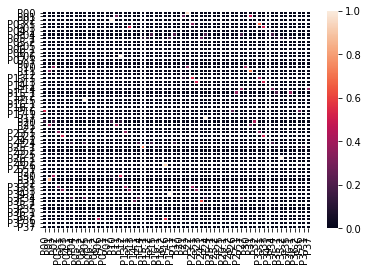

In [19]:

# perform rowwise normalisation on mapping_adj
prop_names = [myP.name for myP in network.memory.Ps]
vis_mappings(mapping_mat=mapping_adj,prop_names=prop_names)
error_val = mapping_error(mapping_mat=mapping_adj)
print(error_val)

In [18]:
import pickle
f = open(parameters['results'],"wb")
pickle.dump(simulated_data,f)
f.close()

# Trials
## The kinds of tests that have been done and their results :

1. Keeping the object hanging (no predicate for object) means the RB is not created for the corresponding object. Weird.

1.1 Making the predicate a one-hot semantic perhaps? - Does not work

1.2 Making the predicate an empty semantic? - Does not work

1.3 Making the predicate a one-hot semantic that is orthogonal to other vectors? still noisy

2. Keeping the predicate hanging (no object for predicate)


3. Making the words 1 hot representations of their lexical properties, so here subject nouns, object nouns have a 1 hot rep, verbs, complemnetizer verbs, adjectives - Does MUCH BETTER. Promising results, but why are the mappings not perfect still?

3.1 Increase/decrease eta - nope - only makes existing connections stronger/weaker

3.2 gamma/delta/Hebbbias - (currently 0.3, .1, .5)

3.3 Don't ignore object semantics, and keep asDORA True - works better than 3.0

3.4 Try changing the predicate to the noun and keep the object empty - worked fine

4. Added loss metric. Now retry for all previous analysis - 100 runs

4.1 with one_to_one=True and max_norm=False, asDORA = True, ignore_object_sem = False, RMSE = 0.09

4.2 with one_to_one=True and max_norm=True, asDORA = True, ignore_objetct_sem=False, RMSE = 0.05 (def looks better)

4.3 try to use WordGCN and RMSE = .14

4.4 baseline_mapping RMSE = 0.103 (better than wordGCN :O )

4.5 setting embedding dimension = 5, and testing for simple word2vec model, RMSE = 0.12 (still worse than baseline)

5. Understanding object/predicate semantic usage :

5.3 strategic mapping has to be True for asDORA == False ( see do_mapping() )

5.4 Try with new semantic update - previous update was non linear max norm update. New update uses only link weight * parent act - RMSE = 

5.5 Try with new semantic update - added one hot semantic to empty object to distinguish it from other semantics, made sure ignore_object_semantics does not do what it should in the update_semantic code. 
RMSE = 0.098

5.6 Try with making predicate empty rather than object, RMSE = 0.108 :/ 

## Firing order similarity analysis : 

To make mapping more efficient, we have to consider firing order similarity in the mix. To make things easy, we have the firing order of the propositions in the driver. This is given by the ordering of the RBs themselves. 

To downweight/upweight the existing mapping connections, we need to consider the following :

5.1 We consider mappings in RBs and above. Therefore for every RB in the driver, we take a look at the POs that are connected to it in the driver, and the RB it maps to in the recipient, and its POs in the Recipient.

5.2 The mapping connection between RBs is upweighted if the indices of its POs match. Ex - RB1 maps to RB2 with weight w. PO11 and PO12 are the POs connected to RB1, and PO21 and PO22 are the POs connected to RB2. index(PO11), index(PO12), index(PO21), index(PO22) indicate where they appear in the RBs. Spearman Rank correlation between them should point to how similar they are. 

## Stuff to do : 

1. First, collect all mapping hypotheses in one place. This consists of all connections from Driver propositions to all recipient tokens of same type.

1.1 Don't break it now, but the Luce's choice algorithm is a bit weird. Gotta see why they use it. - instead of random threshold to retrieve analogs, use a fixed threshold = 0.1 currently

1.2 with threshold = 0.1, biasing proposition length as well, RMSE = 0.11 - looks bad. Got to find out a way to include RB firing order instead. 

1.3 Make sure P in parent is mapped to P in parent only. 

1.4 After taking out the one to one mapping constraint, mappings improve. - RMSE = 0.0853, set parent_bias = 0.5! 

1.5 setting parent_bias = 0.1 , 0.088 (not significant enough imo)

1.6 see how firing order similarity is affecting mapping coeff. Currently, mapping is in SSL, guided by a simple Hebbian learning rule that has coactivation as its basis. added correlations between activations to update_hyp. Correlations + one_to_one == True, RMSE = 0.067, one_to_one == False, RMSE = 0.077 (higher rmse :O )

1.7 Something to test out - parent and child modes need to be updated based on presence of parentRBs, not activations alons, nah? 

1.8 Run with larger prop number

1.9 Non recursive correlational mapping - 0.111

2.0 Firing by POs, mapping not reset after each run (god knows why that was being done in the first place)

2.1 Why does retrieval by bias_analog work so strangely? 

## Results - 

1.1 Collect RMSE over time, and plot the evolution
1.2 Comparison across word embedding strategies used
1.3 Record RB firing for proposition 0 in Ding stimuli style
